## Analyse Exploratoire des Données Éducatives pour l'Expansion Internationale d'Academy
***


### Introduction

Academy, une start-up EdTech en pleine croissance, envisage une expansion internationale. Notre objectif est d'analyser les données éducatives fournies par la Banque mondiale pour identifier les pays ayant un fort potentiel de clients pour nos services éducatifs en ligne. Cette analyse pré-exploratoire nous aidera à informer la stratégie d'expansion d'Academy en identifiant les zones géographiques les plus prometteuses.

### Problématique

La question centrale de cette analyse est : "Quels pays présentent le plus grand potentiel pour l'expansion des services d'Academy, en termes d'accès à l'éducation et de la demande pour l'enseignement en ligne ?" Nous visons à répondre à cette question en examinant divers indicateurs.

### <a name="C4"> Mise en Place de l'Environnement de Travail</a>  
### <a name="C4"> Observation des données </a>  
<font color='aqua'> 1. country_df </font>  
<font color='aqua'> 2. country_series_df </font>   
<font color='aqua'> 3. data_df </font>  
<font color='aqua'> 4. footnote_df </font>   
<font color='aqua'> 5. series_df </font>  

### <a name="C4">Traitement des données </a>  
<font color='aqua'> 1. Sélection des données </font>  
<font color='aqua'> 2. Sélection des Indicateurs </font>  

### <a name="C4"> Analyse exploratoire </a>  
<font color='aqua'> 1. Analyse univariée </font>  
<font color='aqua'> 2. Analyse multi-variée </font>  
 <font color='aqua'> 3. Classement des pays  </font>  



## <a name="C4"> Mise en Place de l'Environnement de Travail</a>

Nous commençons par configurer notre environnement de travail en important les librairies nécessaires.

- Installation des Librairies

In [4]:
# Installation de la librairie missingno
!pip install missingno

# Indication d'installation réussie
print("Librairie istallée avec succès !")

Librairie istallée avec succès !


In [6]:
# Importation des librairies nécessaires pour le projet

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
from scipy import stats  
import missingno as msno
import os
os.environ['OMP_NUM_THREADS'] = '1'
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

# Afficher les graphiques directement dans le notebook
%matplotlib inline

# Configuration de Seaborn pour améliorer l'esthétique des graphiques
sns.set(style="whitegrid")

# Afficher plus de lignes et de colonnes
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',70)

# Indication d'importations réussies
print("Librairies importées avec succès !")


Librairies importées avec succès !


In [14]:
def print_imported_versions():
    imported_packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scipy', 'missingno', 'sklearn']
    for package_name in imported_packages:
        try:
            package = __import__(package_name)
            print(f"{package_name}: {package.__version__}")
        except ImportError:
            print(f"{package_name}: Not installed")

print_imported_versions()

pandas: 2.0.3
numpy: 1.24.3
matplotlib: 3.7.2
seaborn: 0.12.2
scipy: 1.11.1
missingno: 0.4.2
sklearn: 1.3.0


Nous lisons ensuite les fichiers de données issus du site de la Banque Mondiale.

- Lecture des fichiers de données

In [690]:
# Chargement des fichiers CSV dans des DataFrames pandas
country_df = pd.read_csv('EdStatsCountry.csv')
country_series_df = pd.read_csv('EdStatsCountry-Series.csv')
data_df = pd.read_csv('EdStatsData.csv')
footnote_df = pd.read_csv('EdStatsFootNote.csv')
series_df = pd.read_csv('EdStatsSeries.csv')

# Indication d'importations réussies
print("5 fichiers importés avec succès !")

5 fichiers importés avec succès !


- Ecriture des fonctions utiles

Avant de préparer nos données, nous devons obtenir une description exacte de ces dernières. Pour cela, nous créons une fonction qui retourne un tableau comprenant toutes les informations dont nous avons besoin :

In [691]:
def data_info(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs nulles']=df.isna().sum()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

# Indication de réussite
print("Fonction data_info créée avec succès !")

Fonction data_info créée avec succès !


Nous souhaitons visualiser le taux de remplissage de certains indicateurs, pour cela nous créons une fonction qui affiche sur un histogramme le taux de remplissage des colonnes, avec la possibilité d'ignorer les colonnes non pertinentes.

In [692]:
def fill_rates_plot(dataframe, ignore_columns=None):
    # Filtrer les colonnes si nécessaire
    if ignore_columns is not None:
        dataframe = dataframe.drop(columns=ignore_columns, errors='ignore')

    # Calcul du taux de remplissage pour chaque colonne
    fill_rates = dataframe.notnull().mean() * 100

    # Création de l'histogramme
    plt.figure(figsize=(14, 4))
    fill_rates.plot(kind='bar', color='steelblue')
    plt.title('Taux de remplissage des colonnes')
    plt.xlabel('Colonnes')
    plt.ylabel('Taux de remplissage (%)')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')
    
    # Affichage de l'histogramme
    plt.show()
    
# Indication de réussite
print("Fonction fill_rates_plot créée avec succès !")

Fonction fill_rates_plot créée avec succès !


Afin d'explorer les dataframes, nous créons une fonction Python pour rechercher des mots-clés dans un DataFrame et afficher les lignes correspondantes.

In [693]:
def search_keywords(df, keywords, search_columns=None, return_columns=None):
    # Si aucune colonne de recherche spécifique n'est fournie, rechercher dans toutes les colonnes
    if search_columns is None:
        search_columns = df.columns

    # Création d'un masque pour les lignes contenant l'un des mots-clés dans les colonnes de recherche
    mask = df[search_columns].apply(lambda x: x.astype(str).str.contains('|'.join(keywords), case=False, na=False)).any(axis=1)

    # Si aucune colonne de retour spécifique n'est fournie, utiliser les mêmes colonnes que pour la recherche
    if return_columns is None:
        return_columns = search_columns

    # Renvoie les valeurs des colonnes spécifiées sous forme de liste
    return df.loc[mask, return_columns].values.tolist()

# Indication de réussite
print("Fonction search_keywords créée avec succès !")

Fonction search_keywords créée avec succès !


Afin de compèter les colonnes de dates incomplètes, nous créons une fonction qui rempli les valeurs manquantes par des variables de colonnes précédentes.

In [694]:
def fill_missing_with_last_known(data, start_year, end_year):
   
    # Sélectionner les colonnes des années concernées
    year_columns = [str(year) for year in range(start_year, end_year+1)]
    
    # Appliquer ffill() pour remplir les valeurs manquantes avec la dernière valeur connue par ligne
    data[year_columns] = data[year_columns].ffill(axis=1)
    
    # Retourner le DataFrame avec les valeurs manquantes remplies pour l'année end_year
    return data


# Indication de réussite
print("Fonction def fill_missing_with_last_known créée avec succès !")

Fonction def fill_missing_with_last_known créée avec succès !


## <a name="C4"> Observation des données </a>


Pour notre étude, voici les informations pertinentes que nous recherchons en priortité dans notre base de donnée :

- Région et Groupe de Revenu: Cela peut aider à identifier les marchés potentiels en fonction de la situation économique et géographique. Les pays à revenu plus élevé pourraient avoir une plus grande capacité de dépense pour les cours en ligne.

- Dernier recensement de la population: Les données démographiques récentes sont cruciales pour évaluer la taille potentielle du marché dans chaque pays.

- Enquêtes auprès des ménages: Ces enquêtes peuvent fournir des informations sur les niveaux d'éducation et les besoins de formation des adultes dans différents pays.

- Données sur le revenu et les dépenses: Cela peut donner une idée du pouvoir d'achat des adultes dans différents pays, ce qui est crucial pour fixer des prix adaptés.

- Données sur l'accès à Internet: Bien que cela ne soit pas directement mentionné dans les premières lignes, si le fichier contient des informations sur l'accès à Internet ou la pénétration des technologies numériques, cela serait extrêmement pertinent.

- Notes spéciales: Toute mention spécifique liée à l'éducation, à la technologie, ou à des changements récents dans la politique ou l'économie d'un pays pourrait influencer la demande de cours en ligne.

### <font color='aqua'> 1. country_df </font>

#### <font color='skyblue'> Description du fichier </font>


Le fichier "EdStatsCountry.csv" semble être un ensemble de données contenant des informations sur différents pays. Le fichier contient :

- Codes et Noms des Pays : Il y a plusieurs colonnes dédiées aux codes des pays (comme le "Country Code" et le "WB-2 code") et aux noms des pays dans différents formats (comme "Short Name", "Table Name", "Long Name").

- Informations Monétaires et Régionales : La monnaie utilisée dans chaque pays est indiquée, ainsi que la région du monde à laquelle le pays appartient et son groupe de revenu (par exemple, "Low income", "Upper middle income").

- Données Démographiques et Économiques : Le fichier inclut des informations telles que la dernière année de recensement de la population, les enquêtes auprès des ménages, et les données sur les revenus et les dépenses.

- Autres Informations Spécifiques : Il y a des colonnes pour des informations plus spécifiques comme le système de diffusion des données du FMI, si l'enregistrement des naissances et décès est complet, et les dernières données sur le commerce et l'agriculture.

In [695]:
# Observation du dataframe
country_df.head(2)

Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   

                                       Special Notes  \
0  SNA data for 2000-2011 are updated from offici...   
1  Fiscal year end: March 20; reporting period fo...   

                      Region          Income Group WB-2 code  \
0  Latin America & Caribbean  High income: nonOECD        AW   
1                 South Asia            Low income        AF   

  National accounts base year  National accounts reference year  \
0                        2000                               NaN   
1                     2002/03                               NaN   

                 SNA price valuation Lending category Other groups  \
0  Value added at basic prices (VAB)              NaN          NaN   
1  Value added at basic prices (VAB)              IDA         HIPC   

                         System of National Accounts  \
0  Country uses the 1993 System of National Accou...   
1  Country uses the 1993 System of National Accou...   

  Alternative conversion factor PPP survey year  \
0                           NaN             NaN   
1                           NaN             NaN   

              Balance of Payments Manual in use  \
0  IMF Balance of Payments Manual, 6th edition.   
1                                           NaN   

  External debt Reporting status       System of trade  \
0                            NaN  Special trade system   
1                         Actual  General trade system   

     Government Accounting concept           IMF data dissemination standard  \
0                              NaN                                       NaN   
1  Consolidated central government  General Data Dissemination System (GDDS)   

  Latest population census                            Latest household survey  \
0                     2010                                                NaN   
1                     1979  Multiple Indicator Cluster Survey (MICS), 2010/11   

  Source of most recent Income and expenditure data  \
0                                               NaN   
1           Integrated household survey (IHS), 2008   

  Vital registration complete Latest agricultural census  \
0                         Yes                        NaN   
1                         NaN                    2013/14   

   Latest industrial data  Latest trade data Latest water withdrawal data  \
0                     NaN             2012.0                          NaN   
1                     NaN             2012.0                         2000   

   Unnamed: 31  
0          NaN  
1          NaN

Nous utilisons notre fonction data_info pour en savoir plus.

In [696]:
# Observation des informations sur le dataframe
data_info(country_df)

nombre de valeurs non nulles  \
colonne                                                                           
Country Code                                                                241   
Short Name                                                                  241   
Table Name                                                                  241   
Long Name                                                                   241   
2-alpha code                                                                238   
Currency Unit                                                               215   
Special Notes                                                               145   
Region                                                                      214   
Income Group                                                                214   
WB-2 code                                                                   240   
National accounts base year                                                 205   
National accounts reference year                                             32   
SNA price valuation                                                         197   
Lending category                                                            144   
Other groups                                                                 58   
System of National Accounts                                                 215   
Alternative conversion factor                                                47   
PPP survey year                                                             145   
Balance of Payments Manual in use                                           181   
External debt Reporting status                                              124   
System of trade                                                             200   
Government Accounting concept                                               161   
IMF data dissemination standard                                             181   
Latest population census                                                    213   
Latest household survey                                                     141   
Source of most recent Income and expenditure data                           160   
Vital registration complete                                                 111   
Latest agricultural census                                                  142   
Latest industrial data                                                      107   
Latest trade data                                                           185   
Latest water withdrawal data                                                179   
Unnamed: 31                                                                   0   

                                                   nombre de valeurs uniques  \
colonne                                                                        
Country Code                                                             241   
Short Name                                                               241   
Table Name                                                               241   
Long Name                                                                241   
2-alpha code                                                             238   
Currency Unit                                                            152   
Special Notes                                                            131   
Region                                                                     7   
Income Group                                                               5   
WB-2 code                                                                240   
National accounts base year                                               43   
National accounts reference year                                          11   
SNA price valuation                                                        2   
Lending category            

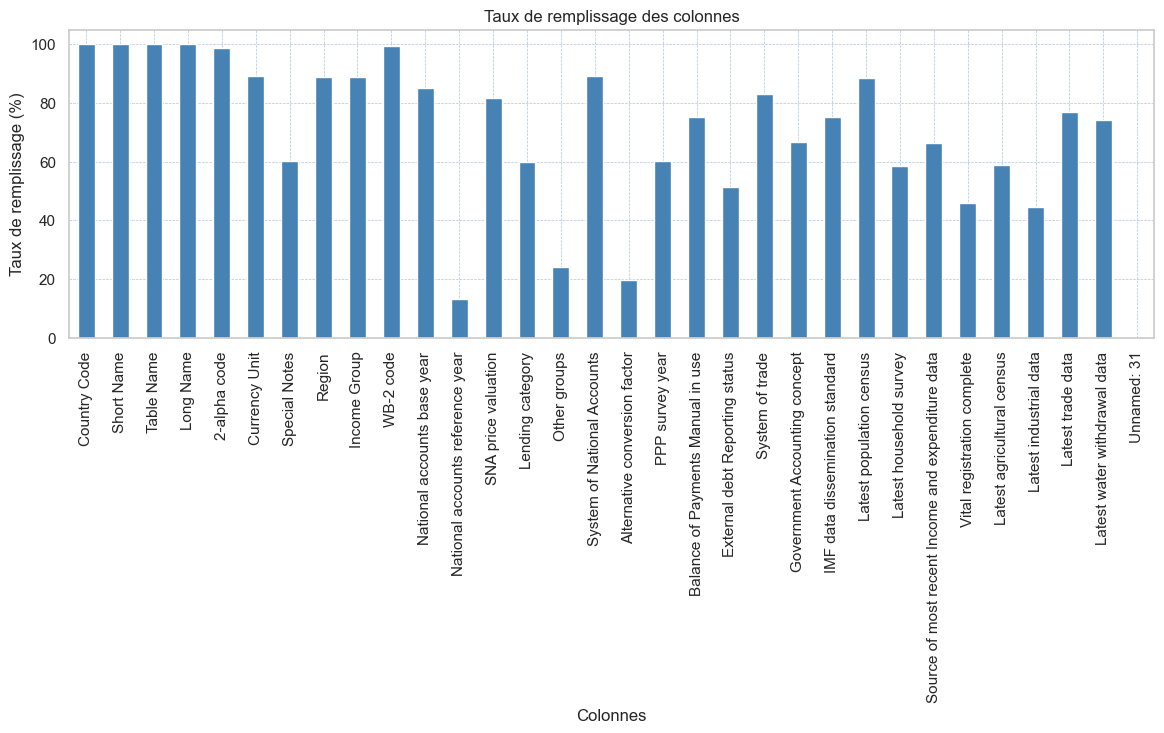

In [697]:
fill_rates_plot(country_df)

- Le dataframe contient 241 lignes et 32 colonnes
- Chaque ligne correspond à un pays ou une région du monde 
- Plusieurs colonnes peuvent être considérées comme clé primaire avec 241 valeurs uniques
- Chaque colonne apporte une indication démographique ou économique
- Plusieurs colonnes présentent des valeurs manquantes, notamment Special Notes, Income Group, Lending category, entre autres.
- Une colonne Unnamed: 31 ne contient aucune données


#### <font color='skyblue'> Vérification des clé primaire et recherche des doublons </font>


Tous les codes de pays (Country Code) sont conformes au format standard (3 lettres alphabétiques).
Aucun doublon n'a été trouvé dans la colonne Country Code.

In [698]:
# Vérification de la Cohérence des Clés de Fusion et Recherche de Doublons pour le nouveau fichier

# Vérification des formats de 'Country Code'
country_code_format_new = country_df['Country Code'].apply(lambda x: x.isalpha() and len(x) == 3).all()

# Recherche de doublons dans les clés de fusion potentielles
duplicate_entries_new = country_df.duplicated(subset=['Country Code']).sum()

country_code_format_new, duplicate_entries_new

(True, 0)

Les données de EdStatsCountry.csv semblent cohérentes et appropriées pour une fusion, en particulier avec la colonne CountryCode du premier fichier. Il n'y a pas de doublons dans les clés de fusion, ce qui facilite l'intégration avec d'autres ensembles de données.

 
#### <font color='skyblue'> Prétraitement des données </font>


In [699]:
# Suppression de la colonne 'Unnamed: 3'
country_df = country_df.drop(columns=['Unnamed: 31'])

# Vérification du nettoyage
country_df.head(2)

Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   

                                       Special Notes  \
0  SNA data for 2000-2011 are updated from offici...   
1  Fiscal year end: March 20; reporting period fo...   

                      Region          Income Group WB-2 code  \
0  Latin America & Caribbean  High income: nonOECD        AW   
1                 South Asia            Low income        AF   

  National accounts base year  National accounts reference year  \
0                        2000                               NaN   
1                     2002/03                               NaN   

                 SNA price valuation Lending category Other groups  \
0  Value added at basic prices (VAB)              NaN          NaN   
1  Value added at basic prices (VAB)              IDA         HIPC   

                         System of National Accounts  \
0  Country uses the 1993 System of National Accou...   
1  Country uses the 1993 System of National Accou...   

  Alternative conversion factor PPP survey year  \
0                           NaN             NaN   
1                           NaN             NaN   

              Balance of Payments Manual in use  \
0  IMF Balance of Payments Manual, 6th edition.   
1                                           NaN   

  External debt Reporting status       System of trade  \
0                            NaN  Special trade system   
1                         Actual  General trade system   

     Government Accounting concept           IMF data dissemination standard  \
0                              NaN                                       NaN   
1  Consolidated central government  General Data Dissemination System (GDDS)   

  Latest population census                            Latest household survey  \
0                     2010                                                NaN   
1                     1979  Multiple Indicator Cluster Survey (MICS), 2010/11   

  Source of most recent Income and expenditure data  \
0                                               NaN   
1           Integrated household survey (IHS), 2008   

  Vital registration complete Latest agricultural census  \
0                         Yes                        NaN   
1                         NaN                    2013/14   

   Latest industrial data  Latest trade data Latest water withdrawal data  
0                     NaN             2012.0                          NaN  
1                     NaN             2012.0                         2000

### <font color='aqua'> 2. country_series_df </font>


#### <font color='skyblue'> Description du fichier  </font>


Le fichier "EdStatsCountry-Series.csv" semble contenir des informations liées aux séries statistiques par pays. Voici un aperçu de son contenu :

- CountryCode: Le code du pays, permettant l'identification de chaque nation.

- SeriesCode: Un code représentant un type spécifique de donnée statistique ou d'indicateur.

- DESCRIPTION: Des descriptions détaillées de chaque série de données, fournissant des informations sur la source des données, la méthode de calcul, etc.

In [700]:
# Observation du dataframe
country_series_df.head(2)

CountryCode   SeriesCode                                        DESCRIPTION  \
0         ABW  SP.POP.TOTL  Data sources : United Nations World Population...   
1         ABW  SP.POP.GROW  Data sources: United Nations World Population ...   

   Unnamed: 3  
0         NaN  
1         NaN

Nous utilisons notre fonction data_info pour en savoir plus.

In [701]:
# Observation des informations sur le dataframe
data_info(country_series_df)

nombre de valeurs non nulles  nombre de valeurs uniques  \
colonne                                                                
CountryCode                           613                        211   
SeriesCode                            613                         21   
DESCRIPTION                           613                         97   
Unnamed: 3                              0                          0   

            type de donnée  nombre de valeurs nulles  \
colonne                                                
CountryCode         object                         0   
SeriesCode          object                         0   
DESCRIPTION         object                         0   
Unnamed: 3         float64                       613   

             pourcentage de valeurs nulles  
colonne                                     
CountryCode                            0.0  
SeriesCode                             0.0  
DESCRIPTION                            0.0  
Unnamed: 3                           100.0

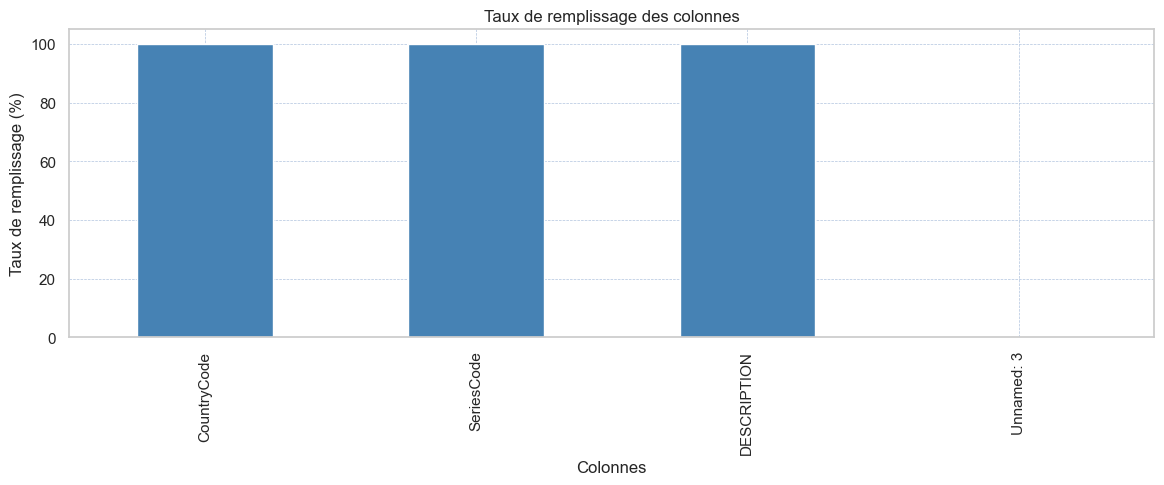

In [702]:
fill_rates_plot(country_series_df)

- Le dataframe contient 613 lignes et 4 colonnes
- La clé primaire semble être CountryCode avec 211 valeurs uniques
- Chaque colonne apporte une indication démographique ou économique
- CountryCode, SeriesCode, et DESCRIPTION sont de type object (probablement des chaînes de caractères).
- Unnamed: 3 est de type float64, mais il semble être entièrement vide.


#### <font color='skyblue'> Vérification des clé primaire et recherche des doublons  </font>


- Tous les codes de pays sont alphabétiques et consistent en 3 lettres, ce qui est conforme à la norme ISO.
- Aucun doublon n'a été trouvé dans les combinaisons de CountryCode et SeriesCode. Cela indique une bonne intégrité des données pour les opérations de fusion.

In [703]:
# Vérification de la Cohérence des Clés de Fusion et Recherche de Doublons

# Vérification des formats de 'CountryCode' et 'SeriesCode'
country_code_format = country_series_df['CountryCode'].apply(lambda x: x.isalpha() and len(x) == 3).all()
series_code_format = country_series_df['SeriesCode'].apply(lambda x: x.isalnum()).all()

# Recherche de doublons dans les clés de fusion potentielles
duplicate_entries = country_series_df.duplicated(subset=['CountryCode', 'SeriesCode']).sum()

country_code_format, series_code_format, duplicate_entries


(True, False, 0)

Les données semblent cohérentes et appropriées pour une fusion avec d'autres tables, à condition que les formats de SeriesCode soient compatibles. Il n'y a pas de doublons dans les clés de fusion, ce qui est un bon indicateur pour des opérations de merge réussies.


#### <font color='skyblue'> Prétraitement des données  </font>


In [704]:
# Suppression de la colonne 'Unnamed: 3'
country_series_df = country_series_df.drop(columns=['Unnamed: 3'])

# Vérification du nettoyage
country_series_df.head()

CountryCode         SeriesCode  \
0         ABW        SP.POP.TOTL   
1         ABW        SP.POP.GROW   
2         AFG        SP.POP.GROW   
3         AFG  NY.GDP.PCAP.PP.CD   
4         AFG        SP.POP.TOTL   

                                         DESCRIPTION  
0  Data sources : United Nations World Population...  
1  Data sources: United Nations World Population ...  
2  Data sources: United Nations World Population ...  
3                 Estimates are based on regression.  
4  Data sources : United Nations World Population...

### <font color='aqua'> 3. data_df </font>

#### <font color='skyblue'> Description du fichier  </font>


Le fichier "EdStatsData.csv" semble contenir l'évolution de certains indicateurs dans le temps. Voici un aperçu de son contenu :

- Country Name : Le nom permettant l'identification de chaque nation.

- Indicator Name : Nom de l'indicateur mesuré.

- Année : Année de la mesure de l'indicateur entre 1970 et projections jusqu'à 2100

In [705]:
# Observation du dataframe
data_df.head(2)

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   

                                      Indicator Name Indicator Code  1970  \
0  Adjusted net enrolment rate, lower secondary, ...     UIS.NERA.2   NaN   
1  Adjusted net enrolment rate, lower secondary, ...   UIS.NERA.2.F   NaN   

   1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  2006  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2020  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   2025  2030  2035  2040  2045  2050  2055  2060  2065  2070  2075  2080  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   2085  2090  2095  2100  Unnamed: 69  
0   NaN   NaN   NaN   NaN          NaN  
1   NaN   NaN   NaN   NaN          NaN

Nous utilisons notre fonction data_info pour en savoir plus.

In [706]:
# Observation des informations sur le dataframe
data_info(data_df)

nombre de valeurs non nulles  nombre de valeurs uniques  \
colonne                                                                   
Country Name                          886930                        242   
Country Code                          886930                        242   
Indicator Name                        886930                       3665   
Indicator Code                        886930                       3665   
1970                                   72288                      24595   
1971                                   35537                      30892   
1972                                   35619                      30982   
1973                                   35545                      30988   
1974                                   35730                      31139   
1975                                   87306                      37838   
1976                                   37483                      32679   
1977                                   37574                      32808   
1978                                   37576                      32887   
1979                                   36809                      32359   
1980                                   89122                      39456   
1981                                   38777                      34090   
1982                                   37511                      32969   
1983                                   38460                      33683   
1984                                   38606                      33903   
1985                                   90296                      41133   
1986                                   39372                      34774   
1987                                   38641                      34021   
1988                                   38552                      34013   
1989                                   37540                      33181   
1990                                  124405                      72800   
1991                                   74437                      67172   
1992                                   75543                      68026   
1993                                   75793                      68440   
1994                                   77462                      69974   
1995                                  131361                      79225   
1996                                   76807                      69787   
1997                                   73453                      66665   
1998                                   84914                      77746   
1999                                  118839                     104452   
2000                                  176676                     115971   
2001                                  123509                     108633   
2002                                  124205                     108974   
2003                                  130363                     114344   
2004                                  128814                     113431   
2005                                  184108                     123821   
2006                                  140312                     124989   
2007                                  137272                     121541   
2008                                  134387                     119598   
2009                                  142108                     126177   
2010                                  242442                     135853   
2011                                  146012                     128444   
2012                                  147264                     130040   
2013                                  137509                     120987   
2014                                  113789                     100187   
2015                                  131058                      79334   
2016                                   16460                      12749   
2017                                     

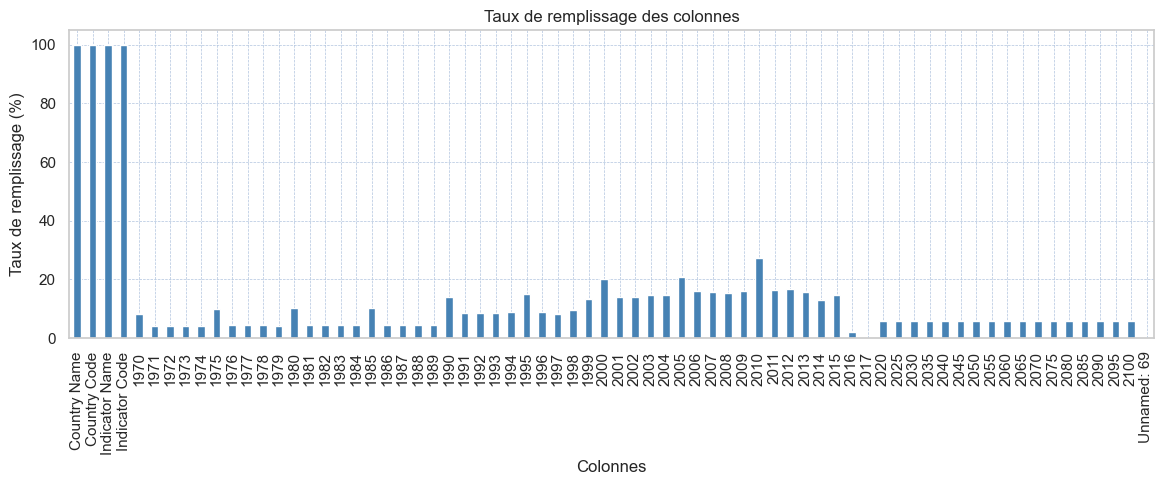

In [707]:
fill_rates_plot(data_df)

- Le dataframe contient 886929 lignes et 70 colonnes
- Chaque ligne correspond à un indicateur mesuré dans un pays ou une région du monde 
- Les colonnes Country Name et Country Codes peuvent être considérées comme clé primaire avec 242 valeurs uniques
- 
- Une colonne Unnamed: 69 ne contient aucune données

#### <font color='skyblue'> Vérification des clé primaire et recherche des doublons  </font>


- Tous les codes de pays sont alphabétiques et consistent en 3 lettres, ce qui est conforme à la norme ISO.
- Aucun doublon n'a été trouvé dans les combinaisons de CountryCode. Cela indique une bonne intégrité des données pour les opérations de fusion.

In [708]:
# Vérification de la Cohérence des Clés de Fusion et Recherche de Doublons

# Vérification des formats de 'CountryCode' et 'SeriesCode'
country_code_format = data_df['Country Code'].apply(lambda x: x.isalpha() and len(x) == 3).all()

# Recherche de doublons dans les clés de fusion potentielles
duplicate_entries = data_df.duplicated(subset=['Country Code']).sum()

country_code_format, series_code_format, duplicate_entries

(True, False, 886688)

Les données semblent cohérentes et appropriées pour une fusion avec d'autres tables, à condition que les formats de Country code soient compatibles. Il n'y a pas de doublons dans les clés de fusion, ce qui est un bon indicateur pour des opérations de merge réussies.

#### <font color='skyblue'> Prétraitement des données  </font>


In [709]:
# Suppression de la colonne 'Unnamed: 3'
data_df = data_df.drop(columns=['Unnamed: 69'])

# Vérification du nettoyage
data_df.head(2)

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   

                                      Indicator Name Indicator Code  1970  \
0  Adjusted net enrolment rate, lower secondary, ...     UIS.NERA.2   NaN   
1  Adjusted net enrolment rate, lower secondary, ...   UIS.NERA.2.F   NaN   

   1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  2006  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2020  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   2025  2030  2035  2040  2045  2050  2055  2060  2065  2070  2075  2080  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   2085  2090  2095  2100  
0   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN

### <font color='aqua'> 4. footnote_df </font>

#### <font color='skyblue'> Description du fichier  </font>


Le fichier "EdStatsFootNote.csv" semble contenir des informations liées aux séries statistiques par pays. Voici un aperçu de son contenu :

- CountryCode: Le code du pays, permettant l'identification de chaque nation.

- SeriesCode: Un code représentant un type spécifique de donnée statistique ou d'indicateur.

- DESCRIPTION: Des descriptions détaillées de chaque série de données, fournissant des informations sur la source des données, la méthode de calcul, etc.

In [710]:
# Observation du dataframe
footnote_df.head(2)

CountryCode      SeriesCode    Year          DESCRIPTION  Unnamed: 4
0         ABW  SE.PRE.ENRL.FE  YR2001  Country estimation.         NaN
1         ABW  SE.TER.TCHR.FE  YR2005  Country estimation.         NaN

Nous utilisons notre fonction data_info pour en savoir plus.

In [711]:
# Observation des informations sur le dataframe
data_info(footnote_df)

nombre de valeurs non nulles  nombre de valeurs uniques  \
colonne                                                                
CountryCode                        643638                        239   
SeriesCode                         643638                       1558   
Year                               643638                         56   
DESCRIPTION                        643638                       9102   
Unnamed: 4                              0                          0   

            type de donnée  nombre de valeurs nulles  \
colonne                                                
CountryCode         object                         0   
SeriesCode          object                         0   
Year                object                         0   
DESCRIPTION         object                         0   
Unnamed: 4         float64                    643638   

             pourcentage de valeurs nulles  
colonne                                     
CountryCode                            0.0  
SeriesCode                             0.0  
Year                                   0.0  
DESCRIPTION                            0.0  
Unnamed: 4                           100.0

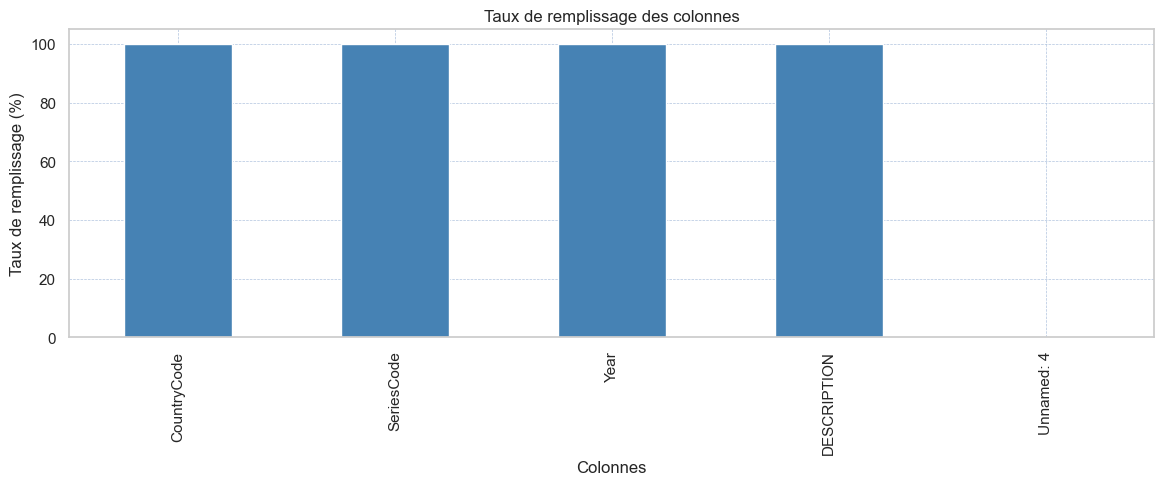

In [712]:
fill_rates_plot(footnote_df)

- Le dataframe contient 643638 lignes et 5 colonnes
- Chaque ligne correspond à un code de séries d'une année par pays ou une région du monde 
- CountryCode peut être considérée comme clé primaire avec 239 valeurs uniques
- Une colonne Unnamed: 4 ne contient aucune données

#### <font color='skyblue'> Vérification des clé primaire et recherche des doublons  </font>


- Tous les codes de pays sont alphabétiques et consistent en 3 lettres, ce qui est conforme à la norme ISO.
- Aucun doublon n'a été trouvé dans les combinaisons de CountryCode et SeriesCode. Cela indique une bonne intégrité des données pour les opérations de fusion.

In [713]:
# Vérification de la Cohérence des Clés de Fusion et Recherche de Doublons pour le fichier EdStatsFootNote.csv

# Vérification des formats de 'CountryCode' et 'SeriesCode'
country_code_format_footnote = footnote_df['CountryCode'].apply(lambda x: x.isalpha() and len(x) == 3).all()
series_code_format_footnote = footnote_df['SeriesCode'].apply(lambda x: x.isalnum()).all()

# Recherche de doublons dans les clés de fusion potentielles
duplicate_entries_footnote = footnote_df.duplicated(subset=['CountryCode', 'SeriesCode', 'Year']).sum()

country_code_format_footnote, series_code_format_footnote, duplicate_entries_footnote


(True, False, 0)

Les données de EdStatsFootNote.csv semblent cohérentes et adaptées pour une fusion, notamment avec les colonnes CountryCode et SeriesCode des autres fichiers. L'absence de doublons dans les clés de fusion indique une bonne intégrité des données pour les opérations de fusion.

#### <font color='skyblue'> Prétraitement des données  </font>


In [714]:
# Suppression de la colonne 'Unnamed: 3'
footnote_df = footnote_df.drop(columns=['Unnamed: 4'])

# Vérification du nettoyage
footnote_df.head()

CountryCode      SeriesCode    Year          DESCRIPTION
0         ABW  SE.PRE.ENRL.FE  YR2001  Country estimation.
1         ABW  SE.TER.TCHR.FE  YR2005  Country estimation.
2         ABW  SE.PRE.TCHR.FE  YR2000  Country estimation.
3         ABW  SE.SEC.ENRL.GC  YR2004  Country estimation.
4         ABW     SE.PRE.TCHR  YR2006  Country estimation.

### <font color='aqua'> 5. series_df </font>


#### <font color='skyblue'> Description du fichier  </font>


Le fichier "EdStatsSeries.csv" semble contenir des informations liées aux séries statistiques par pays. Voici un aperçu de son contenu :

- Series Code	: Le code du pays, permettant l'identification de chaque nation.

- Topic / Indicator Name	: L'indicateur mesuré.

- definition: Des descriptions détaillées de chaque indicateur mesuré.

In [715]:
# Observation du dataframe
series_df.head(2)

Series Code       Topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   

                                      Indicator Name  \
0  Barro-Lee: Percentage of female population age...   
1  Barro-Lee: Percentage of population age 15-19 ...   

                                    Short definition  \
0  Percentage of female population age 15-19 with...   
1  Percentage of population age 15-19 with no edu...   

                                     Long definition  Unit of measure  \
0  Percentage of female population age 15-19 with...              NaN   
1  Percentage of population age 15-19 with no edu...              NaN   

  Periodicity Base Period Other notes Aggregation method  \
0         NaN         NaN         NaN                NaN   
1         NaN         NaN         NaN                NaN   

  Limitations and exceptions  Notes from original source General comments  \
0                        NaN                         NaN              NaN   
1                        NaN                         NaN              NaN   

                                              Source  \
0  Robert J. Barro and Jong-Wha Lee: http://www.b...   
1  Robert J. Barro and Jong-Wha Lee: http://www.b...   

  Statistical concept and methodology Development relevance  \
0                                 NaN                   NaN   
1                                 NaN                   NaN   

  Related source links  Other web links  Related indicators  License Type  \
0                  NaN              NaN                 NaN           NaN   
1                  NaN              NaN                 NaN           NaN   

   Unnamed: 20  
0          NaN  
1          NaN

Nous utilisons notre fonction data_info pour en savoir plus.

In [716]:
# Observation des informations sur le dataframe
data_info(series_df)

nombre de valeurs non nulles  \
colonne                                                             
Series Code                                                  3665   
Topic                                                        3665   
Indicator Name                                               3665   
Short definition                                             2156   
Long definition                                              3665   
Unit of measure                                                 0   
Periodicity                                                    99   
Base Period                                                   314   
Other notes                                                   552   
Aggregation method                                             47   
Limitations and exceptions                                     14   
Notes from original source                                      0   
General comments                                               14   
Source                                                       3665   
Statistical concept and methodology                            23   
Development relevance                                           3   
Related source links                                          215   
Other web links                                                 0   
Related indicators                                              0   
License Type                                                    0   
Unnamed: 20                                                     0   

                                     nombre de valeurs uniques type de donnée  \
colonne                                                                         
Series Code                                               3665         object   
Topic                                                       37         object   
Indicator Name                                            3665         object   
Short definition                                          1169         object   
Long definition                                           2060         object   
Unit of measure                                              0        float64   
Periodicity                                                  1         object   
Base Period                                                  4         object   
Other notes                                                 14         object   
Aggregation method                                           3         object   
Limitations and exceptions                                   9         object   
Notes from original source                                   0        float64   
General comments                                             8         object   
Source                                                      31         object   
Statistical concept and methodology                          2         object   
Development relevance                                        1         object   
Related source links                                         1         object   
Other web links                                              0        float64   
Related indicators                                           0        float64   
License Type                                                 0        float64   
Unnamed: 20                                                  0        float64   

                                     nombre de valeurs nulles  \
colonne                                                         
Series Code                                                 0   
Topic                                                       0   
Indicator Name                                              0   
Short definition                                         1509   
Long definition                                             0   
Unit of measure                                          3665   
Periodicity                                              3566   


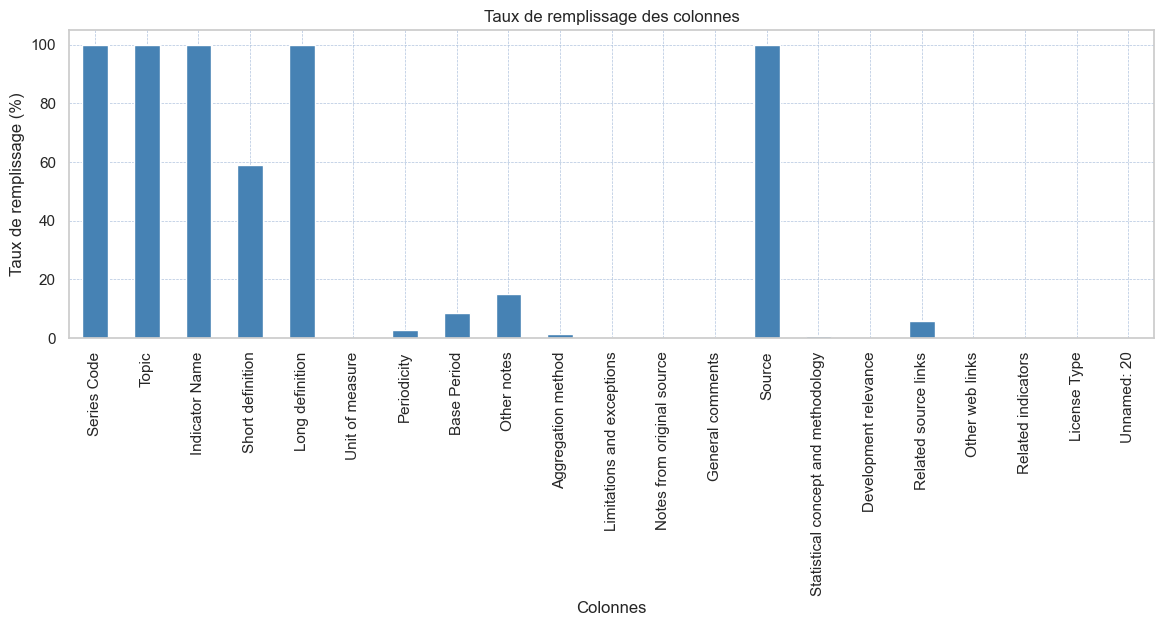

In [717]:
fill_rates_plot(series_df)

- Le dataframe contient 3665 lignes et 21 colonnes
- Chaque ligne correspond à un indicateur mesuré par série 
- Series Code peut être considérée comme clé primaire avec 3665 valeurs uniques
- Chaque colonne apporte une mesure de l'indicateur énnoncé
- Plusieurs colonnes ont des valeurs nulles ou manquantes  
- Unit of measure, Notes from original source, Other web links, Related indicators, License Type, Unnamed: 20	ne contiennent aucune données

#### <font color='skyblue'> Vérification des clé primaire et recherche des doublons  </font>


- Aucun doublon n'a été trouvé dans les combinaisons de SeriesCode. Cela indique une bonne intégrité des données pour les opérations de fusion.

In [718]:
# Vérification de la Cohérence des Clés de Fusion et Recherche de Doublons pour le fichier EdStatsFootNote.csv

# Vérification des formats de 'CountryCode' et 'SeriesCode'
series_code_format_footnote = footnote_df['SeriesCode'].apply(lambda x: x.isalnum()).all()

# Recherche de doublons dans les clés de fusion potentielles
duplicate_entries_footnote = footnote_df.duplicated(subset=['SeriesCode', 'Year']).sum()

country_code_format_footnote, series_code_format_footnote, duplicate_entries_footnote


(True, False, 620581)

Les données de EdStatsSeries.csv semblent cohérentes et adaptées pour une fusion, notamment avec les colonnes  SeriesCode des autres fichiers. L'absence de doublons dans les clés de fusion indique une bonne intégrité des données pour les opérations de fusion.

#### <font color='skyblue'> Prétraitement des données  </font>



In [719]:
# Suppression des colonnes : Unit of measure, Notes from original source, Other web links, Related indicators, License Type, Unnamed: 20
series_df = series_df.drop(columns=['Unnamed: 20','Unit of measure','Notes from original source','Other web links','Related indicators','License Type'])

# Suppression des colonnes : Periodicity, Base Period, Other notes, Aggregation method, Limitations and exceptions, General comments, Statistical concept and methodology, Development relevance, Related source links	
series_df = series_df.drop(columns=['Periodicity','Base Period','Other notes','Aggregation method','Limitations and exceptions','General comments','Statistical concept and methodology','Development relevance','Related source links'])

# Utilisez la méthode "rename" pour renommer la colonne
series_df.rename(columns={'Series Code': 'Indicator Code'}, inplace=True)
 
# Vérification du nettoyage
series_df.head()

Indicator Code       Topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   
2  BAR.NOED.15UP.FE.ZS  Attainment   
3     BAR.NOED.15UP.ZS  Attainment   
4  BAR.NOED.2024.FE.ZS  Attainment   

                                      Indicator Name  \
0  Barro-Lee: Percentage of female population age...   
1  Barro-Lee: Percentage of population age 15-19 ...   
2  Barro-Lee: Percentage of female population age...   
3  Barro-Lee: Percentage of population age 15+ wi...   
4  Barro-Lee: Percentage of female population age...   

                                    Short definition  \
0  Percentage of female population age 15-19 with...   
1  Percentage of population age 15-19 with no edu...   
2  Percentage of female population age 15+ with n...   
3  Percentage of population age 15+ with no educa...   
4  Percentage of female population age 20-24 with...   

                                     Long definition  \
0  Percentage of female population age 15-19 with...   
1  Percentage of population age 15-19 with no edu...   
2  Percentage of female population age 15+ with n...   
3  Percentage of population age 15+ with no educa...   
4  Percentage of female population age 20-24 with...   

                                              Source  
0  Robert J. Barro and Jong-Wha Lee: http://www.b...  
1  Robert J. Barro and Jong-Wha Lee: http://www.b...  
2  Robert J. Barro and Jong-Wha Lee: http://www.b...  
3  Robert J. Barro and Jong-Wha Lee: http://www.b...  
4  Robert J. Barro and Jong-Wha Lee: http://www.b...

## <a name="C4">Traitement des données </a>


Nous commençons par déterminer le nombre total d'indicateurs uniques présents dans la base de données. Nous calculons le taux de remplissage des données pour chaque année et le visualisons à l'aide d'un graphique à barres. Cette analyse nous permet de comprendre la disponibilité des données au fil du temps et d'identifier les années les plus pertinentes pour notre étude.

### <font color='aqua'> 1. Sélection des données </font>

...vente de cours en ligne. Nous nous concentrons sur la sélection d'un maximum de cinq indicateurs basés sur des critères tels que les caractéristiques démographiques de la population, l'accès à Internet et les facteurs économiques. Notre objectif est de déterminer où nous pouvons vendre la plus grande quantité de cours au meilleur prix à un public cible spécifique, afin de maximiser les profits. Nous explorerons diverses sources pour ces indicateurs, y compris l'analyse PESTEL.

#### <font color='skyblue'> Presélection des indicateurs pour l'analyse </font>


L'analyse PESTEL aide à comprendre le paysage macro-environnemental dans lequel une entreprise opère, permettant ainsi de prendre des décisions stratégiques plus éclairées. Elle évalue 6 critères : Politique, Economique, Socioculturel, Technologique, Environnemental, et Légal. Nous recherchons les indicateurs par mot clé. 

- Critère technologique : Accès internet

In [720]:
# Utilisation de la fonction search_keywords
internet_indicator = search_keywords(series_df, ['internet','computers'], search_columns=None, return_columns="Indicator Code")
internet_indicator

['IT.CMP.PCMP.P2',
 'IT.NET.USER.P2',
 'LO.PIAAC.TEC.OPT',
 'LO.PIAAC.TEC.YOU.OPT']

- Critère Démographique : Population

In [721]:
# Utilisation de la fonction search_keywords
population_indicator = search_keywords(series_df, ['Population, total'], search_columns=None, return_columns="Indicator Code")
population_indicator = ['SP.POP.TOTL']
population_indicator

['SP.POP.TOTL']

- Critère économique : Richesse

In [722]:
# Utilisation de la fonction search_keywords
wealth_indicator = search_keywords(series_df, ['GNI per capita'], search_columns=None, return_columns="Indicator Code")
wealth_indicator

['NY.GNP.PCAP.CD', 'NY.GNP.PCAP.PP.CD']

- Critère social : Chômage

In [723]:
# Utilisation de la fonction search_keywords
education_indicator = search_keywords(series_df, ['Unemployment'], search_columns=None, return_columns="Indicator Code")
education_indicator

['SL.UEM.TOTL.FE.ZS', 'SL.UEM.TOTL.MA.ZS', 'SL.UEM.TOTL.ZS']

- Critère socioculturel : Education

In [724]:
# Utilisation de la fonction search_keywords
cultural_indicator = search_keywords(series_df, ['20-24 by highest level of educational attainment'], search_columns=None, return_columns="Indicator Code")
cultural_indicator

['PRJ.ATT.2024.1.FE',
 'PRJ.ATT.2024.1.MA',
 'PRJ.ATT.2024.1.MF',
 'PRJ.ATT.2024.2.FE',
 'PRJ.ATT.2024.2.MA',
 'PRJ.ATT.2024.2.MF',
 'PRJ.ATT.2024.3.FE',
 'PRJ.ATT.2024.3.MA',
 'PRJ.ATT.2024.3.MF',
 'PRJ.ATT.2024.4.FE',
 'PRJ.ATT.2024.4.MA',
 'PRJ.ATT.2024.4.MF',
 'PRJ.ATT.2024.NED.FE',
 'PRJ.ATT.2024.NED.MA',
 'PRJ.ATT.2024.NED.MF',
 'PRJ.ATT.2024.S1.FE',
 'PRJ.ATT.2024.S1.MA',
 'PRJ.ATT.2024.S1.MF']

#### <font color='skyblue'> Modification du dataframe principal  </font>


- Création d'une liste d'indicateurs

In [725]:
indicator_list = internet_indicator + population_indicator + wealth_indicator + education_indicator + cultural_indicator
indicator_list

['IT.CMP.PCMP.P2',
 'IT.NET.USER.P2',
 'LO.PIAAC.TEC.OPT',
 'LO.PIAAC.TEC.YOU.OPT',
 'SP.POP.TOTL',
 'NY.GNP.PCAP.CD',
 'NY.GNP.PCAP.PP.CD',
 'SL.UEM.TOTL.FE.ZS',
 'SL.UEM.TOTL.MA.ZS',
 'SL.UEM.TOTL.ZS',
 'PRJ.ATT.2024.1.FE',
 'PRJ.ATT.2024.1.MA',
 'PRJ.ATT.2024.1.MF',
 'PRJ.ATT.2024.2.FE',
 'PRJ.ATT.2024.2.MA',
 'PRJ.ATT.2024.2.MF',
 'PRJ.ATT.2024.3.FE',
 'PRJ.ATT.2024.3.MA',
 'PRJ.ATT.2024.3.MF',
 'PRJ.ATT.2024.4.FE',
 'PRJ.ATT.2024.4.MA',
 'PRJ.ATT.2024.4.MF',
 'PRJ.ATT.2024.NED.FE',
 'PRJ.ATT.2024.NED.MA',
 'PRJ.ATT.2024.NED.MF',
 'PRJ.ATT.2024.S1.FE',
 'PRJ.ATT.2024.S1.MA',
 'PRJ.ATT.2024.S1.MF']

- Modification du dataframe indicateurs

In [726]:
# Filtrer le DataFrame pour ne conserver que les lignes dont la valeur utiles
series_cut = series_df[series_df['Indicator Code'].isin(indicator_list)]

# Afficher les lignes correspondantes
series_cut

Indicator Code                                              Topic  \
610         IT.CMP.PCMP.P2                     Infrastructure: Communications   
611         IT.NET.USER.P2                     Infrastructure: Communications   
1366      LO.PIAAC.TEC.OPT                                  Learning Outcomes   
1379  LO.PIAAC.TEC.YOU.OPT                                  Learning Outcomes   
1668        NY.GNP.PCAP.CD  Economic Policy & Debt: National accounts: Atl...   
1669     NY.GNP.PCAP.PP.CD    Economic Policy & Debt: Purchasing power parity   
1722     PRJ.ATT.2024.1.FE                                         Attainment   
1723     PRJ.ATT.2024.1.MA                                         Attainment   
1724     PRJ.ATT.2024.1.MF                                         Attainment   
1725     PRJ.ATT.2024.2.FE                                         Attainment   
1726     PRJ.ATT.2024.2.MA                                         Attainment   
1727     PRJ.ATT.2024.2.MF                                         Attainment   
1728     PRJ.ATT.2024.3.FE                                         Attainment   
1729     PRJ.ATT.2024.3.MA                                         Attainment   
1730     PRJ.ATT.2024.3.MF                                         Attainment   
1731     PRJ.ATT.2024.4.FE                                         Attainment   
1732     PRJ.ATT.2024.4.MA                                         Attainment   
1733     PRJ.ATT.2024.4.MF                                         Attainment   
1734   PRJ.ATT.2024.NED.FE                                         Attainment   
1735   PRJ.ATT.2024.NED.MA                                         Attainment   
1736   PRJ.ATT.2024.NED.MF                                         Attainment   
1737    PRJ.ATT.2024.S1.FE                                         Attainment   
1738    PRJ.ATT.2024.S1.MA                                         Attainment   
1739    PRJ.ATT.2024.S1.MF                                         Attainment   
2398     SL.UEM.TOTL.FE.ZS            Social Protection & Labor: Unemployment   
2399     SL.UEM.TOTL.MA.ZS            Social Protection & Labor: Unemployment   
2400        SL.UEM.TOTL.ZS            Social Protection & Labor: Unemployment   
2590           SP.POP.TOTL                      Health: Population: Structure   

                                         Indicator Name  \
610                 Personal computers (per 100 people)   
611                     Internet users (per 100 people)   
1366  PIAAC: Adults by proficiency level in problem ...   
1379  PIAAC: Young adults by proficiency level in pr...   
1668         GNI per capita, Atlas method (current US$)   
1669      GNI per capita, PPP (current international $)   
1722  Projection: Percentage of the population age 2...   
1723  Projection: Percentage of the population age 2...   
1724  Projection: Percentage of the population age 2...   
1725  Projection: Percentage of the population age 2...   
1726  Projection: Percentage of the population age 2...   
1727  Projection: Percentage of the population age 2...   
1728  Projection: Percentage of the population age 2...   
1729  Projection: Percentage of the population age 2...   
1730  Projection: Percentage of the population age 2...   
1731  Projection: Percentage of the population age 2...   
1732  Projection: Percentage of the population age 2...   
1733  Projection: Percentage of the population age 2...   
1734  Projection: Percentage of the population age 2...   
1735  Projection: Percentage of the population age 2...   
1736  Projection: Percentage of the population age 2...   
1737  Projection: Percentage of the population age 2...   
1738  Projection: Percentage of the population age 2...   
1739  Projection: Percentage of the population age 2...   
2398  Unemployment, female (% of female labor force)...   
2399  Unemployment, male (% of male labor force) (mo...   
2400  Unemployment, total (% of total labor force) (...   
2590      

In [727]:
unique_indicator = len(series_cut['Indicator Code'].unique())
print("Nombre de valeurs différentes dans 'Indicator Code':", unique_indicator)

Nombre de valeurs différentes dans 'Indicator Code': 28


Nous disposons donc de 28 indicateurs qu'il s'agira d'analyser afin d'extraire les idicateurs les plus discriminants pour notre analyse.

- Modification du dataframe principal

In [728]:
# Filtrer le DataFrame pour ne conserver que les lignes dont la valeur de "Indicator Code" est dans liste_indicateurs
data_cut = data_df[data_df['Indicator Code'].isin(indicator_list)]

# Afficher les lignes correspondantes
data_cut.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6776 entries, 1251 to 886705
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    6776 non-null   object 
 1   Country Code    6776 non-null   object 
 2   Indicator Name  6776 non-null   object 
 3   Indicator Code  6776 non-null   object 
 4   1970            364 non-null    float64
 5   1971            356 non-null    float64
 6   1972            367 non-null    float64
 7   1973            368 non-null    float64
 8   1974            368 non-null    float64
 9   1975            375 non-null    float64
 10  1976            375 non-null    float64
 11  1977            378 non-null    float64
 12  1978            380 non-null    float64
 13  1979            386 non-null    float64
 14  1980            388 non-null    float64
 15  1981            392 non-null    float64
 16  1982            400 non-null    float64
 17  1983            404 non-null    f

#### <font color='skyblue'> Sélection de la période d'analyse </font>


- Sélection des années les plus complètes

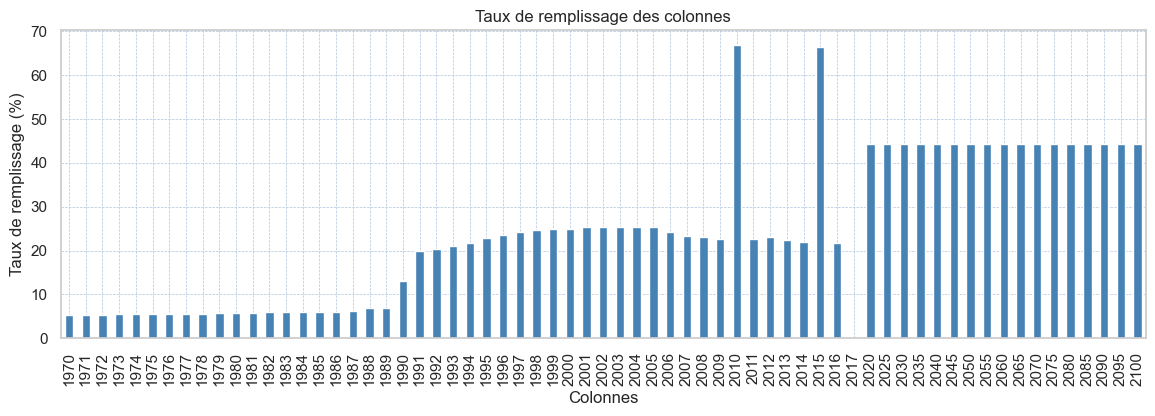

In [729]:
fill_rates_plot(data_cut, ignore_columns=["Country Name","Country Code","Indicator Name","Indicator Code"])

Les années qui contiennent le plus de données se trouvent entre 1991 et 2016 pour les indicateurs séléctionnés. Une hausse significative autours des années 2000 et une lègere baisse après 2011. Nous allons nous interesser aux années à partir desquelles internet est démocratisé grace à au haut débit, soit 2005 environ. l'année 2016 contient moins de données nous nous arreterons donc à 2015. 

In [730]:
# Liste des colonnes à conserver
date_filter = ['Country Code', 'Country Name', 'Indicator Code', 'Indicator Name'] + [str(année) for année in range(2005, 2016)]

# Filtrage du DataFrame pour ne garder que les colonnes spécifiées
data_cut = data_cut.filter(items=date_filter)

# Affichage du DataFrame filtré
data_cut.head(2)

Country Code Country Name     Indicator Code  \
1251          ARB   Arab World     NY.GNP.PCAP.CD   
1252          ARB   Arab World  NY.GNP.PCAP.PP.CD   

                                     Indicator Name          2005  \
1251     GNI per capita, Atlas method (current US$)   3497.483125   
1252  GNI per capita, PPP (current international $)  11369.476580   

              2006          2007          2008          2009          2010  \
1251   4112.095156   4730.939606   5546.406244   5640.075465   5913.744794   
1252  12356.841903  13132.708815  13824.485684  13852.502783  14284.023177   

              2011          2012          2013  2014  2015  
1251   6305.644064   7196.532736           NaN   NaN   NaN  
1252  14996.156034  15846.498202  16141.560252   NaN   NaN

- Compression des données

Voici quelques méthodes pour compresser les séries temporelles :

- Valeur la Plus Récente :
        Cela peut fournir la représentation la plus actuelle de l'état de l'indicateur. Mais si les données les plus récentes ne sont pas représentatives des années précédentes, cela peut donner une image inexacte. Utile si les données récentes sont plus pertinentes pour votre analyse.

- Moyenne :
        Permet d'obtenir une vue d'ensemble qui lisse les fluctuations annuelles. Mais peut masquer les tendances importantes ou les changements significatifs survenus au fil du temps. Bon pour les indicateurs relativement stables ou lorsqu'une vue d'ensemble est nécessaire.

- Médiane :
        Moins sensible aux valeurs aberrantes que la moyenne. Mais comme la moyenne, peut masquer certaines tendances. Utile pour les données avec des valeurs aberrantes extrêmes.

In [731]:
# Ajout de la colonne moyenne 2005-2015
#data_cut['Mean Value 2005-2015'] = data_cut.loc[:, '2005':'2015'].mean(axis=1).round(0)

# supprimer les années
#data_cut = data_cut.filter(items=['Country Code', 'Country Name', 'Indicator Code', 'Indicator Name', 'Mean Value 2005-2015'])

# Afficher les résultats  
#data_cut.head(2)

Nous appliquons la fonction fill_missing_with_last_known créée plus tôt afin de conserver les 2 dates les plus complètes et complèter leurs valeurs manquantes par les dernières données connues.


In [732]:
# Appliquer la fonction aux 2 colonnes conservées
data_cut_filled = fill_missing_with_last_known(data_cut, start_year=2005, end_year=2010)
data_cut_filled = fill_missing_with_last_known(data_cut, start_year=2010, end_year=2015)

In [733]:
# supprimer les années inutiles
data_cut = data_cut_filled.filter(items=['Country Code', 'Country Name', 'Indicator Code', 'Indicator Name', '2010','2015'])# Afficher les premières lignes du DataFrame pour vérifier le résultat
data_cut.head()

Country Code Country Name     Indicator Code  \
1251          ARB   Arab World     NY.GNP.PCAP.CD   
1252          ARB   Arab World  NY.GNP.PCAP.PP.CD   
1375          ARB   Arab World     IT.NET.USER.P2   
2084          ARB   Arab World     IT.CMP.PCMP.P2   
2103          ARB   Arab World   LO.PIAAC.TEC.OPT   

                                         Indicator Name          2010  \
1251         GNI per capita, Atlas method (current US$)   5913.744794   
1252      GNI per capita, PPP (current international $)  14284.023177   
1375                    Internet users (per 100 people)     26.747251   
2084                Personal computers (per 100 people)      6.676681   
2103  PIAAC: Adults by proficiency level in problem ...           NaN   

              2015  
1251   7196.532736  
1252  16141.560252  
1375     36.868602  
2084      6.676681  
2103           NaN

Nous avons desormais la colonne 2010 complétée avec les valeurs des 5 années précédentes si besoin, et la colonne 2015 complétée de la même manière avec les données des 5 années précédentes. 

#### <font color='skyblue'> Sélection des pays pour l'analyse </font>


- Vue d'ensemble

Présence de 241 entrées dans country pour 197 pays officiels. Nous nous intéressons à 3 informations pour faire le tri : les pays, les régions, et les revenus.

In [734]:
# Obtenir les éléments uniques de la colonne
region_list = country_df['Region'].unique()

# Affichage des éléments uniques
print(len(region_list))
print(region_list)

8
['Latin America & Caribbean' 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' nan 'Middle East & North Africa'
 'East Asia & Pacific' 'North America']


- Suppression des groupes de pays

In [735]:
# Sélectionner les lignes où la colonne 'Region' est vide ou nulle
region_nan = country_df[country_df['Region'].isna()]

# Afficher ces lignes
print(len(region_nan))
print(region_nan)

27
    Country Code                                      Short Name  \
5            ARB                                      Arab World   
57           EAP           East Asia & Pacific (developing only)   
58           EAS         East Asia & Pacific (all income levels)   
59           ECA         Europe & Central Asia (developing only)   
60           ECS       Europe & Central Asia (all income levels)   
63           EMU                                       Euro area   
68           EUU                                  European Union   
78           GIB                                       Gibraltar   
89           HIC                                     High income   
92           HPC          Heavily indebted poor countries (HIPC)   
116          LAC     Latin America & Caribbean (developing only)   
122          LCN   Latin America & Caribbean (all income levels)   
123          LDC    Least developed countries: UN classification   
124          LIC                             

27 individus ne correspondent pas à des pays mais à des groupements de pays, nous pouvons les supprimer. Nous perdons dans l'opération Gibraltar et Nauru.

In [736]:
# Supprimer les lignes où la colonne 'Region' est nulle
country_cut = country_df.dropna(subset=['Region'])

# Afficher le DataFrame après suppression
print(len(country_cut))


214


- Suppression des pays aux revenus très faibles

In [737]:
# Obtenir les éléments uniques de la colonne
income_list = country_cut['Income Group'].unique()

# Compter le nombre de lignes pour chaque élément unique dans la colonne 'Income Group'
income_list_count = country_cut['Income Group'].value_counts()

# Affichage des éléments uniques
print(len(income_list))
print(income_list)
print(income_list_count)

5
['High income: nonOECD' 'Low income' 'Upper middle income'
 'Lower middle income' 'High income: OECD']
Income Group
Upper middle income     55
Lower middle income     50
High income: nonOECD    44
Low income              34
High income: OECD       31
Name: count, dtype: int64


In [738]:
# Supprimer les lignes où la colonne 'Income Group' est égale à 'Low income'
country_cut = country_cut[country_cut['Income Group'] != 'Low income']

# Afficher le DataFrame après la suppression
print(len(country_cut))

180


In [739]:
# Obtenir les éléments uniques de la colonne
country_list = country_cut['Short Name'].unique()

# Affichage des éléments uniques
print(len(country_list))
print(country_list)

180
['Aruba' 'Angola' 'Albania' 'Andorra' 'United Arab Emirates' 'Argentina'
 'Armenia' 'American Samoa' 'Antigua and Barbuda' 'Australia' 'Austria'
 'Azerbaijan' 'Belgium' 'Bulgaria' 'Bahrain' 'The Bahamas'
 'Bosnia and Herzegovina' 'Belarus' 'Belize' 'Bermuda' 'Bolivia' 'Brazil'
 'Barbados' 'Brunei' 'Bhutan' 'Botswana' 'Canada' 'Switzerland'
 'Channel Islands' 'Chile' 'China' "Côte d'Ivoire" 'Cameroon' 'Congo'
 'Colombia' 'Cabo Verde' 'Costa Rica' 'Cuba' 'Curaçao' 'Cayman Islands'
 'Cyprus' 'Czech Republic' 'Germany' 'Djibouti' 'Dominica' 'Denmark'
 'Dominican Republic' 'Algeria' 'Ecuador' 'Egypt' 'Spain' 'Estonia'
 'Finland' 'Fiji' 'France' 'Faeroe Islands' 'Micronesia' 'Gabon'
 'United Kingdom' 'Georgia' 'Ghana' 'Equatorial Guinea' 'Greece' 'Grenada'
 'Greenland' 'Guatemala' 'Guam' 'Guyana' 'Hong Kong SAR, China' 'Honduras'
 'Croatia' 'Hungary' 'Indonesia' 'Isle of Man' 'India' 'Ireland' 'Iran'
 'Iraq' 'Iceland' 'Israel' 'Italy' 'Jamaica' 'Jordan' 'Japan' 'Kazakhstan'
 'Kyrgyz Repu

- Modification du dataframe pays

In [740]:
country_cut = country_cut.filter(items=['Country Code', 'Short Name', 'Region'])

In [741]:
country_cut

Country Code            Short Name                      Region
0            ABW                 Aruba   Latin America & Caribbean
2            AGO                Angola          Sub-Saharan Africa
3            ALB               Albania       Europe & Central Asia
4            AND               Andorra       Europe & Central Asia
6            ARE  United Arab Emirates  Middle East & North Africa
..           ...                   ...                         ...
235          WSM                 Samoa         East Asia & Pacific
236          XKX                Kosovo       Europe & Central Asia
237          YEM                 Yemen  Middle East & North Africa
238          ZAF          South Africa          Sub-Saharan Africa
239          ZMB                Zambia          Sub-Saharan Africa

[180 rows x 3 columns]

Nous obtenons une liste de 180 individus, en majorité des pays, mais il reste certaines principautés et iles dépendantes qui seront éliminés par leur faible population lors de notre analyse.

- Modification du dataframe principal

In [742]:
# Filtrer le DataFrame pour ne conserver que les lignes dont la valeur de "Country Code" est dans country_cut
data_cut = data_cut[data_cut['Country Code'].isin(country_cut['Country Code'])]

In [743]:
# Fusionner data_cut avec la colonne 'Region' de country_cut en utilisant 'Country Code' comme clé
data_cut = pd.merge(data_cut, country_cut[['Country Code', 'Region']], on='Country Code', how='left')

# Afficher le DataFrame résultant
data_info(data_cut)

nombre de valeurs non nulles  nombre de valeurs uniques  \
colonne                                                                   
Country Code                            5040                        180   
Country Name                            5040                        180   
Indicator Code                          5040                         28   
Indicator Name                          5040                         28   
2010                                    3718                       1031   
2015                                    3777                       1150   
Region                                  5040                          7   

               type de donnée  nombre de valeurs nulles  \
colonne                                                   
Country Code           object                         0   
Country Name           object                         0   
Indicator Code         object                         0   
Indicator Name         object                         0   
2010                  float64                      1322   
2015                  float64                      1263   
Region                 object                         0   

                pourcentage de valeurs nulles  
colonne                                        
Country Code                             0.00  
Country Name                             0.00  
Indicator Code                           0.00  
Indicator Name                           0.00  
2010                                    26.23  
2015                                    25.06  
Region                                   0.00

### <font color='aqua'> 2. Sélection des Indicateurs </font>

Nous avons préselectionné 20 indicateurs, une période temporelle de 10 ans et une liste de 180 pays pour notre analyse. Pour clarifier celle-ci, nous allons choisir 5 indicateurs les plus pertinents sur les mêmes critères que précédemment, à savoir le taux de remplissage des données et la pertinence de l'indicateur.

#### <font color='skyblue'> Transformation du dataframe </font>

- Pivot du dataframe

Pour plus de clarté, nous faisons en sorte d'obtenir un dataframe avec 1 pays par ligne, et les indicateurs en colonnes.

In [744]:
data_cut.head(5)

Country Code Country Name     Indicator Code  \
0          ALB      Albania     NY.GNP.PCAP.CD   
1          ALB      Albania  NY.GNP.PCAP.PP.CD   
2          ALB      Albania     IT.NET.USER.P2   
3          ALB      Albania     IT.CMP.PCMP.P2   
4          ALB      Albania   LO.PIAAC.TEC.OPT   

                                      Indicator Name         2010  \
0         GNI per capita, Atlas method (current US$)  4360.000000   
1      GNI per capita, PPP (current international $)  9550.000000   
2                    Internet users (per 100 people)    45.000000   
3                Personal computers (per 100 people)     4.593538   
4  PIAAC: Adults by proficiency level in problem ...          NaN   

           2015                 Region  
0   4290.000000  Europe & Central Asia  
1  11340.000000  Europe & Central Asia  
2     63.252933  Europe & Central Asia  
3      4.593538  Europe & Central Asia  
4           NaN  Europe & Central Asia

In [745]:
# Pivoter le DataFrame pour obtenir un format où chaque ligne est un pays et chaque colonne un indicateur
data_pivot_2010 = data_cut.pivot_table(index=['Country Code', 'Country Name', 'Region'],
                          columns='Indicator Name',
                          values='2010',
                          aggfunc='first').reset_index()

# Réorganiser les colonnes pour une meilleure lisibilité
data_pivot_2010.columns.name = None
data_pivot_2010 = data_pivot_2010.reset_index(drop=True)

# Afficher le DataFrame restructuré
data_pivot_2010.head(2)

Country Code Country Name                     Region  \
0          ABW        Aruba  Latin America & Caribbean   
1          AGO       Angola         Sub-Saharan Africa   

   GNI per capita, Atlas method (current US$)  \
0                                         NaN   
1                                      3240.0   

   GNI per capita, PPP (current international $)  \
0                                            NaN   
1                                         5210.0   

   Internet users (per 100 people)  Personal computers (per 100 people)  \
0                             62.0                             9.917683   
1                              2.8                             0.646019   

   Population, total  Unemployment, female (% of female labor force)  \
0           101669.0                                             NaN   
1         23369131.0                                             6.7   

   Unemployment, male (% of male labor force)  \
0                                         NaN   
1                                         5.8   

   Unemployment, total (% of total labor force)  \
0                                           NaN   
1                                           6.2   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Incomplete Primary. Female  \
0                                               0.01                                                                                        
1                                                NaN                                                                                        

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Incomplete Primary. Male  \
0                                               0.02                                                                                      
1                                                NaN                                                                                      

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Incomplete Primary. Total  \
0                                               0.02                                                                                       
1                                                NaN                                                                                       

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Lower Secondary. Female  \
0                                               0.33                                                                                     
1                                                NaN                                                                                     

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Lower Secondary. Male  \
0                                               0.41                                                                                   
1                                                NaN                                                                                   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Lower Secondary. Total  \
0                                               0.37                                                                                    
1                                                NaN                                                                                    

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. No Education. Female  \
0                                               0.02                                                                                  
1       

In [746]:
# Pivoter le DataFrame pour obtenir un format où chaque ligne est un pays et chaque colonne un indicateur
data_pivot_2015 = data_cut.pivot_table(index=['Country Code', 'Country Name', 'Region'],
                          columns='Indicator Name',
                          values='2015',
                          aggfunc='first').reset_index()

# Réorganiser les colonnes pour une meilleure lisibilité
data_pivot_2015.columns.name = None
data_pivot_2015 = data_pivot_2015.reset_index(drop=True)

# Afficher le DataFrame restructuré
data_pivot_2015.head(2)

Country Code Country Name                     Region  \
0          ABW        Aruba  Latin America & Caribbean   
1          AGO       Angola         Sub-Saharan Africa   

   GNI per capita, Atlas method (current US$)  \
0                                         NaN   
1                                      4040.0   

   GNI per capita, PPP (current international $)  \
0                                            NaN   
1                                         6270.0   

   Internet users (per 100 people)  \
0                        88.661227   
1                        12.400000   

   PIAAC: Adults by proficiency level in problem solving in technology-rich environments (%). Opted out of computer-based assessment  \
0                                                NaN                                                                                   
1                                                NaN                                                                                   

   PIAAC: Young adults by proficiency level in problem solving in technology-rich environments (%). Opted out of computer-based assessment  \
0                                                NaN                                                                                         
1                                                NaN                                                                                         

   Personal computers (per 100 people)  Population, total  \
0                             9.917683           104341.0   
1                             0.646019         27859305.0   

   Unemployment, female (% of female labor force)  \
0                                             NaN   
1                                             6.7   

   Unemployment, male (% of male labor force)  \
0                                         NaN   
1                                         5.7   

   Unemployment, total (% of total labor force)  \
0                                           NaN   
1                                           6.2   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Incomplete Primary. Female  \
0                                                0.0                                                                                        
1                                                NaN                                                                                        

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Incomplete Primary. Male  \
0                                               0.01                                                                                      
1                                                NaN                                                                                      

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Incomplete Primary. Total  \
0                                                0.0                                                                                       
1                                                NaN                                                                                       

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Lower Secondary. Female  \
0                                               0.32                                                                                     
1                                                NaN                                                                                     

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Lower Secondary. Male  \
0                                               0.42                                                           

- Filtrage quantitatif des données

Nous supprimons les indicateurs faiblement remplis.

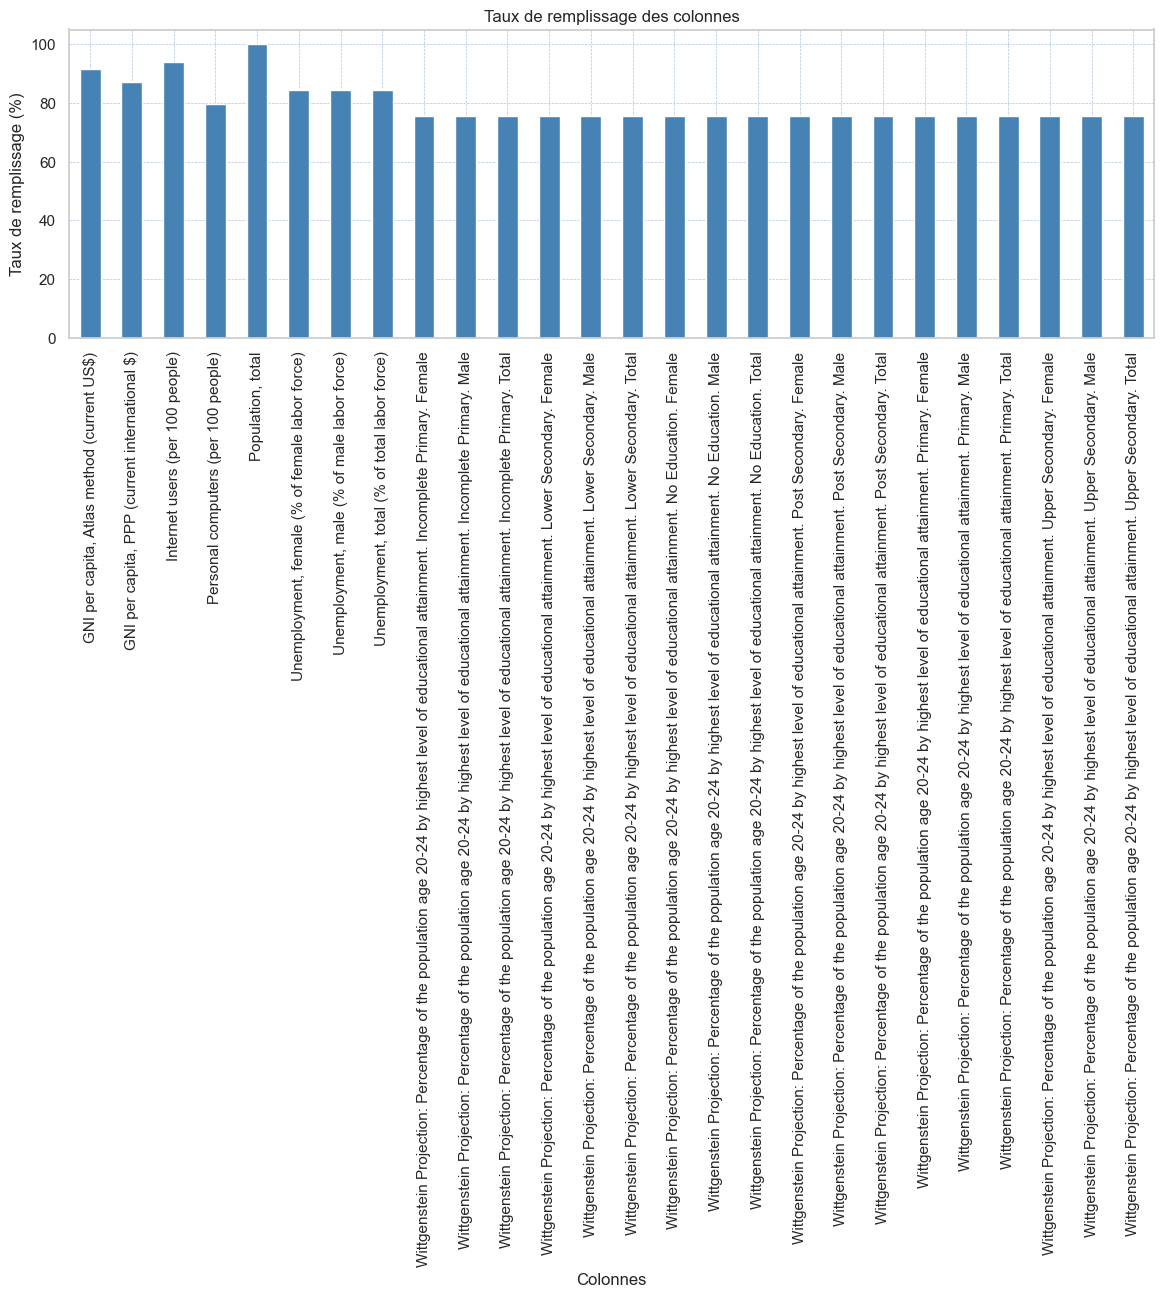

In [747]:
fill_rates_plot(data_pivot_2010, ignore_columns=["Country Name","Country Code","Region"])

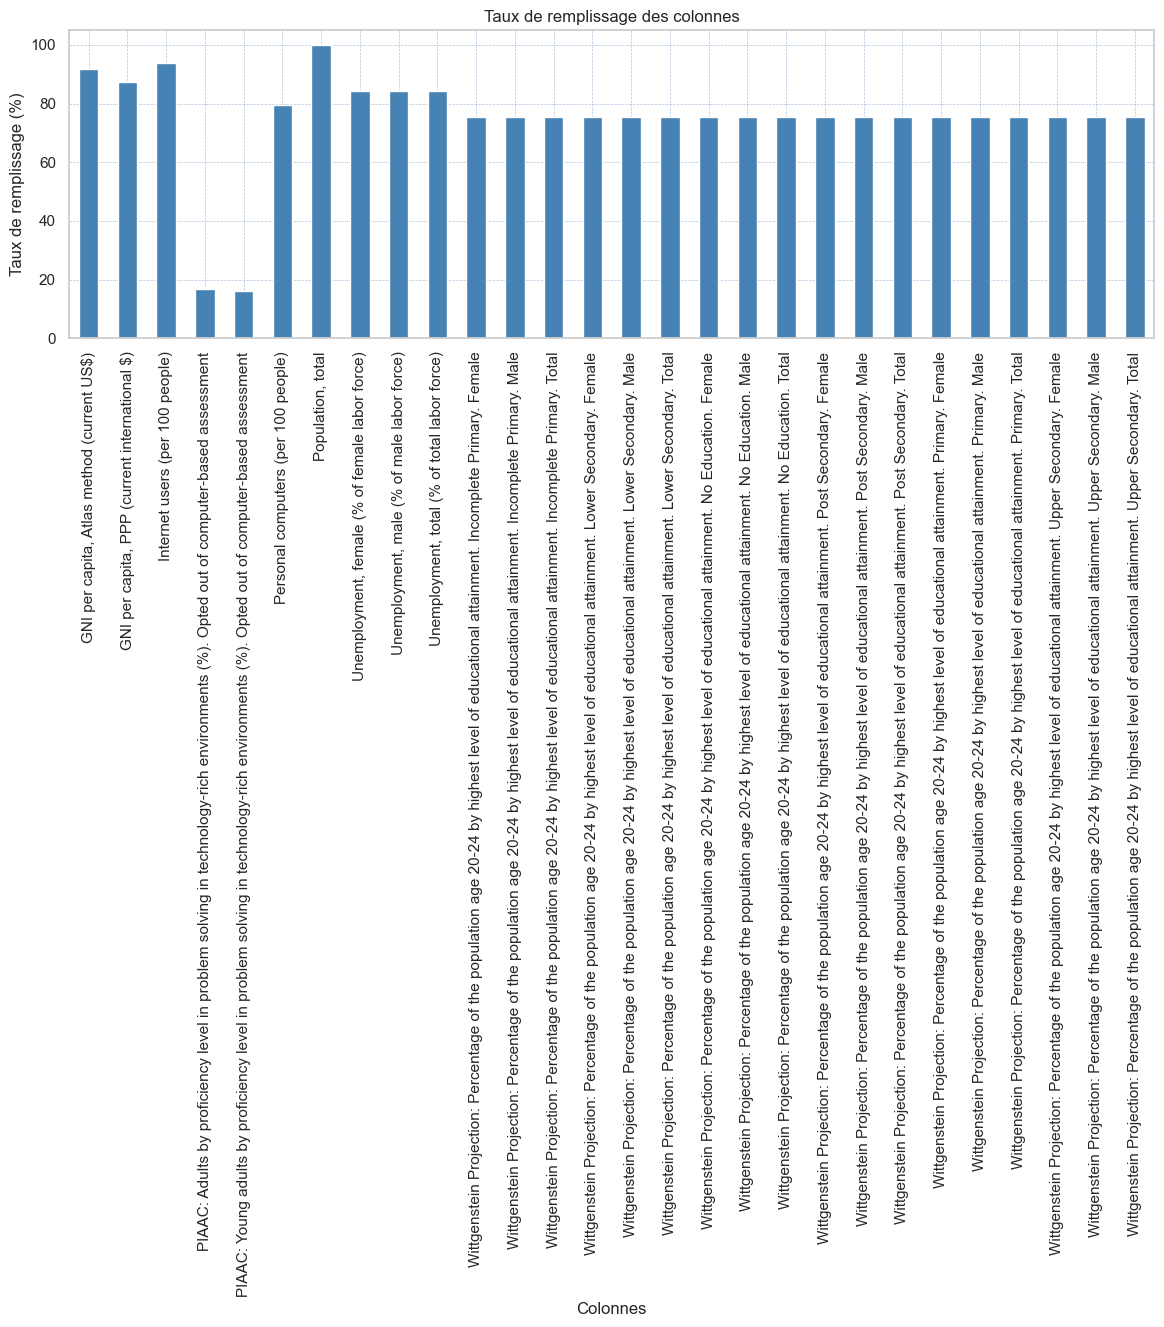

In [748]:
fill_rates_plot(data_pivot_2015, ignore_columns=["Country Name","Country Code","Region"])

Les indicateurs dont nous disposons peu de données seront automatiquement écartés, aussi un choix sera fait parmi les indicateurs qui mesurent les mêmes critères (GNI et GDP par exemple).

- Filtrage qualitatif

<Axes: >

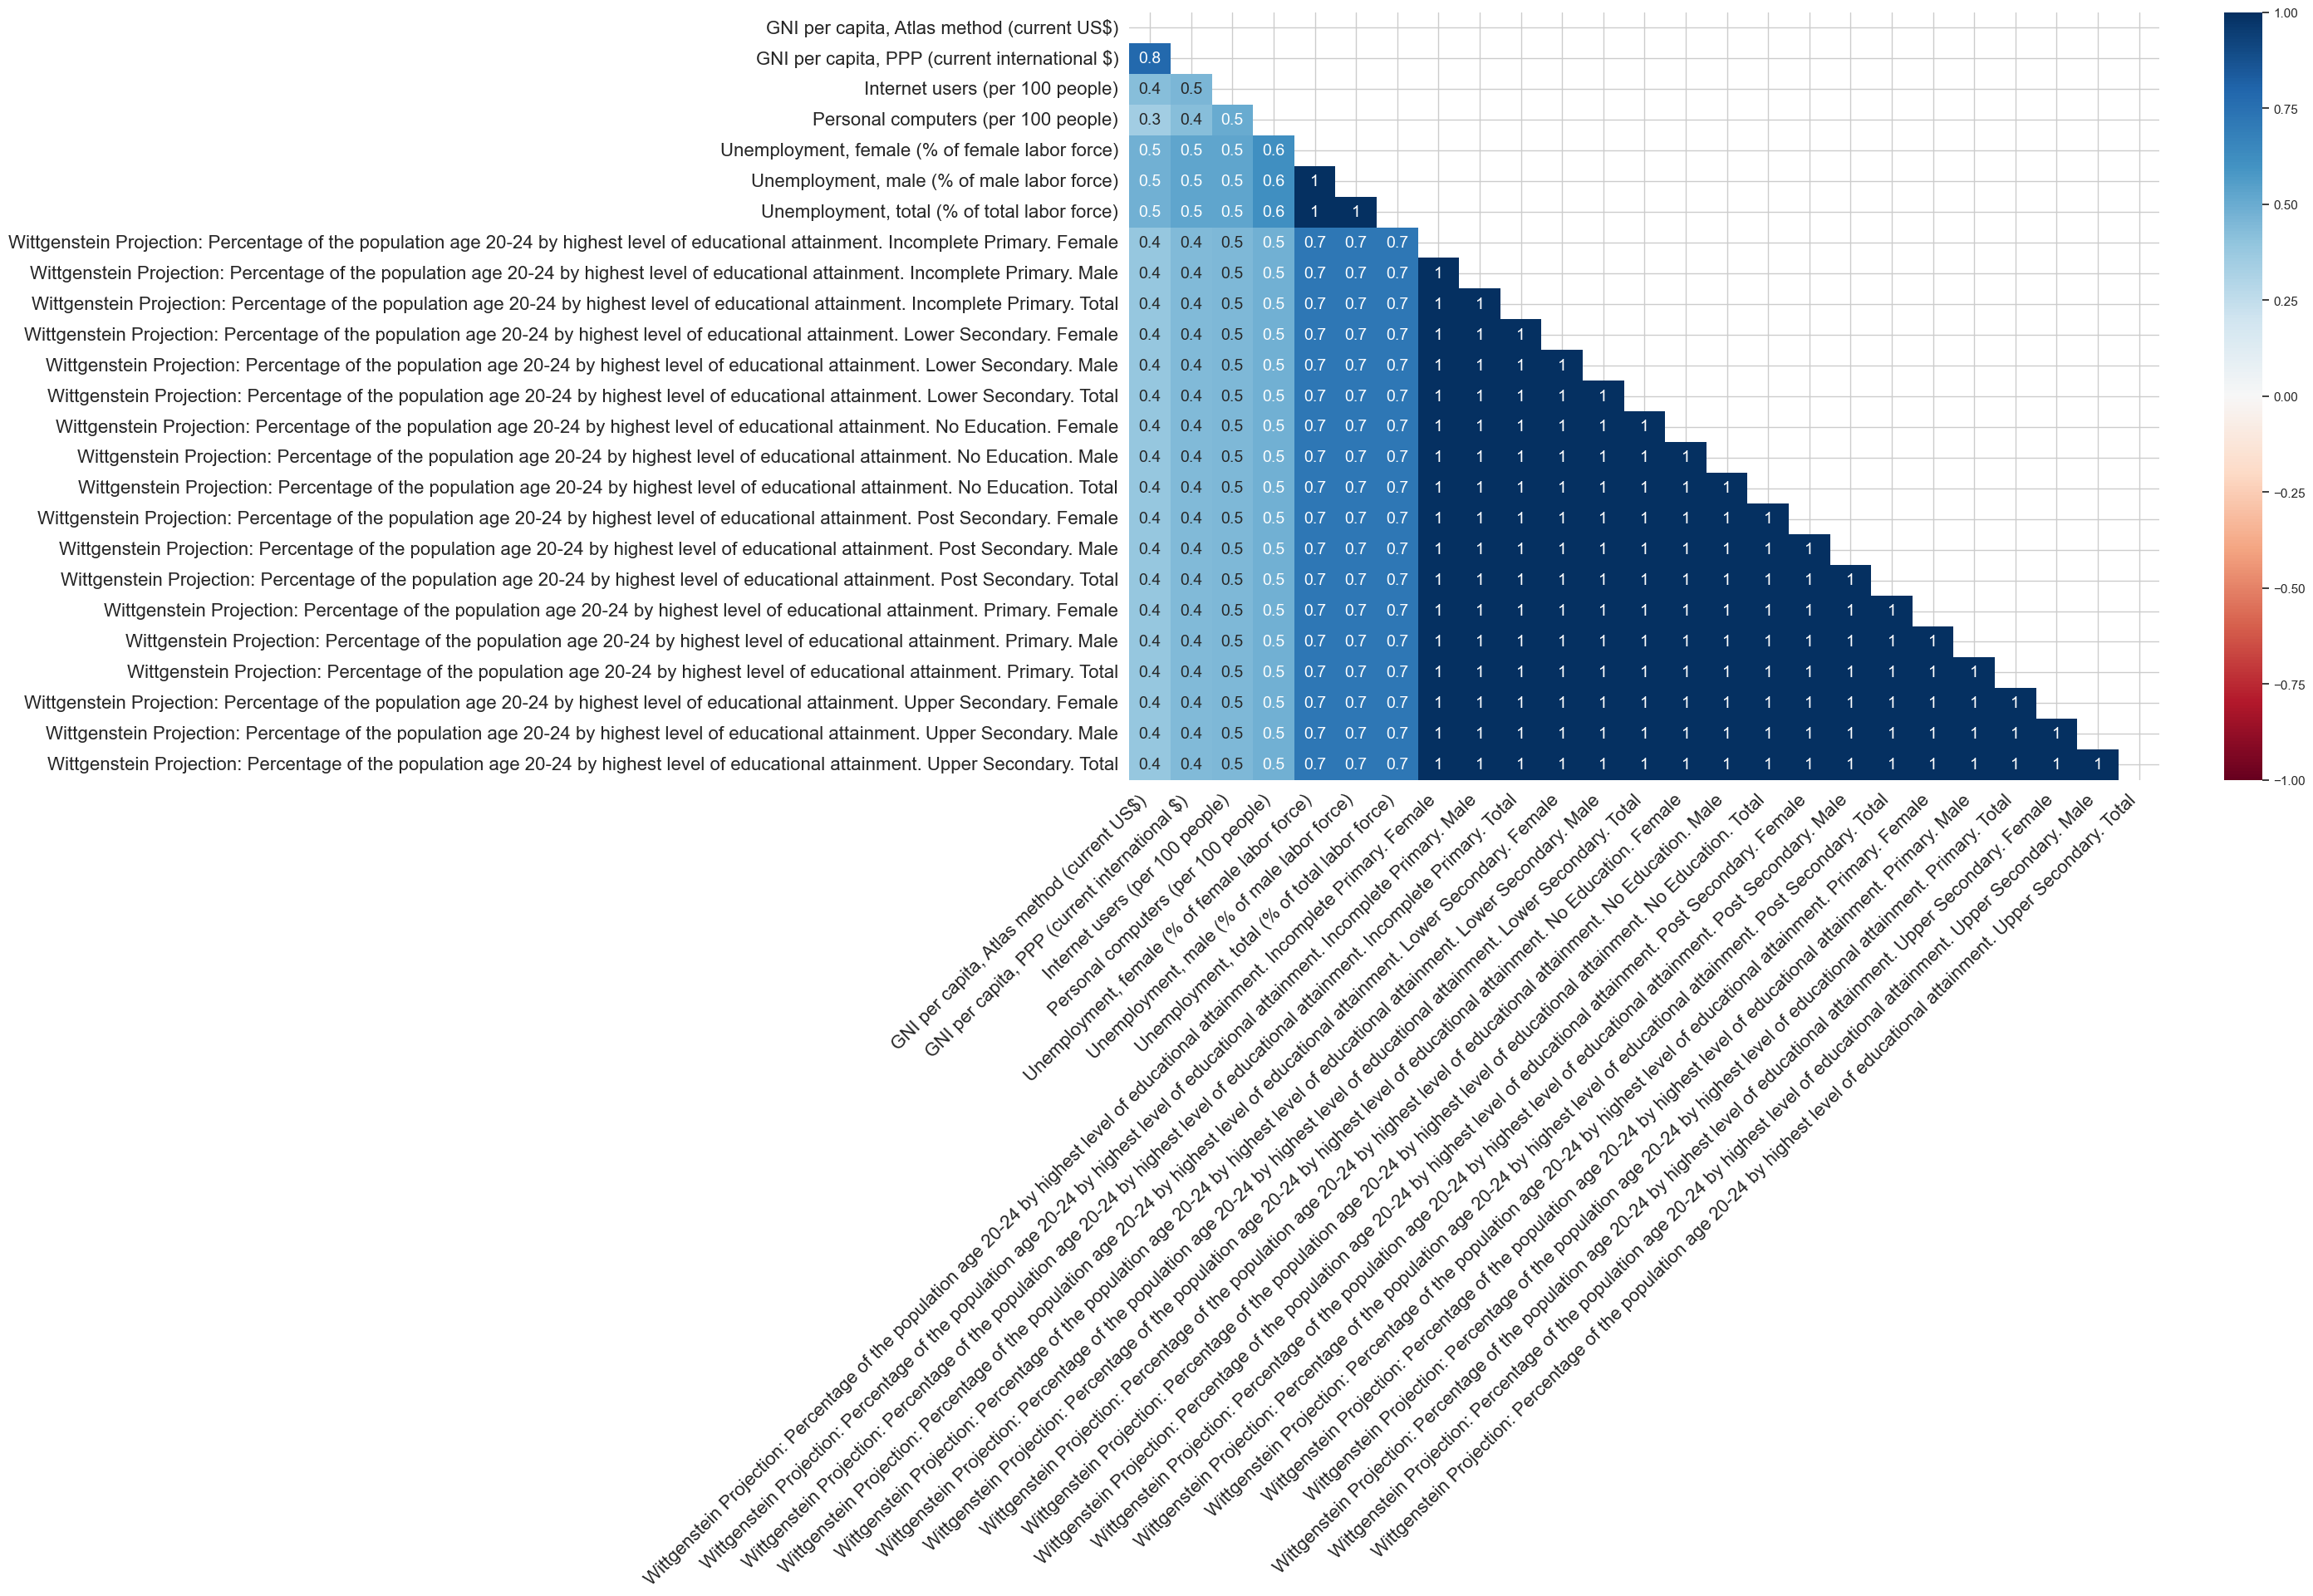

In [749]:
msno.heatmap(data_pivot_2010)

<Axes: >

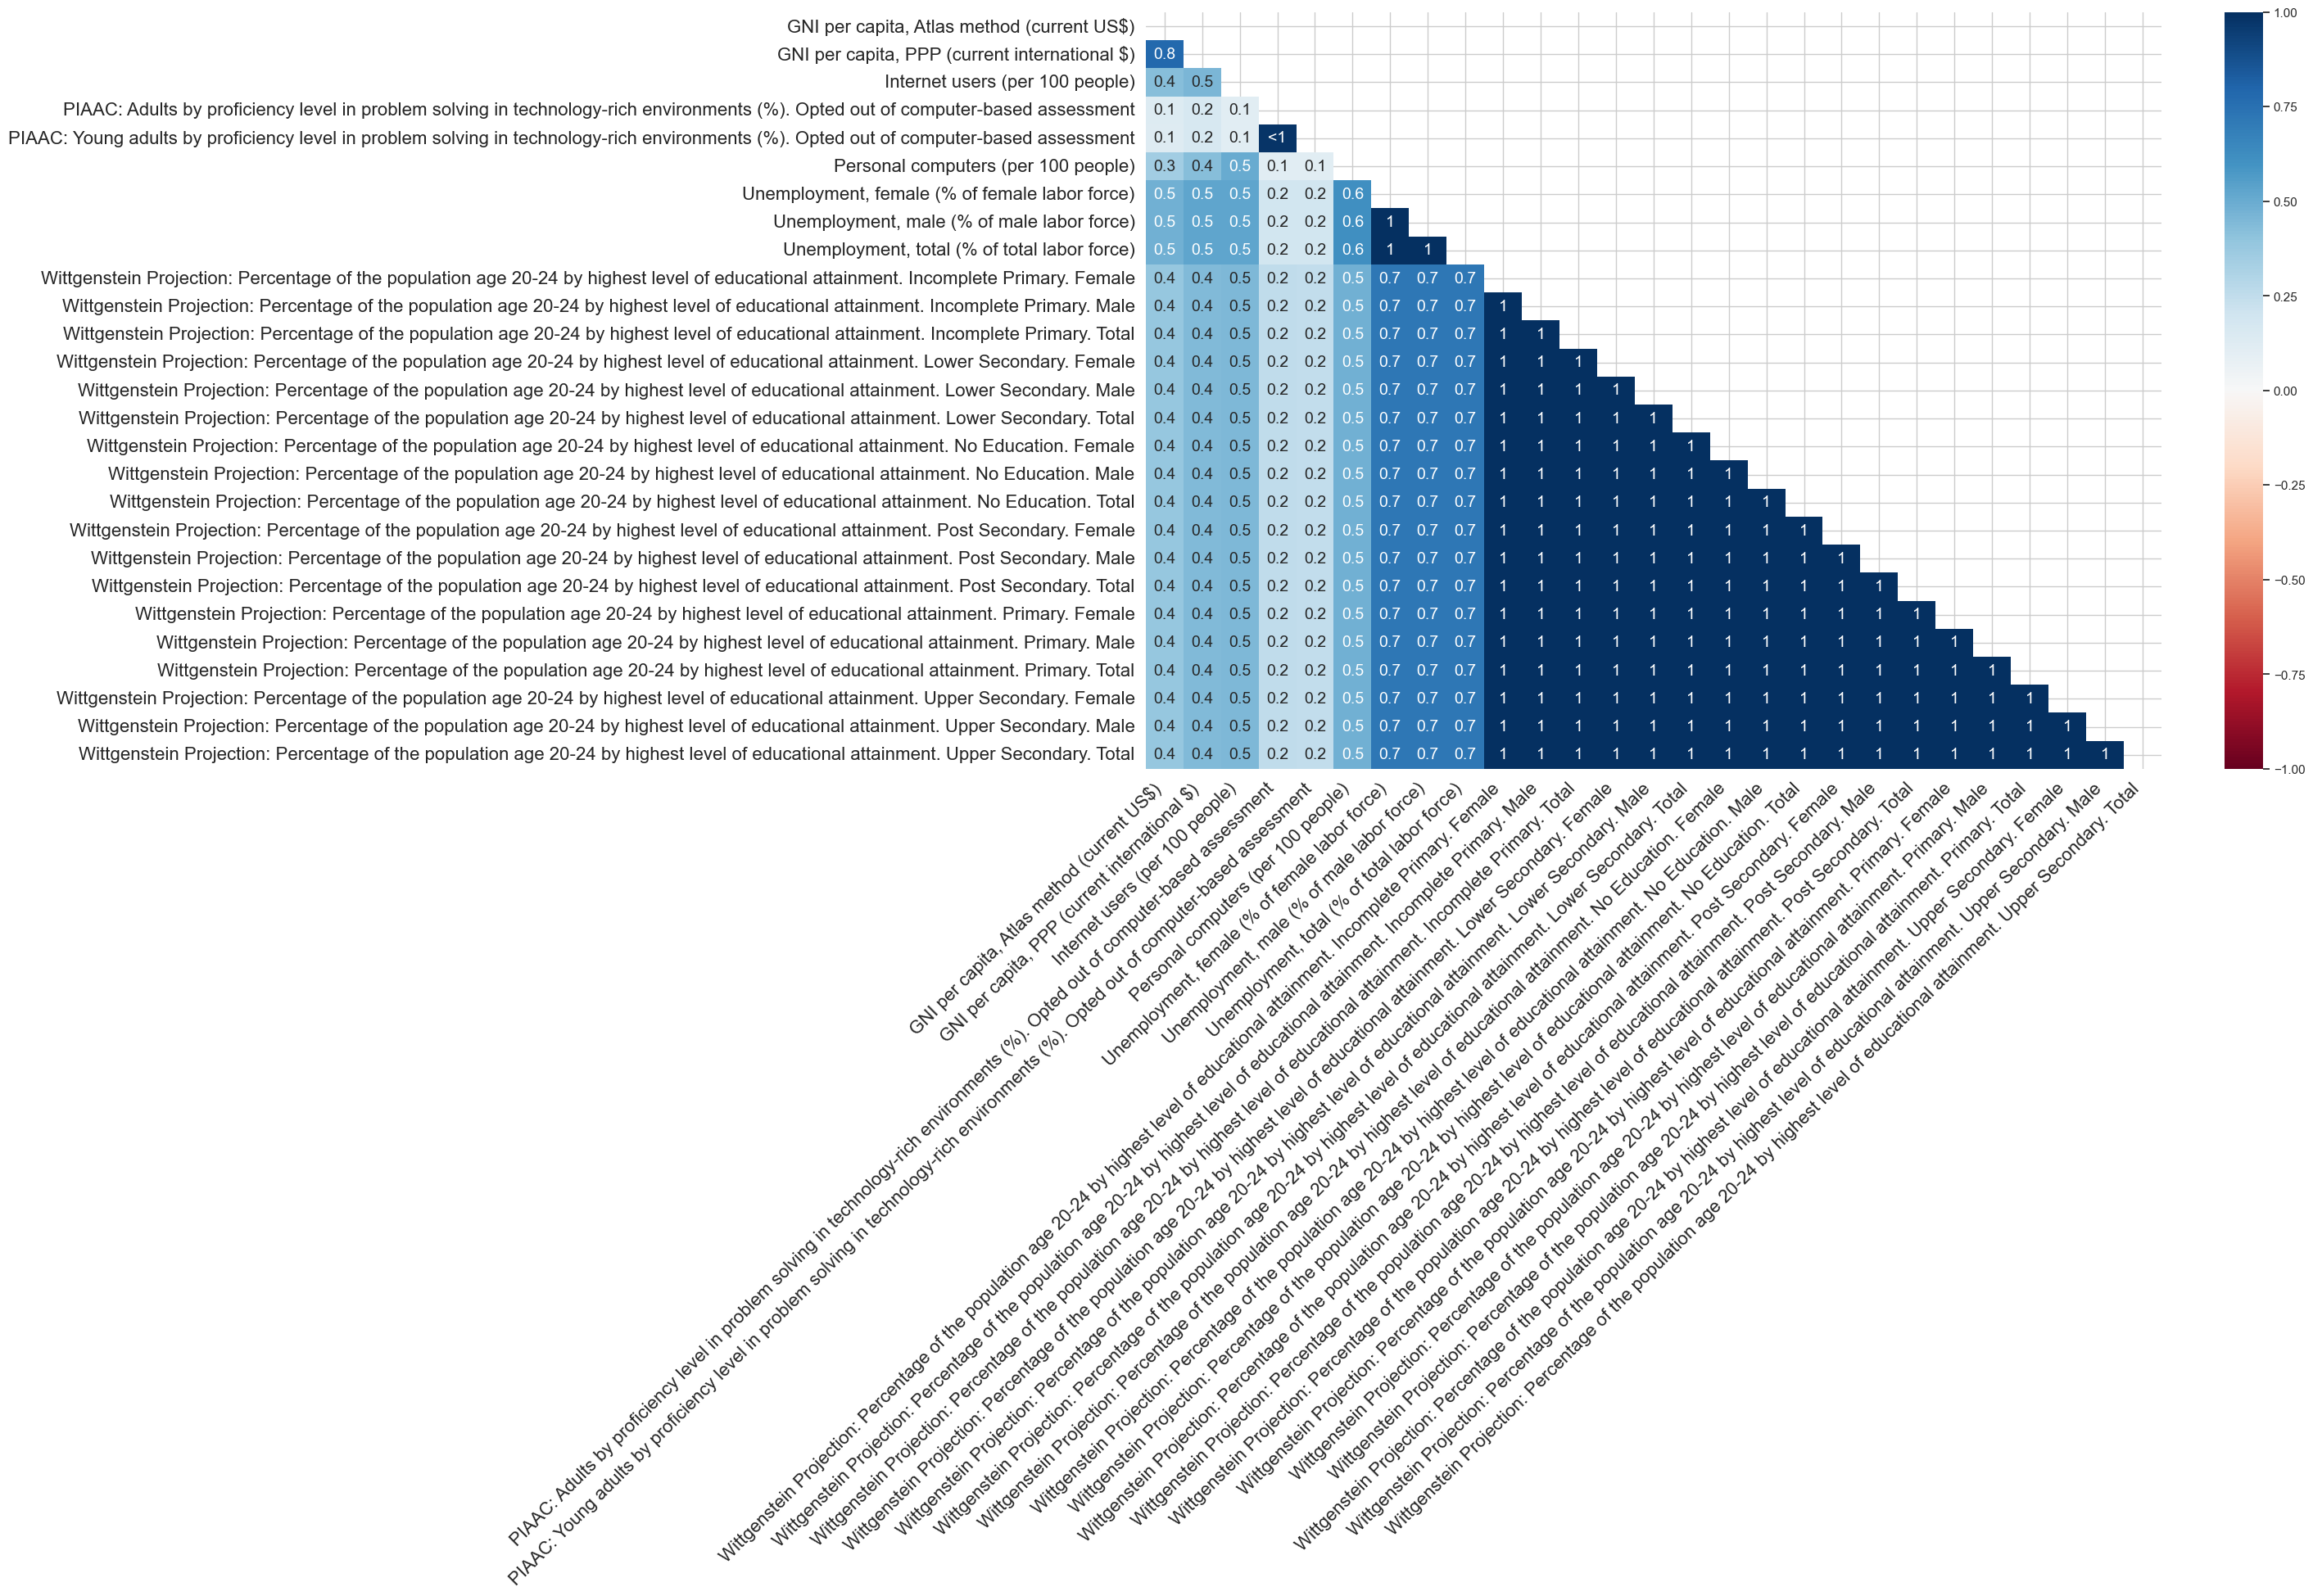

In [750]:
msno.heatmap(data_pivot_2015)

Nous sélectionnons les indicateurs non discriminants, ou qui fournissent les mêmes informations que d'autres.

Notre choix se porte sur 5 indicateurs : 
- PNB par habitant
- Taux d'accès à internet
- Niveau d'éducation des jeunes
- Population totale
- Taux de chomage 

- Modification du dataframe principal

In [751]:
data_2010 = data_pivot_2010[['Country Name',
                        'Region',
                        'Population, total',
                        'GNI per capita, Atlas method (current US$)',
                        'Unemployment, total (% of total labor force)',
                        'Internet users (per 100 people)',
                        'Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total']]

In [752]:
data_2010.head(2)

Country Name                     Region  Population, total  \
0        Aruba  Latin America & Caribbean           101669.0   
1       Angola         Sub-Saharan Africa         23369131.0   

   GNI per capita, Atlas method (current US$)  \
0                                         NaN   
1                                      3240.0   

   Unemployment, total (% of total labor force)  \
0                                           NaN   
1                                           6.2   

   Internet users (per 100 people)  \
0                             62.0   
1                              2.8   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total  
0                                               0.07                                                                                  
1                                                NaN

In [753]:
data_2015 = data_pivot_2015[['Country Name',
                        'Region',
                        'Population, total',
                        'GNI per capita, Atlas method (current US$)',
                        'Unemployment, total (% of total labor force)',
                        'Internet users (per 100 people)',
                        'Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total']]

In [754]:
data_2015.head(2)

Country Name                     Region  Population, total  \
0        Aruba  Latin America & Caribbean           104341.0   
1       Angola         Sub-Saharan Africa         27859305.0   

   GNI per capita, Atlas method (current US$)  \
0                                         NaN   
1                                      4040.0   

   Unemployment, total (% of total labor force)  \
0                                           NaN   
1                                           6.2   

   Internet users (per 100 people)  \
0                        88.661227   
1                        12.400000   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total  
0                                               0.08                                                                                  
1                                                NaN

#### <font color='skyblue'> Traitement des valeurs aberrantes et des valeurs nulles</font>

Pour éviter de déséquilibrer le jeu de donnée, nous décidons de supprimer les pays dont la population est supérieure à 1 milliard, soit la Chine et l'Inde. En réalité ces 2 pays ont des marchés très difficiles à pénetrer, qu ce soit culturellement ou politiquement.

Aussi nous décidons de supprimer arbitrairement tous les pays dont la population est inférieure à 2 millions d'habitants, nous estimons que c'est un seuil trop faible pour lancer un produit. 

In [755]:
# Filtrer le DataFrame pour conserver uniquement les pays avec une population supérieure ou égale au seuil
data_2010 = data_2010[data_2010['Population, total'] >= 2100000]
data_2010 = data_2010[data_2010['Population, total'] <= 1000000000]
# Filtrer le DataFrame pour conserver uniquement les pays avec une population supérieure ou égale au seuil
data_2015 = data_2015[data_2015['Population, total'] >= 2100000]
data_2015 = data_2015[data_2015['Population, total'] <= 1000000000]

Enfin nous visualisons les pays dont les valeurs sont manquantes sur certains indicateurs.

In [756]:
# Filtrer pour afficher uniquement les lignes contenant au moins une valeur nulle
nulls_2010 = data_2010[data_2010.isnull().any(axis=1)]
nulls_2010

Country Name                      Region  Population, total  \
1              Angola          Sub-Saharan Africa         23369131.0   
92              Libya  Middle East & North Africa          6169140.0   
95          Sri Lanka                  South Asia         20119000.0   
113        Mauritania          Sub-Saharan Africa          3609543.0   
123              Oman  Middle East & North Africa          3041460.0   
129  Papua New Guinea         East Asia & Pacific          7108239.0   
147       South Sudan          Sub-Saharan Africa          9940929.0   
169        Uzbekistan       Europe & Central Asia         28562400.0   
177       Yemen, Rep.  Middle East & North Africa         23606779.0   

     GNI per capita, Atlas method (current US$)  \
1                                        3240.0   
92                                      12440.0   
95                                       2430.0   
113                                      1130.0   
123                                     18170.0   
129                                      1850.0   
147                                      1080.0   
169                                      1340.0   
177                                      1180.0   

     Unemployment, total (% of total labor force)  \
1                                        6.200000   
92                                      17.100000   
95                                       4.900000   
113                                     10.100000   
123                                     18.400000   
129                                      2.500000   
147                                           NaN   
169                                      9.100000   
177                                     17.799999   

     Internet users (per 100 people)  \
1                             2.8000   
92                           14.0000   
95                           12.0000   
113                           4.0000   
123                          35.8278   
129                           1.2800   
147                              NaN   
169                          15.9000   
177                          12.3500   

     Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total  
1                                                  NaN                                                                                  
92                                                 NaN                                                                                  
95                                                 NaN                                                                                  
113                                                NaN                                                                                  
123                                                NaN                                                                                  
129                                                NaN                                                                                  
147                                                NaN                                                                                  
169                                                NaN                                                                                  
177                                                NaN

In [757]:
# Filtrer pour afficher uniquement les lignes contenant au moins une valeur nulle
nulls_2015 = data_2015[data_2015.isnull().any(axis=1)]
nulls_2015 = nulls_2015['Country Name']
nulls_2015

1                Angola
25             Botswana
92                Libya
95            Sri Lanka
113          Mauritania
123                Oman
129    Papua New Guinea
147         South Sudan
169          Uzbekistan
177         Yemen, Rep.
Name: Country Name, dtype: object

Nous constatons qu'il s'agit pour la plupart de pays instables ce qui induit un manque de données nationales sur leurs populations. Nous prenons la décision de supprimer ces 10 pays.

In [758]:
# Supprimer les lignes contenant au moins une valeur nulle
data_2010 = data_2010.dropna()
data_2015 = data_2015.dropna()

data_info(data_2010)

nombre de valeurs non nulles  \
colonne                                                                            
Country Name                                                                  99   
Region                                                                        99   
Population, total                                                             99   
GNI per capita, Atlas method (current US$)                                    99   
Unemployment, total (% of total labor force)                                  99   
Internet users (per 100 people)                                               99   
Wittgenstein Projection: Percentage of the popu...                            99   

                                                    nombre de valeurs uniques  \
colonne                                                                         
Country Name                                                               99   
Region                                                                      7   
Population, total                                                          99   
GNI per capita, Atlas method (current US$)                                 94   
Unemployment, total (% of total labor force)                               75   
Internet users (per 100 people)                                            90   
Wittgenstein Projection: Percentage of the popu...                         35   

                                                   type de donnée  \
colonne                                                             
Country Name                                               object   
Region                                                     object   
Population, total                                         float64   
GNI per capita, Atlas method (current US$)                float64   
Unemployment, total (% of total labor force)              float64   
Internet users (per 100 people)                           float64   
Wittgenstein Projection: Percentage of the popu...        float64   

                                                    nombre de valeurs nulles  \
colonne                                                                        
Country Name                                                               0   
Region                                                                     0   
Population, total                                                          0   
GNI per capita, Atlas method (current US$)                                 0   
Unemployment, total (% of total labor force)                               0   
Internet users (per 100 people)                                            0   
Wittgenstein Projection: Percentage of the popu...                         0   

                                                    pourcentage de valeurs nulles  
colonne                                                                            
Country Name                                                                  0.0  
Region                                                                        0.0  
Population, total                                                             0.0  
GNI per capita, Atlas method (current US$)                                    0.0  
Unemployment, total (% of total labor force)                                  0.0  
Internet users (per 100 people)                                               0.0  
Wittgenstein Projection: Percentage of the popu...                            0.0

In [759]:
# Identifier les noms de pays uniques à chaque DataFrame
unique_to_2010 = set(data_2010['Country Name']) - set(data_2015['Country Name'])
unique_to_2015 = set(data_2015['Country Name']) - set(data_2010['Country Name'])

# Filtrer les DataFrames pour afficher ces lignes
unique_rows_2010 = data_2010[data_2010['Country Name'].isin(unique_to_2010)]
unique_rows_2015 = data_2015[data_2015['Country Name'].isin(unique_to_2015)]

# Afficher les résultats
unique_rows_2015

Country Name                      Region  Population, total  \
96       Lesotho          Sub-Saharan Africa          2174645.0   
136        Qatar  Middle East & North Africa          2481539.0   

     GNI per capita, Atlas method (current US$)  \
96                                       1320.0   
136                                     75660.0   

     Unemployment, total (% of total labor force)  \
96                                      26.799999   
136                                      0.200000   

     Internet users (per 100 people)  \
96                         25.000000   
136                        92.884826   

     Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total  
96                                                0.04                                                                                  
136                                               0.13

In [760]:
# Supprimer les lignes contenant au moins une valeur nulle
data_2015 = data_2015.dropna()

# Supprimer les lignes où 'Country Name' est 'Qatar' ou 'Lesotho'
data_2015 = data_2015[~data_2015['Country Name'].isin(['Qatar', 'Lesotho'])]

In [761]:
data_info(data_2015)

nombre de valeurs non nulles  \
colonne                                                                            
Country Name                                                                  99   
Region                                                                        99   
Population, total                                                             99   
GNI per capita, Atlas method (current US$)                                    99   
Unemployment, total (% of total labor force)                                  99   
Internet users (per 100 people)                                               99   
Wittgenstein Projection: Percentage of the popu...                            99   

                                                    nombre de valeurs uniques  \
colonne                                                                         
Country Name                                                               99   
Region                                                                      7   
Population, total                                                          99   
GNI per capita, Atlas method (current US$)                                 96   
Unemployment, total (% of total labor force)                               72   
Internet users (per 100 people)                                            99   
Wittgenstein Projection: Percentage of the popu...                         38   

                                                   type de donnée  \
colonne                                                             
Country Name                                               object   
Region                                                     object   
Population, total                                         float64   
GNI per capita, Atlas method (current US$)                float64   
Unemployment, total (% of total labor force)              float64   
Internet users (per 100 people)                           float64   
Wittgenstein Projection: Percentage of the popu...        float64   

                                                    nombre de valeurs nulles  \
colonne                                                                        
Country Name                                                               0   
Region                                                                     0   
Population, total                                                          0   
GNI per capita, Atlas method (current US$)                                 0   
Unemployment, total (% of total labor force)                               0   
Internet users (per 100 people)                                            0   
Wittgenstein Projection: Percentage of the popu...                         0   

                                                    pourcentage de valeurs nulles  
colonne                                                                            
Country Name                                                                  0.0  
Region                                                                        0.0  
Population, total                                                             0.0  
GNI per capita, Atlas method (current US$)                                    0.0  
Unemployment, total (% of total labor force)                                  0.0  
Internet users (per 100 people)                                               0.0  
Wittgenstein Projection: Percentage of the popu...                            0.0

In [762]:
data_2015.head()

Country Name                      Region  Population, total  \
2               Albania       Europe & Central Asia          2880703.0   
4  United Arab Emirates  Middle East & North Africa          9154302.0   
5             Argentina   Latin America & Caribbean         43417765.0   
6               Armenia       Europe & Central Asia          2916950.0   
9             Australia         East Asia & Pacific         23789338.0   

   GNI per capita, Atlas method (current US$)  \
2                                      4290.0   
4                                     42910.0   
5                                     12430.0   
6                                      4030.0   
9                                     60330.0   

   Unemployment, total (% of total labor force)  \
2                                     17.100000   
4                                      4.000000   
5                                      7.200000   
6                                     18.299999   
9                                      6.100000   

   Internet users (per 100 people)  \
2                        63.252933   
4                        90.500000   
5                        68.043064   
6                        59.102378   
9                        84.560519   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total  
2                                               0.05                                                                                  
4                                               0.10                                                                                  
5                                               0.06                                                                                  
6                                               0.16                                                                                  
9                                               0.27

Nous disposons finalement de 2 dataframes contenant 99 pays et 5 indicateurs. Il n'y a plus de valeurs aberrantes ou nulles. Un dataframe correspond à l'année 2010 et l'autre à 2015.

## <a name="C4"> Analyse exploratoire </a>


L'analyse exploratoire est une étape cruciale dans tout projet d'analyse de données, car elle permet de mieux comprendre les caractéristiques et les relations au sein de votre ensemble de données. Dans notre cas, l'analyse exploratoire sera effectuée sur un DataFrame contenant des indicateurs clés pour différents pays.

### <font color='aqua'> 1. Analyse univariée </font>

Cette phase se concentrera sur l'examen de chaque variable individuellement. L'objectif est de comprendre la distribution, la centralité (comme la moyenne ou la médiane), la dispersion (comme l'écart-type ou l'intervalle interquartile) et la présence de valeurs aberrantes pour chaque indicateur.

#### <font color='skyblue'> Population totale </font>

- Statistiques descriptives

In [763]:
# Statistiques descriptives
population_stats_2010 = data_2010['Population, total'].describe()
population_stats_2015 = data_2015['Population, total'].describe()
print("Statistiques population 2010 : ",population_stats_2010,"Statistiques population 2015 : ",population_stats_2015)

Statistiques population 2010 :  count    9.900000e+01
mean     3.407121e+07
std      5.253569e+07
min      2.173170e+06
25%      5.419664e+06
50%      1.089559e+07
75%      3.708022e+07
max      3.093482e+08
Name: Population, total, dtype: float64 Statistiques population 2015 :  count    9.900000e+01
mean     3.605982e+07
std      5.555297e+07
min      2.425561e+06
25%      5.767481e+06
50%      1.127366e+07
75%      3.925967e+07
max      3.208966e+08
Name: Population, total, dtype: float64


<Figure size 800x600 with 0 Axes>

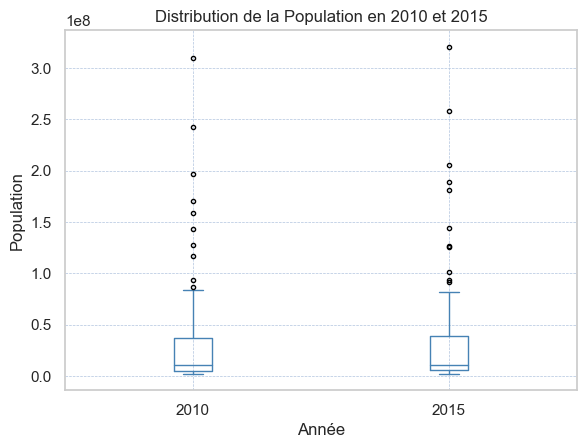

In [764]:
# Préparer les données pour le boxplot
data_2015['Year'] = '2015'  # Ajouter une colonne pour indiquer l'année
data_2010['Year'] = '2010'  # De même pour data_2010

# Concaténer les deux DataFrames en un seul
combined_population = pd.concat([data_2015[['Population, total', 'Year']], data_2010[['Population, total', 'Year']]])

# Créer le boxplot
plt.figure(figsize=(8, 6))
combined_population.boxplot(by='Year', column=['Population, total'], color='steelblue', flierprops=dict(marker='.'))
plt.title('Distribution de la Population en 2010 et 2015')
plt.suptitle('')  # Supprimer le titre supplémentaire
plt.ylabel('Population')
plt.xlabel('Année')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')

plt.show()

- Distribution par pays

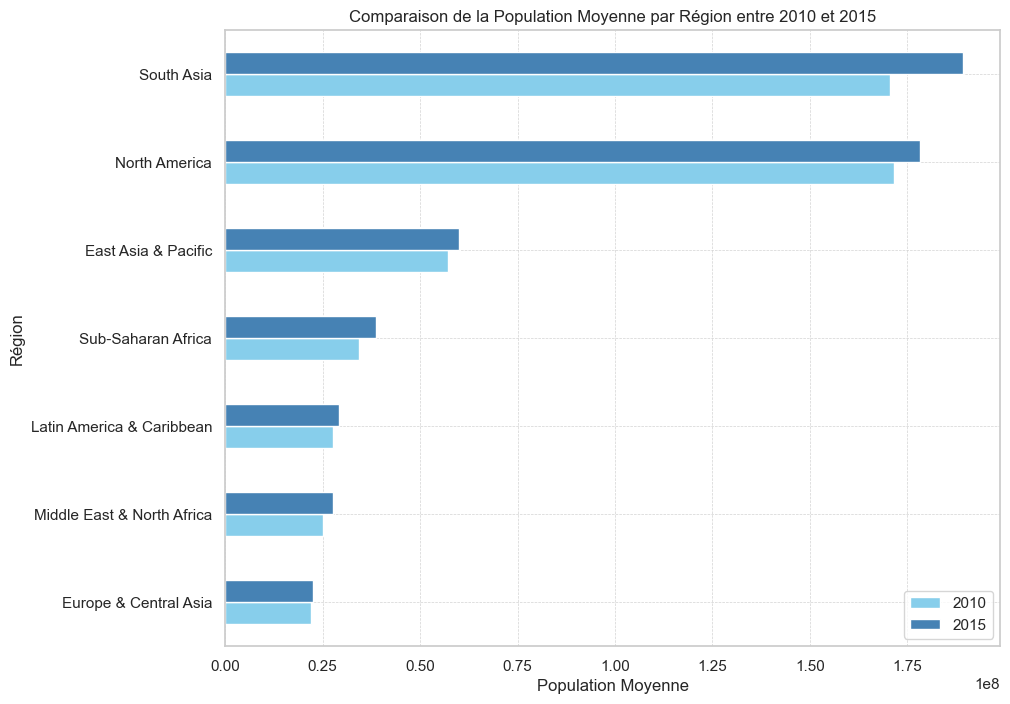

In [765]:
# Calculer la population moyenne par région pour 2010
population_region_2010 = data_2010.groupby('Region')['Population, total'].mean()

# Calculer la population moyenne par région pour 2015
population_region_2015 = data_2015.groupby('Region')['Population, total'].mean()

# Fusionner les deux séries en un DataFrame
population_comparison = pd.DataFrame({'2010': population_region_2010, '2015': population_region_2015})

# Trier le DataFrame pour la visualisation
population_comparison.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
population_comparison.plot(kind='barh', figsize=(10, 8), color=['skyblue', 'steelblue'])
plt.title('Comparaison de la Population Moyenne par Région entre 2010 et 2015')
plt.xlabel('Population Moyenne')
plt.ylabel('Région')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()


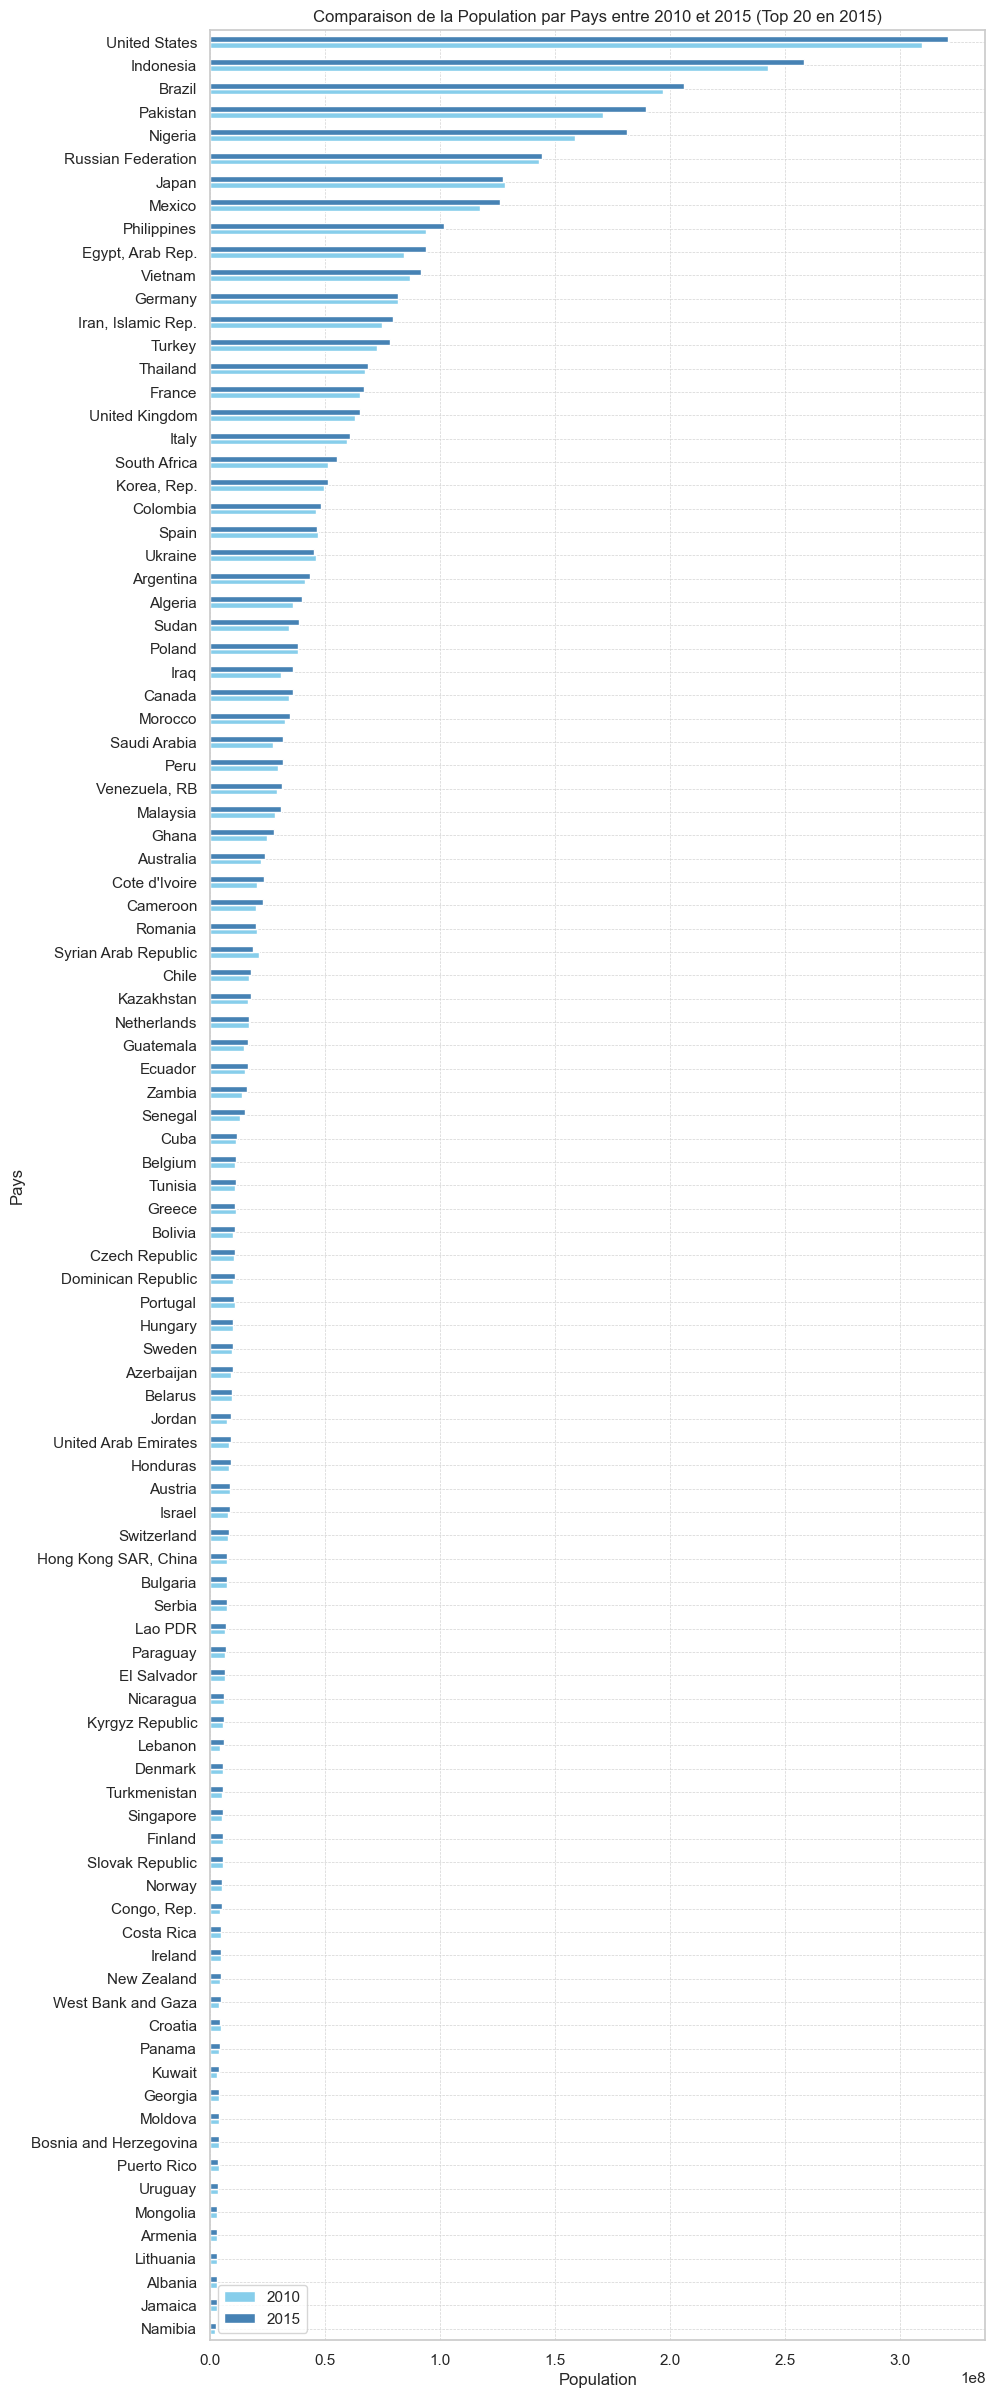

In [766]:
# Calculer la population par pays pour 2010
population_country_2010 = data_2010.groupby('Country Name')['Population, total'].mean()

# Calculer la population par pays pour 2015
population_country_2015 = data_2015.groupby('Country Name')['Population, total'].mean()

# Fusionner les deux séries en un DataFrame
population_comparison_country = pd.DataFrame({'2010': population_country_2010, '2015': population_country_2015})

# Trier le DataFrame par l'une des années pour la visualisation, par exemple 2015
population_comparison_country.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
population_comparison_country.plot(kind='barh', figsize=(10, 30), color=['skyblue', 'steelblue'])
plt.title('Comparaison de la Population par Pays entre 2010 et 2015 (Top 20 en 2015)')
plt.xlabel('Population')
plt.ylabel('Pays')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

#### <font color='skyblue'> Richesse des habitants</font>

- Statistiques descriptives


In [767]:
# Statistiques descriptives
wealth_stats_2010 = data_2010['GNI per capita, Atlas method (current US$)'].describe()
wealth_stats_2015 = data_2015['GNI per capita, Atlas method (current US$)'].describe()
print("Statistiques population 2010 : ",wealth_stats_2010,"Statistiques population 2015 : ",wealth_stats_2015)

Statistiques population 2010 :  count       99.000000
mean     16255.959596
std      19247.492014
min        850.000000
25%       2960.000000
50%       6980.000000
75%      25310.000000
max      88440.000000
Name: GNI per capita, Atlas method (current US$), dtype: float64 Statistiques population 2015 :  count       99.000000
mean     17570.000000
std      20075.318332
min        980.000000
25%       3845.000000
50%       7480.000000
75%      25555.000000
max      93860.000000
Name: GNI per capita, Atlas method (current US$), dtype: float64


<Figure size 800x600 with 0 Axes>

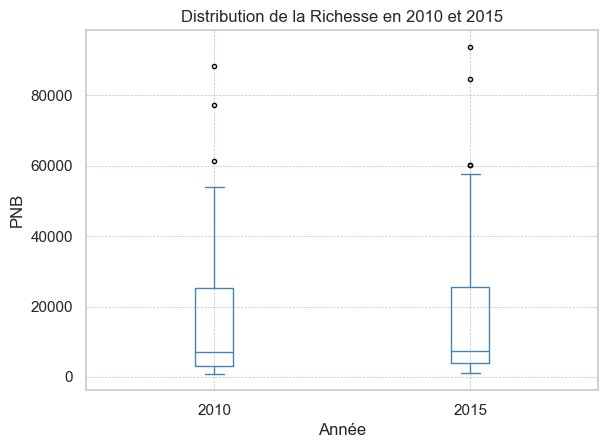

In [768]:
# Concaténer les deux DataFrames en un seul
combined_wealth = pd.concat([data_2015[['GNI per capita, Atlas method (current US$)', 'Year']], data_2010[['GNI per capita, Atlas method (current US$)', 'Year']]])

# Créer le boxplot
plt.figure(figsize=(8, 6))
combined_wealth.boxplot(by='Year', column=['GNI per capita, Atlas method (current US$)'], color='steelblue', flierprops=dict(marker='.'))
plt.title('Distribution de la Richesse en 2010 et 2015')
plt.suptitle('')  # Supprimer le titre supplémentaire
plt.ylabel('PNB')
plt.xlabel('Année')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')

plt.show()

Sans surprises, malgré la suppression des pays aux revenus les plus faibles, un désequilibre persiste dans le PNB par habitant.

- Distribution par pays


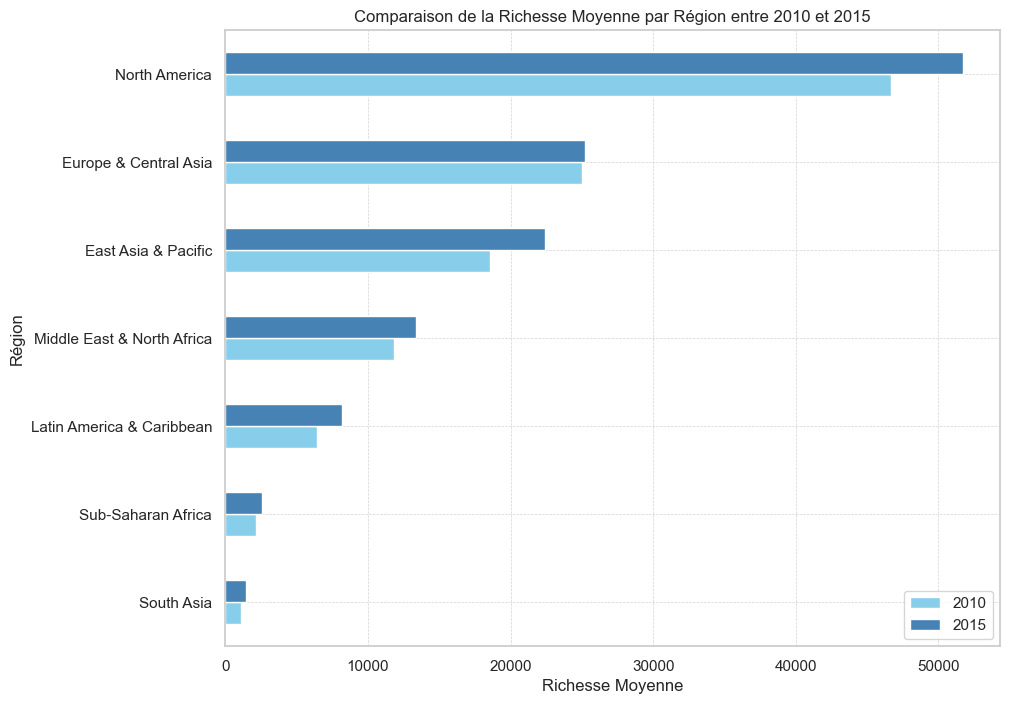

In [769]:
# Calculer la richesse moyenne par région pour 2010
wealth_region_2010 = data_2010.groupby('Region')['GNI per capita, Atlas method (current US$)'].mean()

# Calculer la richesse moyenne par région pour 2015
wealth_region_2015 = data_2015.groupby('Region')['GNI per capita, Atlas method (current US$)'].mean()

# Fusionner les deux séries en un DataFrame
wealth_comparison = pd.DataFrame({'2010': wealth_region_2010, '2015': wealth_region_2015})

# Trier le DataFrame pour la visualisation
wealth_comparison.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
wealth_comparison.plot(kind='barh', figsize=(10, 8), color=['skyblue', 'steelblue'])
plt.title('Comparaison de la Richesse Moyenne par Région entre 2010 et 2015')
plt.xlabel('Richesse Moyenne')
plt.ylabel('Région')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

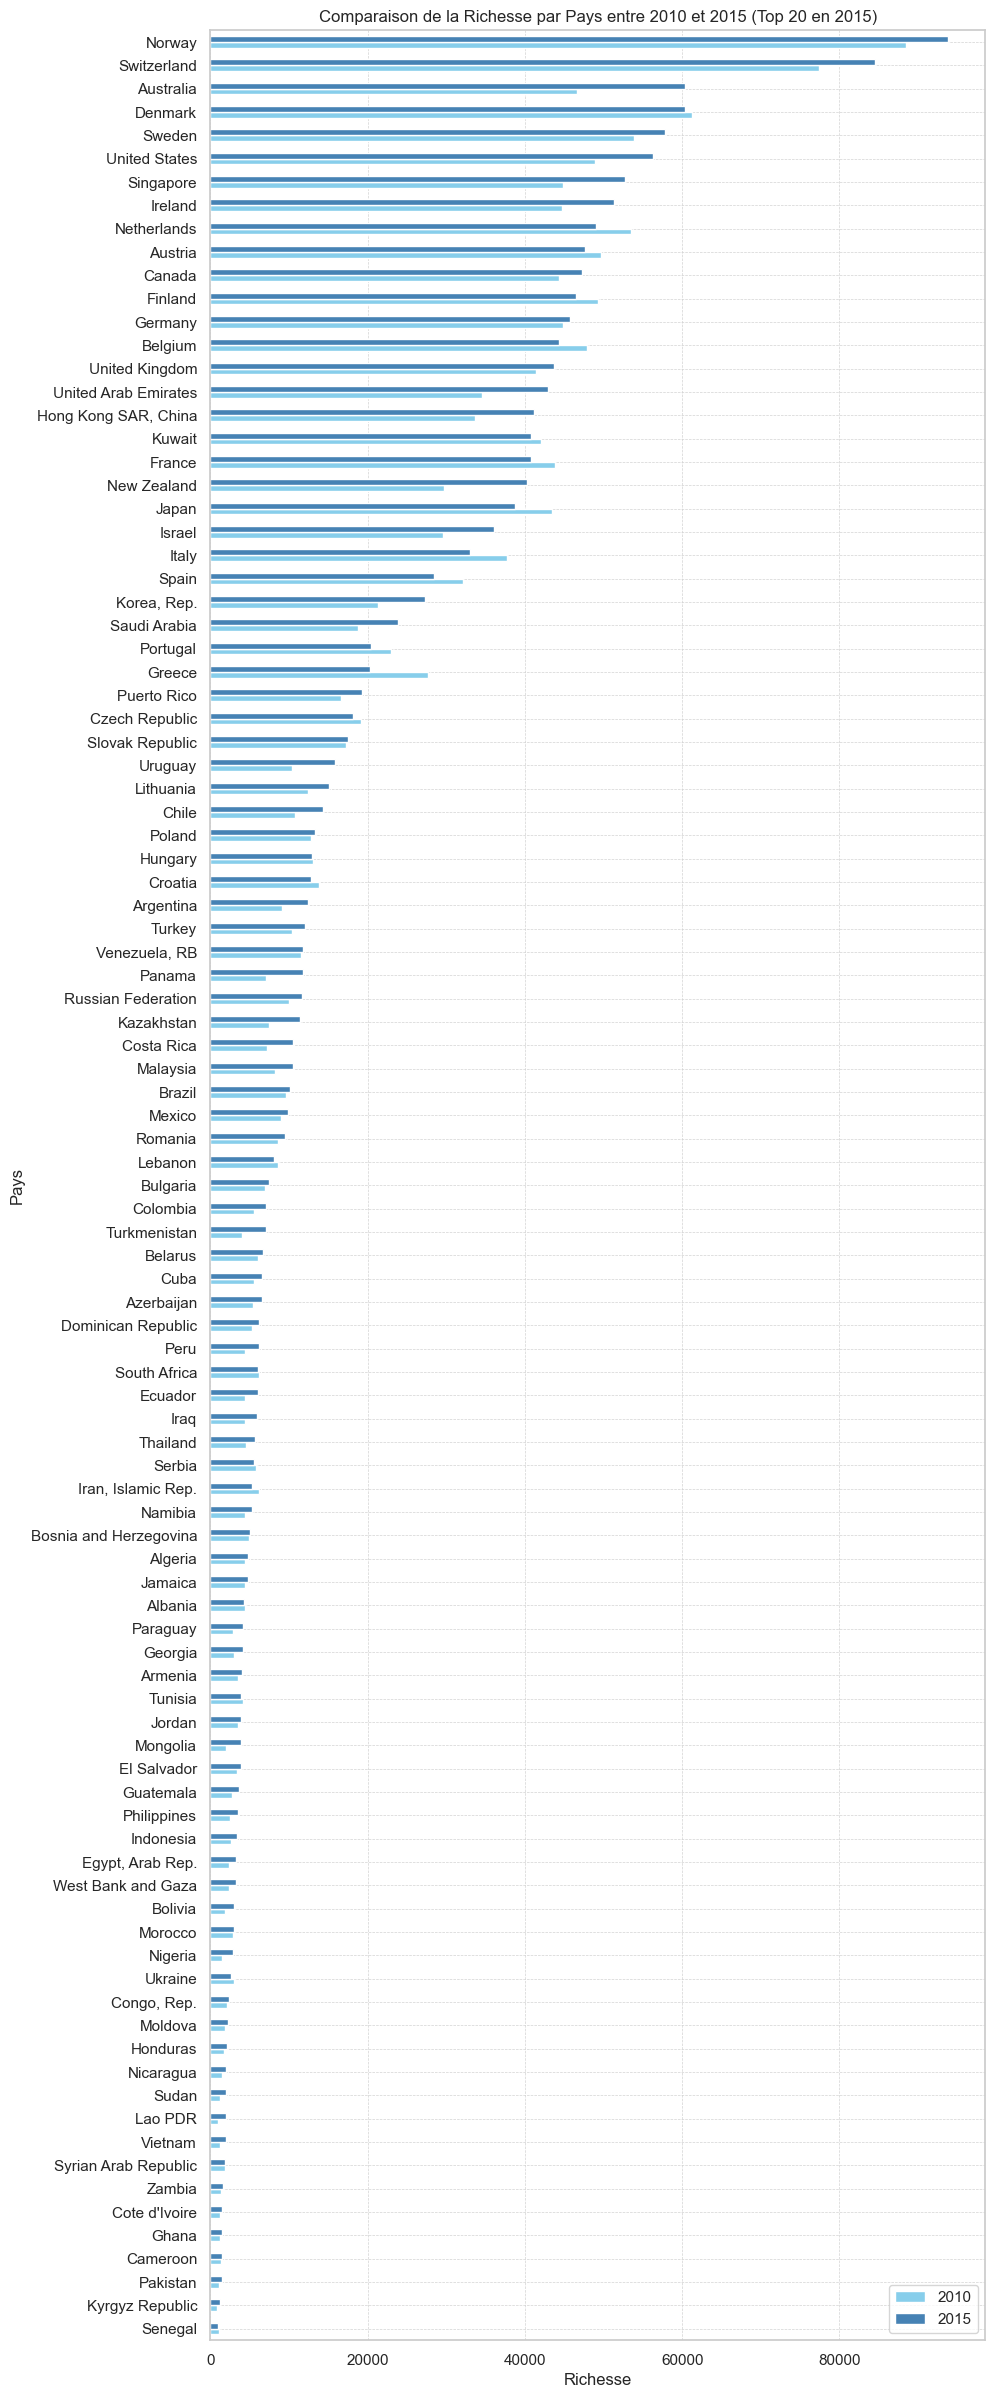

In [770]:
# Calculer la richesse par pays pour 2010
wealth_country_2010 = data_2010.groupby('Country Name')['GNI per capita, Atlas method (current US$)'].mean()

# Calculer la richesse par pays pour 2015
wealth_country_2015 = data_2015.groupby('Country Name')['GNI per capita, Atlas method (current US$)'].mean()

# Fusionner les deux séries en un DataFrame
wealth_comparison_country = pd.DataFrame({'2010': wealth_country_2010, '2015': wealth_country_2015})

# Trier le DataFrame par l'une des années pour la visualisation, par exemple 2015
wealth_comparison_country.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
wealth_comparison_country.plot(kind='barh', figsize=(10, 30), color=['skyblue', 'steelblue'])
plt.title('Comparaison de la Richesse par Pays entre 2010 et 2015 (Top 20 en 2015)')
plt.xlabel('Richesse')
plt.ylabel('Pays')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

#### <font color='skyblue'> Chômage </font>

- Statistiques descriptives


In [771]:
# Statistiques descriptives
unemp_stats_2010 = data_2010['Unemployment, total (% of total labor force)'].describe()
unemp_stats_2015 = data_2015['Unemployment, total (% of total labor force)'].describe()
print("Statistiques Chomage 2010 : ",unemp_stats_2010,"Statistiques Chomage 2015 : ",unemp_stats_2015)

Statistiques Chomage 2010 :  count    99.000000
mean      8.941414
std       5.114306
min       0.700000
25%       5.600000
50%       8.100000
75%      11.000000
max      27.200001
Name: Unemployment, total (% of total labor force), dtype: float64 Statistiques Chomage 2015 :  count    99.000000
mean      8.615152
std       5.523851
min       0.500000
25%       5.000000
50%       7.000000
75%      10.750000
max      26.299999
Name: Unemployment, total (% of total labor force), dtype: float64


<Figure size 800x600 with 0 Axes>

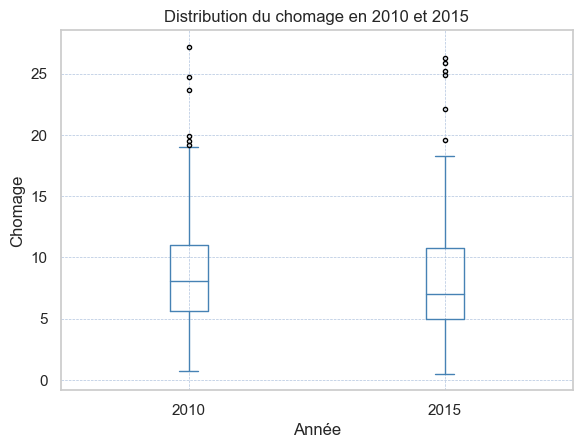

In [772]:
# Concaténer les deux DataFrames en un seul
combined_unemp = pd.concat([data_2015[['Unemployment, total (% of total labor force)', 'Year']], data_2010[['Unemployment, total (% of total labor force)', 'Year']]])

# Créer le boxplot
plt.figure(figsize=(8, 6))
combined_unemp.boxplot(by='Year', column=['Unemployment, total (% of total labor force)'], color='steelblue', flierprops=dict(marker='.'))
plt.title('Distribution du chomage en 2010 et 2015')
plt.suptitle('')  # Supprimer le titre supplémentaire
plt.ylabel('Chomage')
plt.xlabel('Année')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')

plt.show()

- Distribution par pays


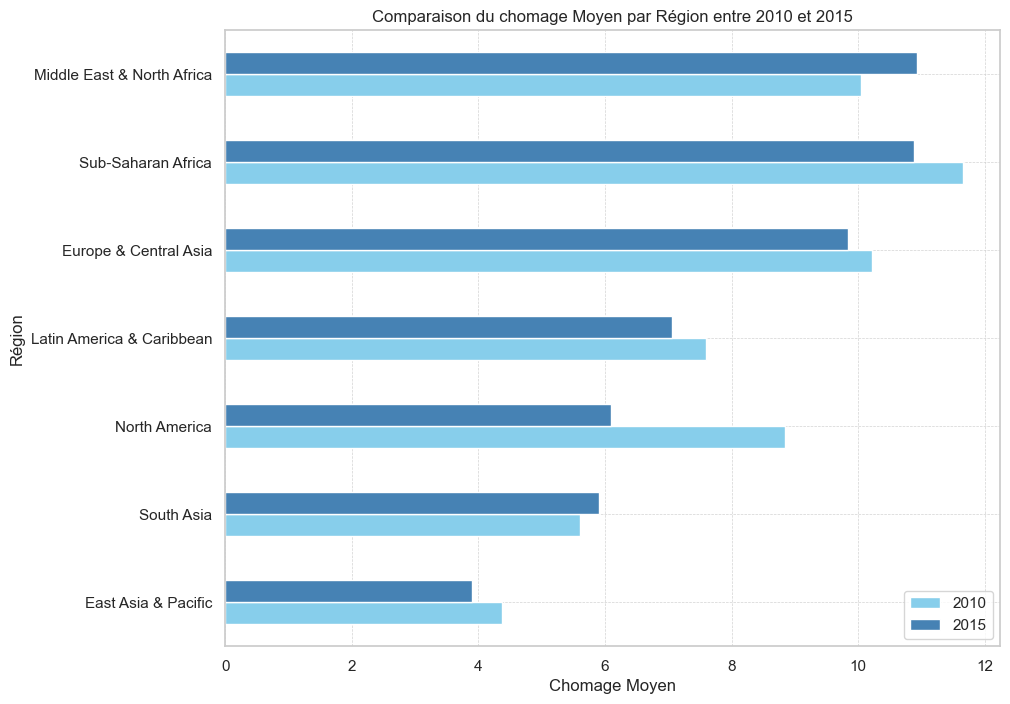

In [773]:
# Calculer chomage moyenne par région pour 2010
unemp_region_2010 = data_2010.groupby('Region')['Unemployment, total (% of total labor force)'].mean()

# Calculer chomage moyenne par région pour 2015
unemp_region_2015 = data_2015.groupby('Region')['Unemployment, total (% of total labor force)'].mean()

# Fusionner les deux séries en un DataFrame
unemp_comparison = pd.DataFrame({'2010': unemp_region_2010, '2015': unemp_region_2015})

# Trier le DataFrame pour la visualisation
unemp_comparison.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
unemp_comparison.plot(kind='barh', figsize=(10, 8), color=['skyblue', 'steelblue'])
plt.title('Comparaison du chomage Moyen par Région entre 2010 et 2015')
plt.xlabel('Chomage Moyen')
plt.ylabel('Région')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

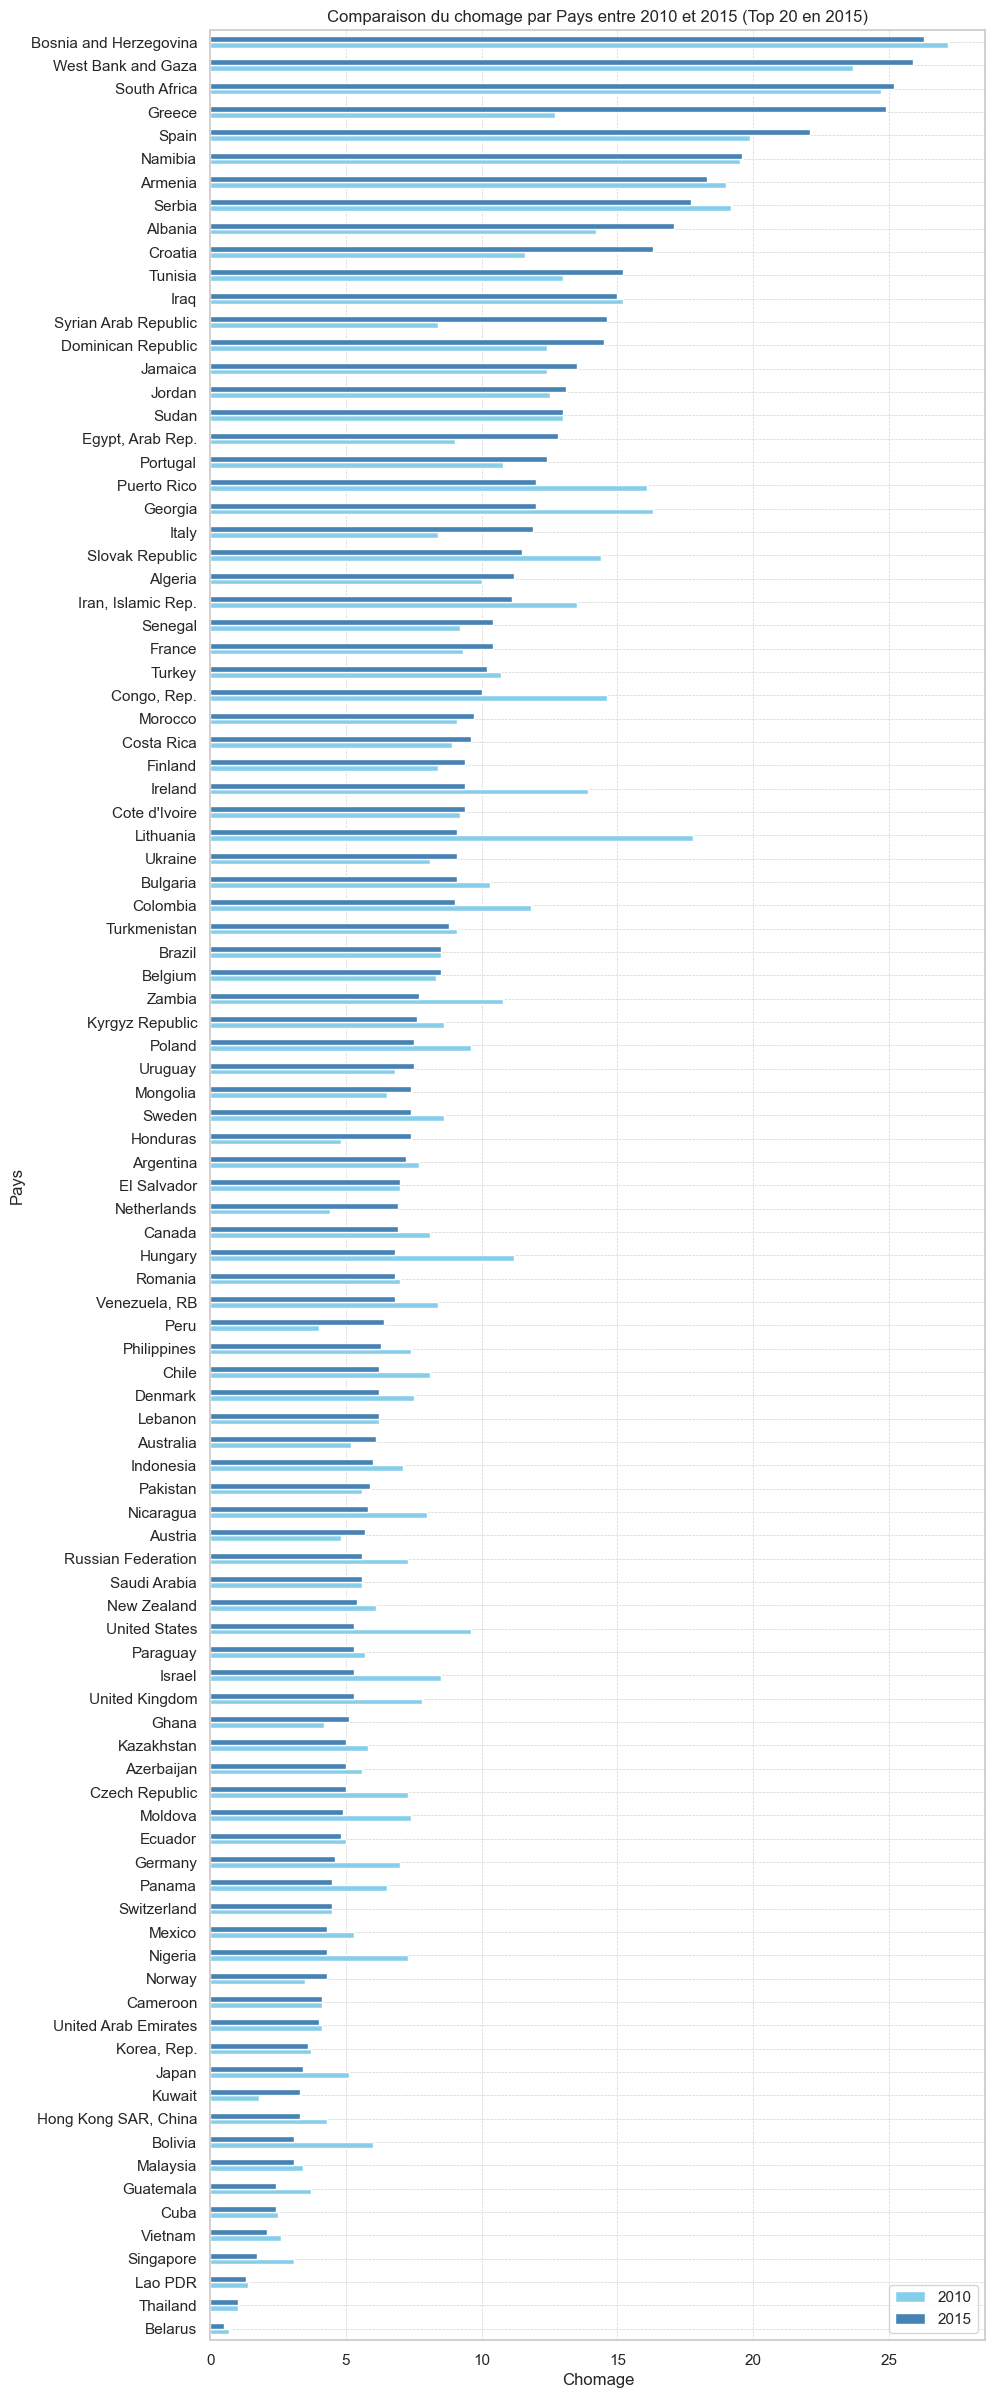

In [774]:
# Calculer chomagen par pays pour 2010
unemp_country_2010 = data_2010.groupby('Country Name')['Unemployment, total (% of total labor force)'].mean()

# Calculer chomage par pays pour 2015
unemp_country_2015 = data_2015.groupby('Country Name')['Unemployment, total (% of total labor force)'].mean()

# Fusionner les deux séries en un DataFrame
unemp_comparison_country = pd.DataFrame({'2010': unemp_country_2010, '2015': unemp_country_2015})

# Trier le DataFrame par l'une des années pour la visualisation, par exemple 2015
unemp_comparison_country.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
unemp_comparison_country.plot(kind='barh', figsize=(10, 30), color=['skyblue', 'steelblue'])
plt.title('Comparaison du chomage par Pays entre 2010 et 2015 (Top 20 en 2015)')
plt.xlabel('Chomage')
plt.ylabel('Pays')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

#### <font color='skyblue'> Accès internet </font>

- Statistiques descriptives


In [775]:
# Statistiques descriptives
internet_stats_2010 = data_2010['Internet users (per 100 people)'].describe()
internet_stats_2015 = data_2015['Internet users (per 100 people)'].describe()
print("Statistiques internet 2010 : ",internet_stats_2010,"Statistiques internet 2015 : ",internet_stats_2015)

Statistiques internet 2010 :  count    99.000000
mean     42.074646
std      26.008614
min       2.500000
25%      21.150000
50%      39.930000
75%      65.400000
max      93.390000
Name: Internet users (per 100 people), dtype: float64 Statistiques internet 2015 :  count    99.000000
mean     57.714354
std      23.569577
min       7.615975
25%      38.758063
50%      59.762950
75%      77.176045
max      96.810300
Name: Internet users (per 100 people), dtype: float64


<Figure size 800x600 with 0 Axes>

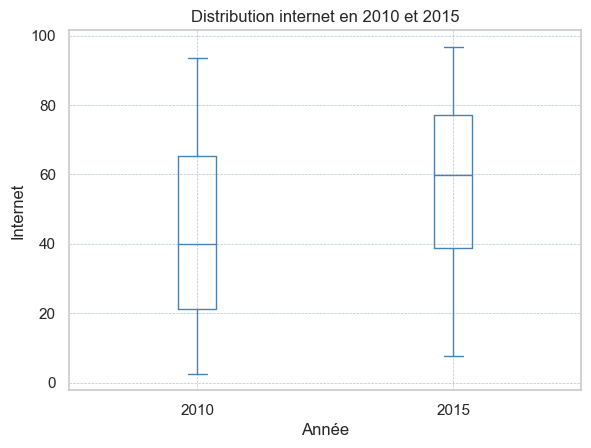

In [776]:
# Concaténer les deux DataFrames en un seul
combined_internet = pd.concat([data_2015[['Internet users (per 100 people)', 'Year']], data_2010[['Internet users (per 100 people)', 'Year']]])

# Créer le boxplot
plt.figure(figsize=(8, 6))
combined_internet.boxplot(by='Year', column=['Internet users (per 100 people)'], color='steelblue', flierprops=dict(marker='.'))
plt.title('Distribution internet en 2010 et 2015')
plt.suptitle('')  # Supprimer le titre supplémentaire
plt.ylabel('Internet')
plt.xlabel('Année')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')

plt.show()

Sans surprises l'accès à internet des populations mondiales est plutot équilibré.


- Distribution par pays


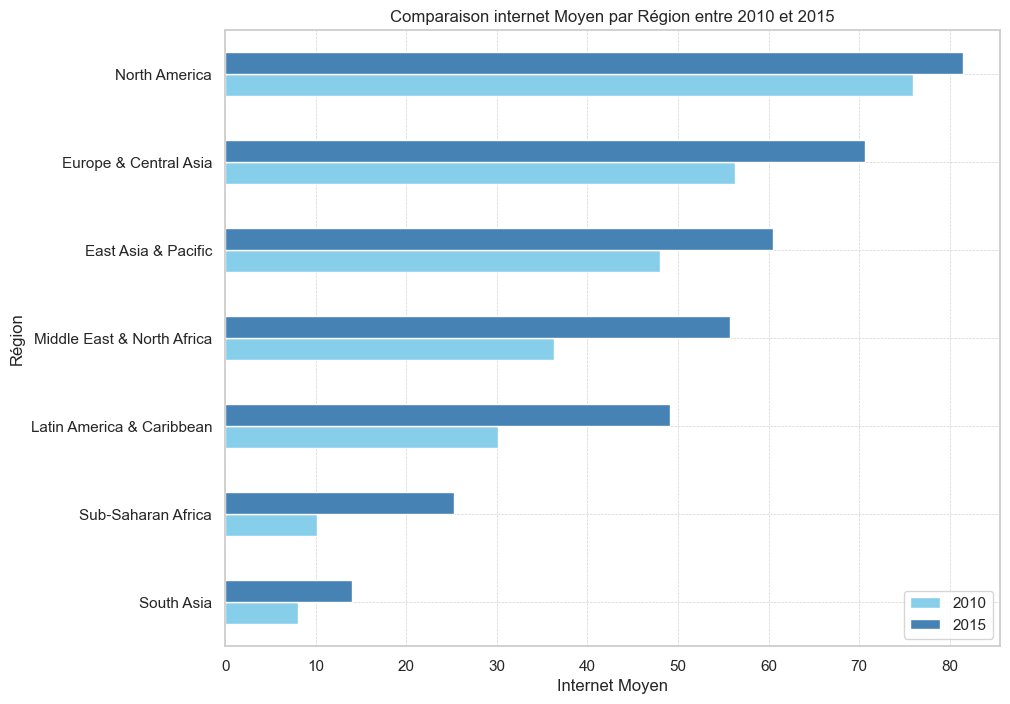

In [777]:
# Calculer internet moyenne par région pour 2010
internet_region_2010 = data_2010.groupby('Region')['Internet users (per 100 people)'].mean()

# Calculer internet moyenne par région pour 2015
internet_region_2015 = data_2015.groupby('Region')['Internet users (per 100 people)'].mean()

# Fusionner les deux séries en un DataFrame
internet_comparison = pd.DataFrame({'2010': internet_region_2010, '2015': internet_region_2015})

# Trier le DataFrame pour la visualisation
internet_comparison.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
internet_comparison.plot(kind='barh', figsize=(10, 8), color=['skyblue', 'steelblue'])
plt.title('Comparaison internet Moyen par Région entre 2010 et 2015')
plt.xlabel('Internet Moyen')
plt.ylabel('Région')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()


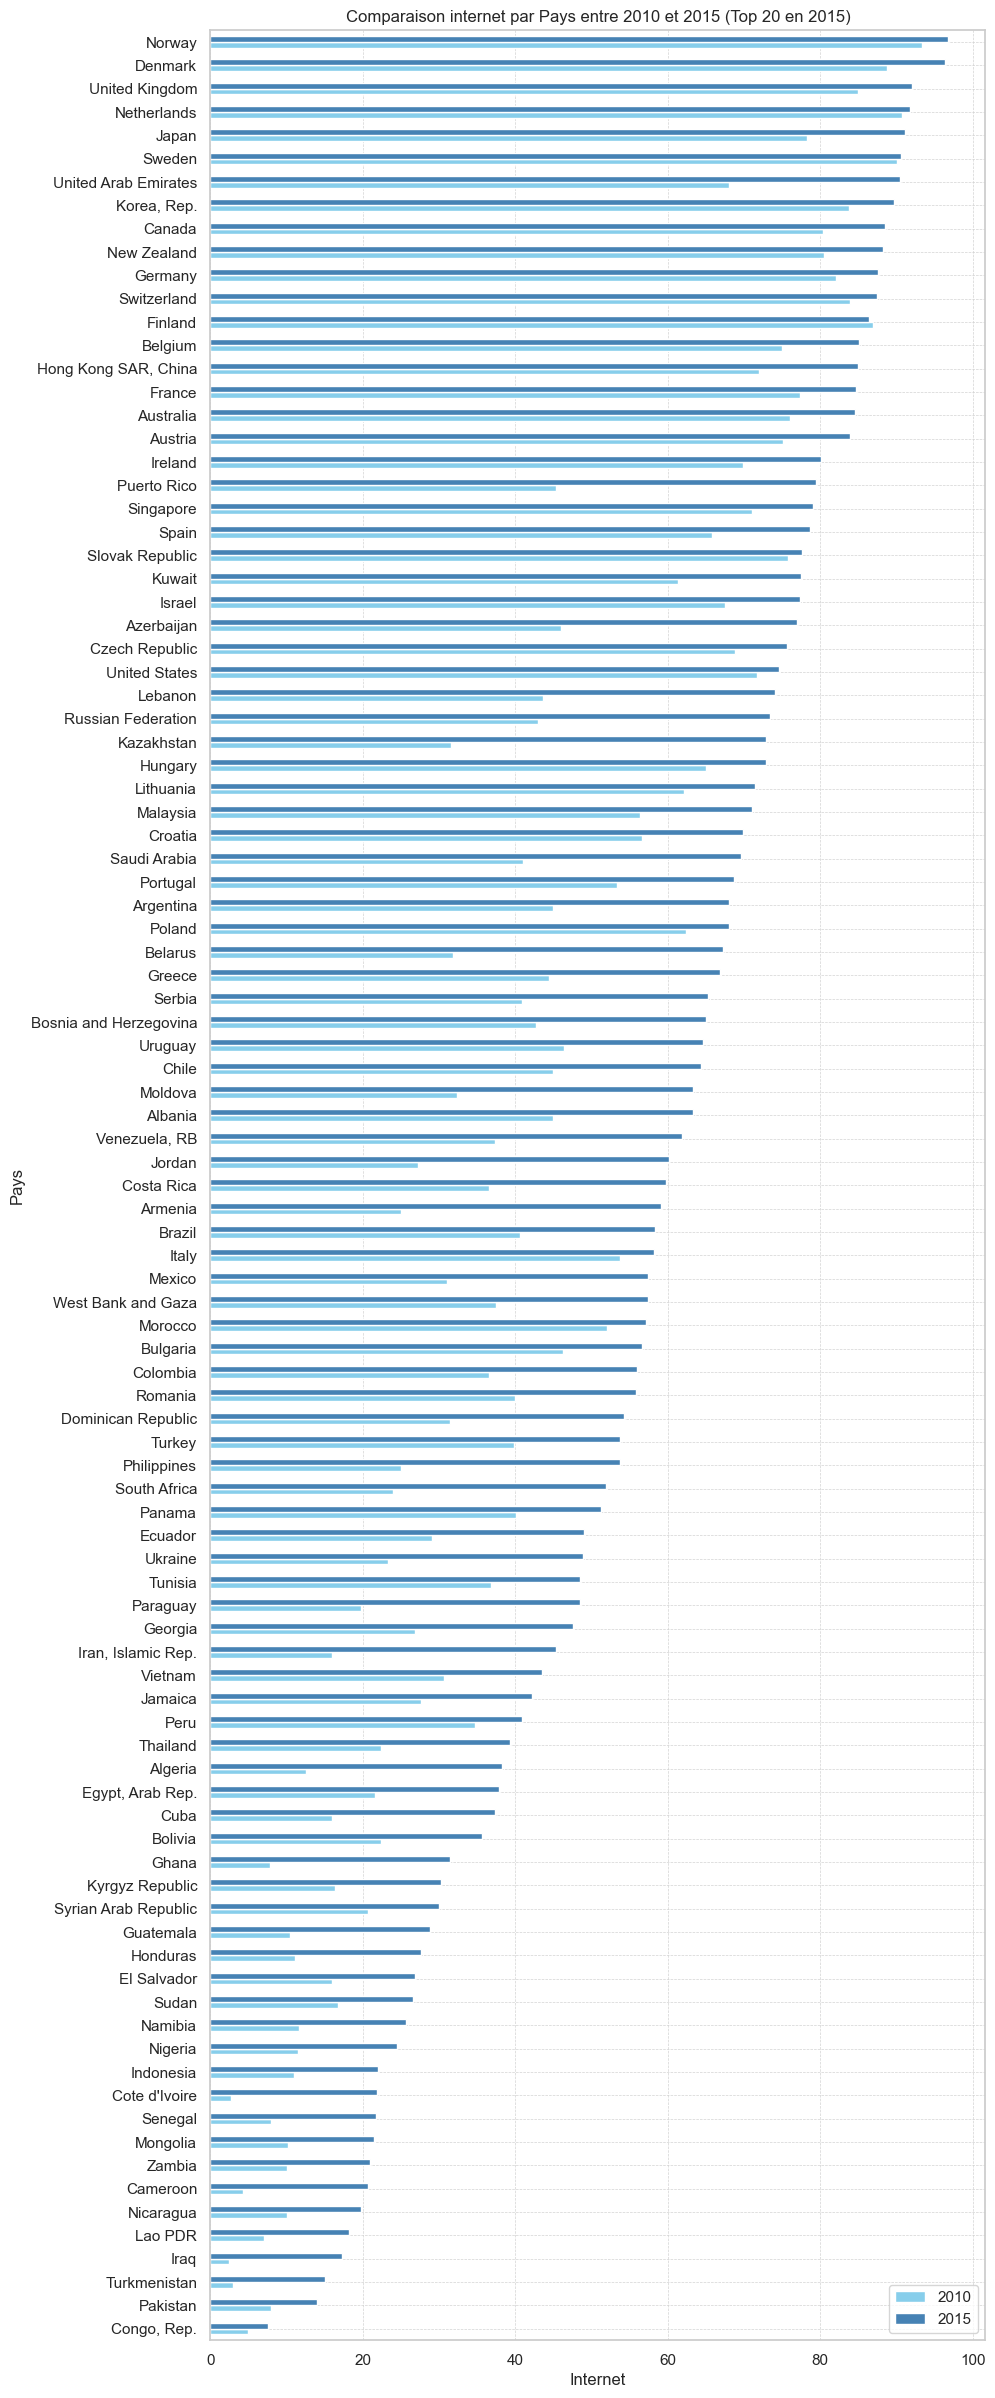

In [778]:
# Calculer internet par pays pour 2010
internet_country_2010 = data_2010.groupby('Country Name')['Internet users (per 100 people)'].mean()

# Calculer internet par pays pour 2015
internet_country_2015 = data_2015.groupby('Country Name')['Internet users (per 100 people)'].mean()

# Fusionner les deux séries en un DataFrame
internet_comparison_country = pd.DataFrame({'2010': internet_country_2010, '2015': internet_country_2015})

# Trier le DataFrame par l'une des années pour la visualisation, par exemple 2015
internet_comparison_country.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
internet_comparison_country.plot(kind='barh', figsize=(10, 30), color=['skyblue', 'steelblue'])
plt.title('Comparaison internet par Pays entre 2010 et 2015 (Top 20 en 2015)')
plt.xlabel('Internet')
plt.ylabel('Pays')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

#### <font color='skyblue'> Taux d'education </font>

- Statistiques descriptives


In [779]:
# Statistiques descriptives
education_stats_2010 = data_2010['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total'].describe()
education_stats_2015 = data_2015['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total'].describe()
print("Statistiques education 2010 : ",education_stats_2010,"Statistiques education 2015 : ",education_stats_2015)

Statistiques education 2010 :  count    99.000000
mean      0.151919
std       0.121258
min       0.020000
25%       0.060000
50%       0.120000
75%       0.205000
max       0.750000
Name: Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total, dtype: float64 Statistiques education 2015 :  count    99.000000
mean      0.163232
std       0.128348
min       0.020000
25%       0.070000
50%       0.130000
75%       0.220000
max       0.760000
Name: Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total, dtype: float64


<Figure size 800x600 with 0 Axes>

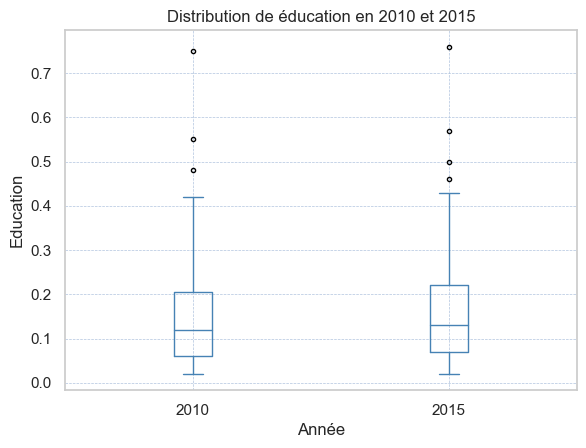

In [780]:
# Concaténer les deux DataFrames en un seul
combined_education = pd.concat([data_2015[['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total', 'Year']], data_2010[['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total', 'Year']]])

# Créer le boxplot
plt.figure(figsize=(8, 6))
combined_education.boxplot(by='Year', column=['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total'], color='steelblue', flierprops=dict(marker='.'))
plt.title('Distribution de éducation en 2010 et 2015')
plt.suptitle('')  # Supprimer le titre supplémentaire
plt.ylabel('Education')
plt.xlabel('Année')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')

plt.show()

Un pays est largement au dessus des autres.

- Distribution par pays


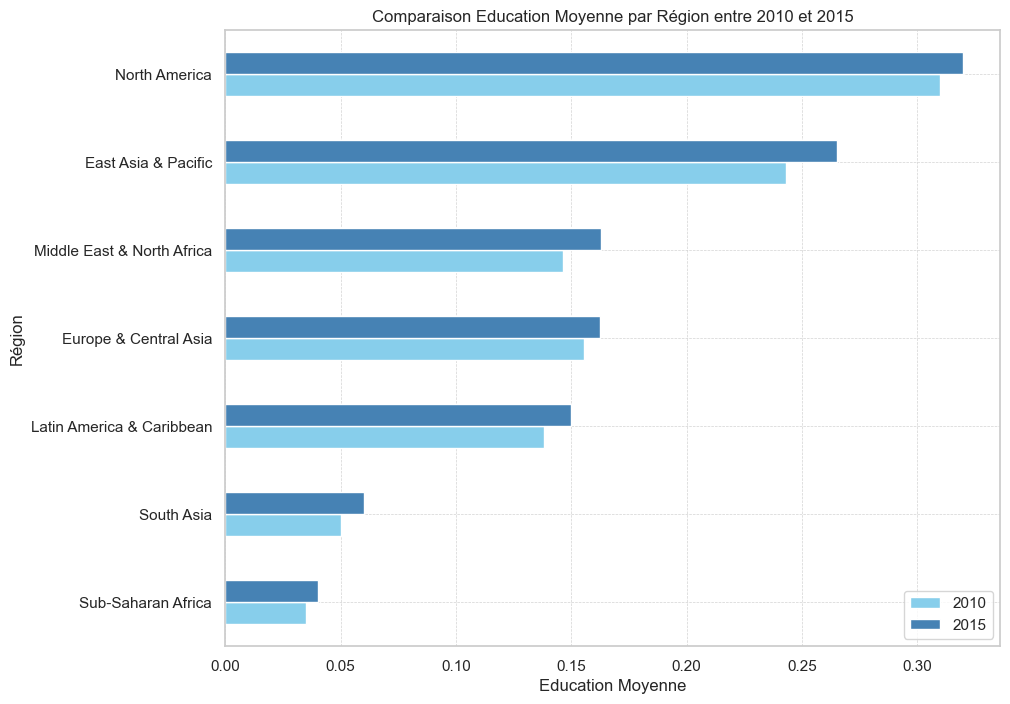

In [781]:
# Calculer education moyenne par région pour 2010
education_region_2010 = data_2010.groupby('Region')['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total'].mean()

# Calculer education moyenne par région pour 2015
education_region_2015 = data_2015.groupby('Region')['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total'].mean()

# Fusionner les deux séries en un DataFrame
education_comparison = pd.DataFrame({'2010': education_region_2010, '2015': education_region_2015})

# Trier le DataFrame pour la visualisation
education_comparison.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
education_comparison.plot(kind='barh', figsize=(10, 8), color=['skyblue', 'steelblue'])
plt.title('Comparaison Education Moyenne par Région entre 2010 et 2015')
plt.xlabel('Education Moyenne')
plt.ylabel('Région')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()


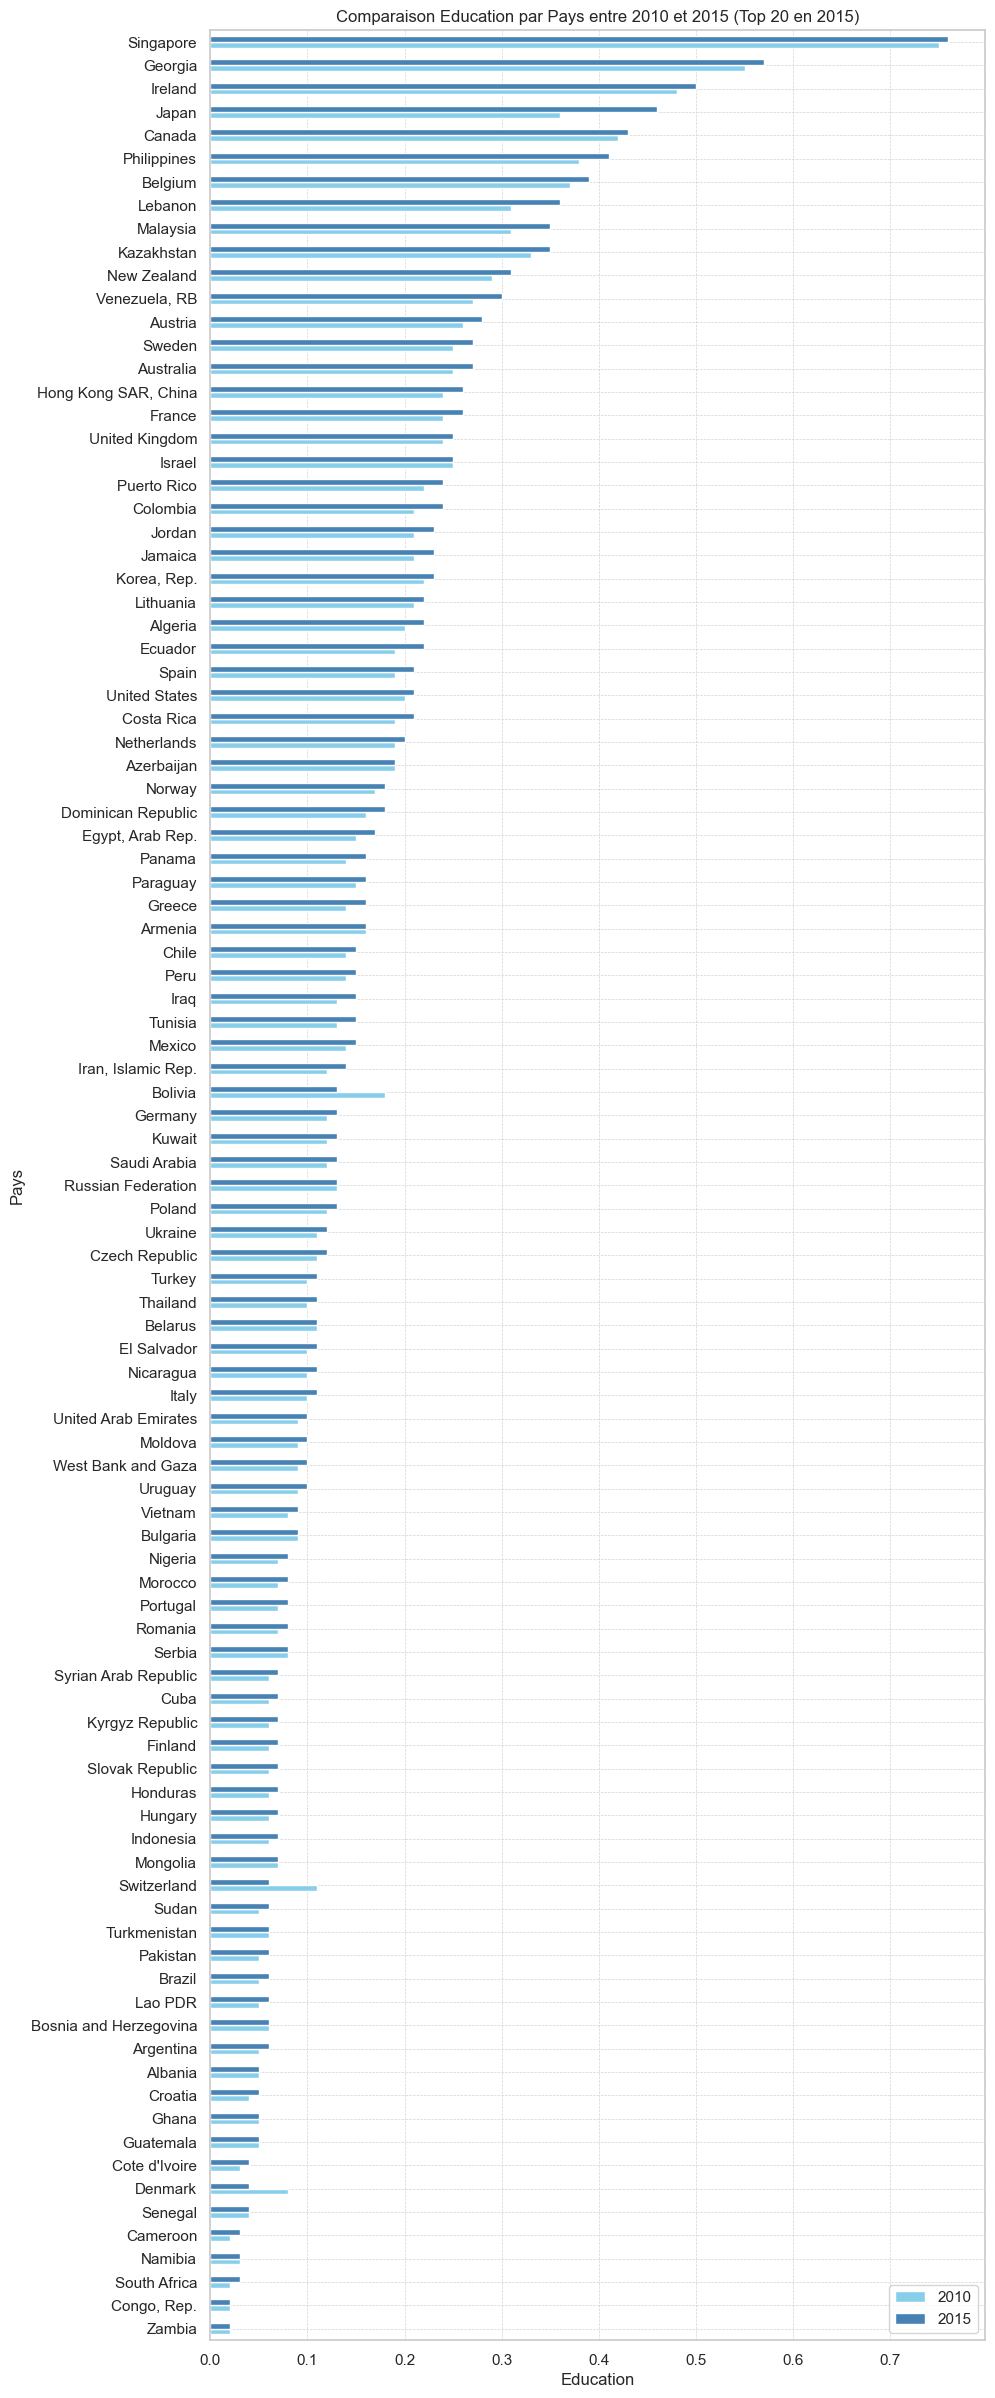

In [782]:
# Calculer education par pays pour 2010
education_country_2010 = data_2010.groupby('Country Name')['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total'].mean()

# Calculer education par pays pour 2015
education_country_2015 = data_2015.groupby('Country Name')['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total'].mean()

# Fusionner les deux séries en un DataFrame
education_comparison_country = pd.DataFrame({'2010': education_country_2010, '2015': education_country_2015})

# Trier le DataFrame par l'une des années pour la visualisation, par exemple 2015
education_comparison_country.sort_values(by='2015', ascending=True, inplace=True)

# Créer le diagramme en barres
education_comparison_country.plot(kind='barh', figsize=(10, 30), color=['skyblue', 'steelblue'])
plt.title('Comparaison Education par Pays entre 2010 et 2015 (Top 20 en 2015)')
plt.xlabel('Education')
plt.ylabel('Pays')
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

### <font color='aqua'> 2. Analyse multi-variée </font>

Cette partie examinera les relations entre les différentes variables du DataFrame. L'objectif est d'identifier les corrélations, les tendances et les modèles potentiels entre les indicateurs, tels que la relation entre le PIB par habitant et le taux d'accès à Internet.

#### <font color='skyblue'> Analyse de l'évolution des indicateurs </font>

Nous analysons les variation de nos indicateurs dans le temps afin de créer un score pour les pays ayant la courbe d'évolution la plus importante.

In [783]:
# Fusion des deux DataFrames sur 'Country Name' et 'Indicator Code'
comparison_data = pd.merge(data_2010,data_2015,on=['Country Name'],how='inner')


In [784]:
comparison_data.head(2)

Country Name                    Region_x  Population, total_x  \
0               Albania       Europe & Central Asia            2913021.0   
1  United Arab Emirates  Middle East & North Africa            8270684.0   

   GNI per capita, Atlas method (current US$)_x  \
0                                        4360.0   
1                                       34530.0   

   Unemployment, total (% of total labor force)_x  \
0                                            14.2   
1                                             4.1   

   Internet users (per 100 people)_x  \
0                               45.0   
1                               68.0   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_x  \
0                                               0.05                                                                                     
1                                               0.09                                                                                     

  Year_x                    Region_y  Population, total_y  \
0   2010       Europe & Central Asia            2880703.0   
1   2010  Middle East & North Africa            9154302.0   

   GNI per capita, Atlas method (current US$)_y  \
0                                        4290.0   
1                                       42910.0   

   Unemployment, total (% of total labor force)_y  \
0                                            17.1   
1                                             4.0   

   Internet users (per 100 people)_y  \
0                          63.252933   
1                          90.500000   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_y  \
0                                               0.05                                                                                     
1                                               0.10                                                                                     

  Year_y  
0   2015  
1   2015

In [785]:
comparison_data['Variation Population (%)'] = ((comparison_data['Population, total_y'] - comparison_data['Population, total_x']) / comparison_data['Population, total_y']) * 100
comparison_data['Variation GNI (%)'] = ((comparison_data['GNI per capita, Atlas method (current US$)_y'] - comparison_data['GNI per capita, Atlas method (current US$)_x']) / comparison_data['GNI per capita, Atlas method (current US$)_y']) * 100
comparison_data['Variation Unemployment (%)'] = ((comparison_data['Unemployment, total (% of total labor force)_y'] - comparison_data['Unemployment, total (% of total labor force)_x']) / comparison_data['Unemployment, total (% of total labor force)_y']) * 100
comparison_data['Variation Internet (%)'] = ((comparison_data['Internet users (per 100 people)_y'] - comparison_data['Internet users (per 100 people)_x']) / comparison_data['Internet users (per 100 people)_y']) * 100
comparison_data['Variation Education (%)'] = ((comparison_data['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_y'] - comparison_data['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_x']) / comparison_data['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_y']) * 100


In [786]:
# Filtrer le DataFrame pour afficher les données pour "France"
france_data = comparison_data[comparison_data['Country Name'] == 'France']

france_data

Country Name               Region_x  Population, total_x  \
31       France  Europe & Central Asia           65027512.0   

    GNI per capita, Atlas method (current US$)_x  \
31                                       43790.0   

    Unemployment, total (% of total labor force)_x  \
31                                             9.3   

    Internet users (per 100 people)_x  \
31                              77.28   

    Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_x  \
31                                               0.24                                                                                     

   Year_x               Region_y  Population, total_y  \
31   2010  Europe & Central Asia           66624068.0   

    GNI per capita, Atlas method (current US$)_y  \
31                                       40730.0   

    Unemployment, total (% of total labor force)_y  \
31                                            10.4   

    Internet users (per 100 people)_y  \
31                            84.6945   

    Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_y  \
31                                               0.26                                                                                     

   Year_y  Variation Population (%)  Variation GNI (%)  \
31   2015                  2.396365           -7.51289   

    Variation Unemployment (%)  Variation Internet (%)  \
31                   10.576918                8.754406   

    Variation Education (%)  
31                 7.692308

In [787]:
# Extraction du max et min de evo population
valeur_min_evo_pop = comparison_data['Variation Population (%)'].min()
valeur_max_evo_pop = comparison_data['Variation Population (%)'].max()
# Extraction du max et min de evo gni
valeur_min_evo_gni = comparison_data['Variation GNI (%)'].min()
valeur_max_evo_gni = comparison_data['Variation GNI (%)'].max()
# Extraction du max et min de evo unemployment
valeur_min_evo_unemp = comparison_data['Variation Unemployment (%)'].min()
valeur_max_evo_unemp = comparison_data['Variation Unemployment (%)'].max()
# Extraction du max et min de evo internet
valeur_min_evo_inter = comparison_data['Variation Internet (%)'].min()
valeur_max_evo_inter = comparison_data['Variation Internet (%)'].max()
# Extraction du max et min de evo education
valeur_min_evo_edu = comparison_data['Variation Education (%)'].min()
valeur_max_evo_edu = comparison_data['Variation Education (%)'].max()

In [788]:
score_evo_df=comparison_data.copy()


In [789]:
# Calculer le score normalisé pour chaque individu dans la colonne "evolution"
score_evo_df['Population Variation Score'] = (score_evo_df['Variation Population (%)'] - valeur_min_evo_pop) / (valeur_max_evo_pop - valeur_min_evo_pop)
score_evo_df['GNI Variation Score'] = (score_evo_df['Variation GNI (%)'] - valeur_min_evo_gni) / (valeur_max_evo_gni - valeur_min_evo_gni)
score_evo_df['Unemployment Variation Score'] = (score_evo_df['Variation Unemployment (%)'] - valeur_min_evo_unemp) / (valeur_max_evo_unemp - valeur_min_evo_unemp)
score_evo_df['Internet Variation Score'] = (score_evo_df['Variation Internet (%)'] - valeur_min_evo_inter) / (valeur_max_evo_inter - valeur_min_evo_inter)
score_evo_df['Education Variation Score'] = (score_evo_df['Variation Education (%)'] - valeur_min_evo_edu) / (valeur_max_evo_edu - valeur_min_evo_edu)

In [790]:
score_evo_df.head(2)

Country Name                    Region_x  Population, total_x  \
0               Albania       Europe & Central Asia            2913021.0   
1  United Arab Emirates  Middle East & North Africa            8270684.0   

   GNI per capita, Atlas method (current US$)_x  \
0                                        4360.0   
1                                       34530.0   

   Unemployment, total (% of total labor force)_x  \
0                                            14.2   
1                                             4.1   

   Internet users (per 100 people)_x  \
0                               45.0   
1                               68.0   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_x  \
0                                               0.05                                                                                     
1                                               0.09                                                                                     

  Year_x                    Region_y  Population, total_y  \
0   2010       Europe & Central Asia            2880703.0   
1   2010  Middle East & North Africa            9154302.0   

   GNI per capita, Atlas method (current US$)_y  \
0                                        4290.0   
1                                       42910.0   

   Unemployment, total (% of total labor force)_y  \
0                                            17.1   
1                                             4.0   

   Internet users (per 100 people)_y  \
0                          63.252933   
1                          90.500000   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total_y  \
0                                               0.05                                                                                     
1                                               0.10                                                                                     

  Year_y  Variation Population (%)  Variation GNI (%)  \
0   2015                 -1.121879          -1.631702   
1   2015                  9.652489          19.529247   

   Variation Unemployment (%)  Variation Internet (%)  \
0                   16.959067               28.857054   
1                   -2.499998               24.861878   

   Variation Education (%)  Population Variation Score  GNI Variation Score  \
0                      0.0                    0.290739             0.402811   
1                     10.0                    0.573755             0.647565   

   Unemployment Variation Score  Internet Variation Score  \
0                      0.778445                  0.333299   
1                      0.643874                  0.288005   

   Education Variation Score  
0                      0.750  
1                      0.825

In [791]:
#calcul d'un score où chaque variable a le meme poids
score_evo_df['Variation Score']=(score_evo_df['Population Variation Score'] + score_evo_df['GNI Variation Score'] + score_evo_df['Unemployment Variation Score'] + score_evo_df['Internet Variation Score'] + score_evo_df['Education Variation Score'])/5

score_evo_df=score_evo_df.sort_values(by=['Variation Score'], ascending=False).reset_index(drop=True)

score_evo_df= score_evo_df[['Country Name','Variation Score']]

score_evo_df.head(10)

Country Name  Variation Score
0              Iraq         0.781072
1     Cote d'Ivoire         0.777621
2      Turkmenistan         0.752733
3          Cameroon         0.746214
4           Lao PDR         0.734327
5          Mongolia         0.725300
6             Ghana         0.719859
7          Honduras         0.719002
8            Jordan         0.713733
9  Egypt, Arab Rep.         0.710455

Nous obtenons un classement des pays qui réalisent la plus importante évolution entre 2010 et 2015.

#### <font color='skyblue'> Recherche des corrélations </font>

- Corrélations entre les distributions

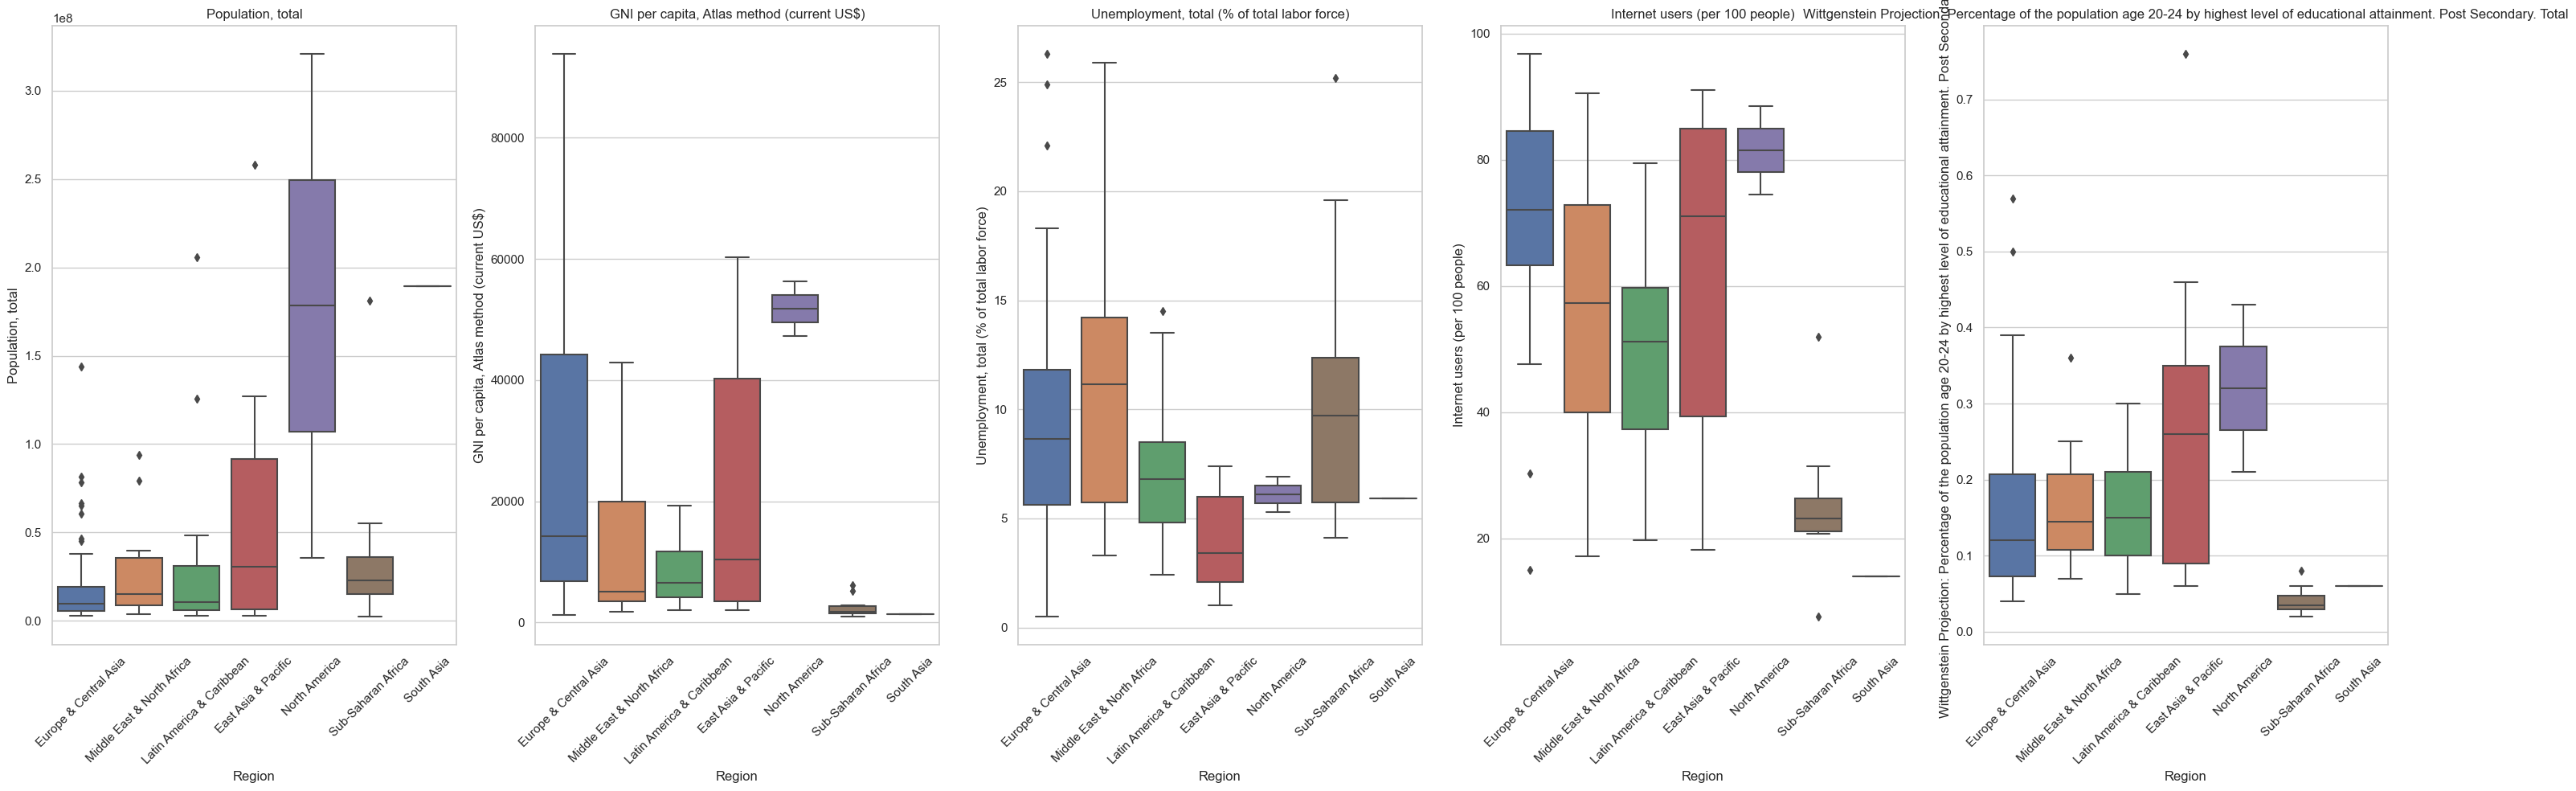

In [792]:
# Liste des indicateurs à visualiser
indicateurs = ['Population, total', 
               'GNI per capita, Atlas method (current US$)', 
               'Unemployment, total (% of total labor force)', 
               'Internet users (per 100 people)', 
               'Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total']

# Création d'une grille de subplots
plt.figure(figsize=(30, 10))  

for i, indicateur in enumerate(indicateurs):
    plt.subplot(1, 5, i+1)  
    sns.boxplot(x='Region', y=indicateur, data=data_2015)
    plt.title(f'{indicateur}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



Chaque indicateur discrimine les régions de manière différente, ils sont donc plutot pertinents.

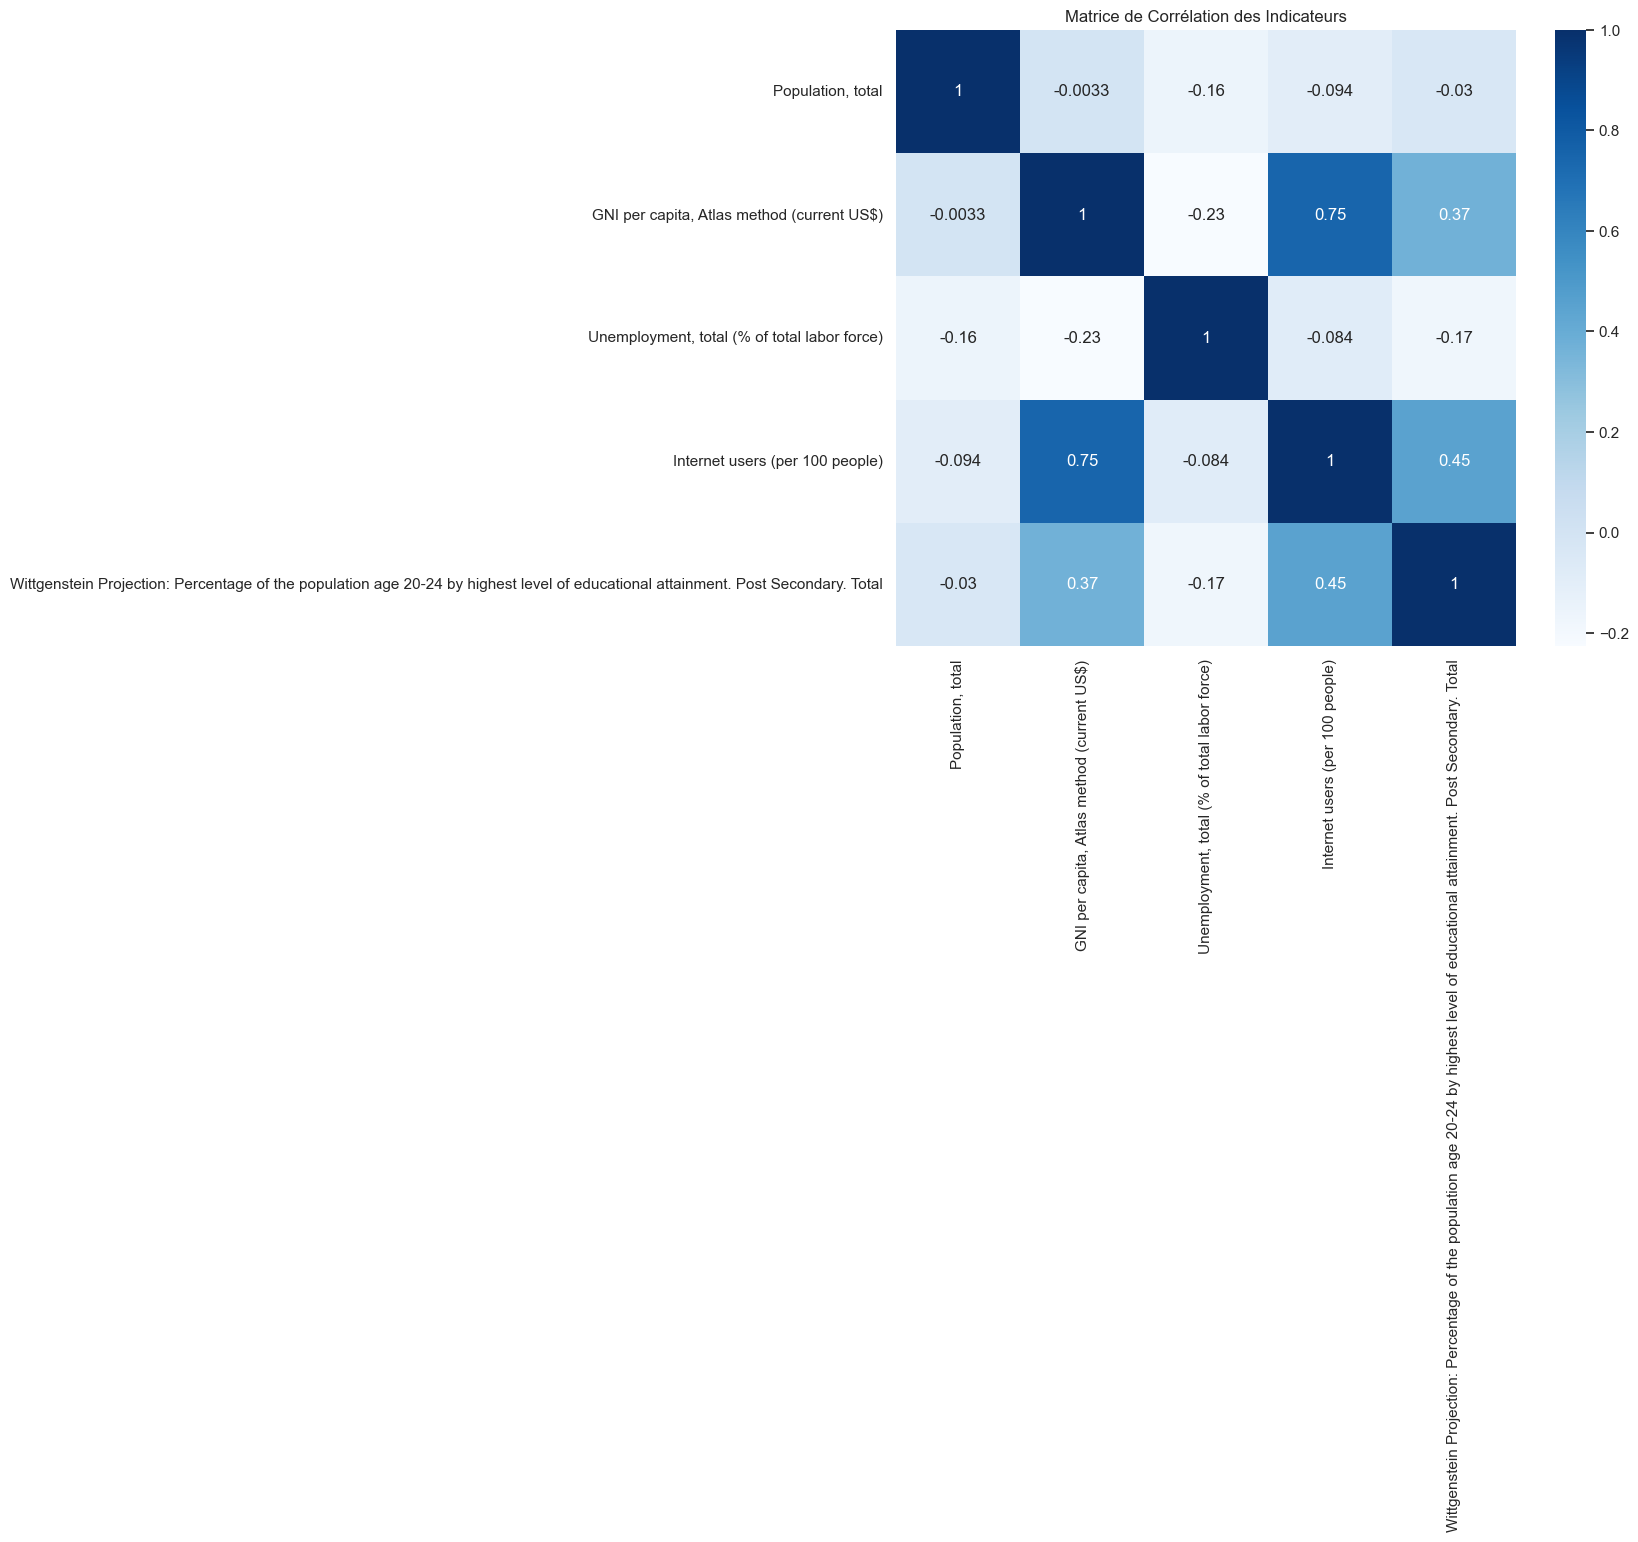

In [793]:
# Sélection des colonnes numériques pour la corrélation
cols_corr = ['Population, total', 'GNI per capita, Atlas method (current US$)', 
             'Unemployment, total (% of total labor force)', 'Internet users (per 100 people)', 
             'Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total']

# Calcul de la matrice de corrélation
corr = data_2015[cols_corr].corr()

# Carte de chaleur
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Matrice de Corrélation des Indicateurs')
plt.show()


L'accès à internet est fortement corrélé à la richesse.

#### <font color='skyblue'> Analyse bi-variée </font>

- Zoom sur la corrélation entre accès à internet et PNB par habitant

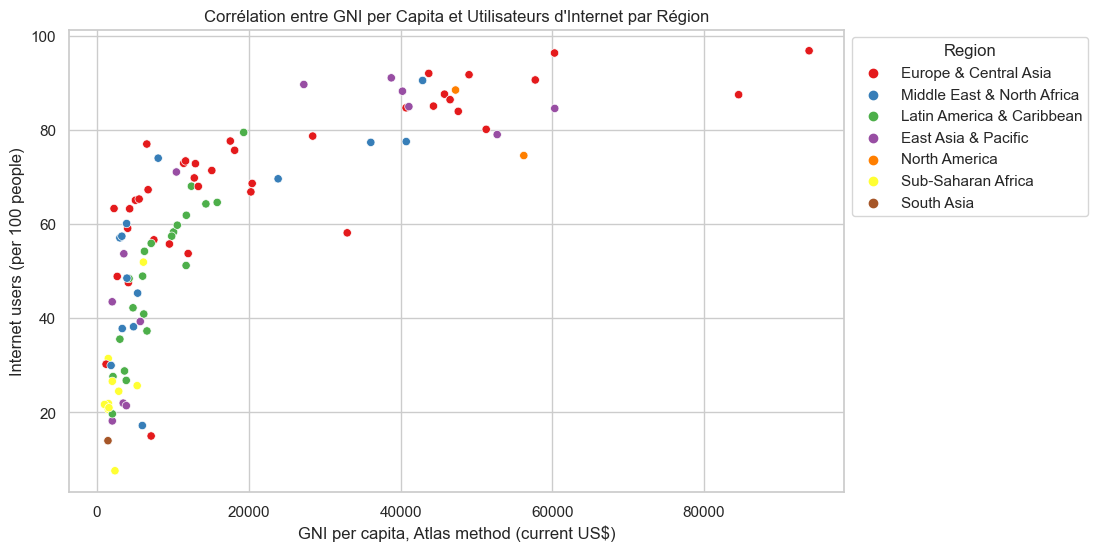

In [794]:
# Diagramme de dispersion avec couleur par région
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GNI per capita, Atlas method (current US$)', 
                y='Internet users (per 100 people)', 
                hue='Region',  
                data=data_2015,
                palette='Set1') 
plt.title('Corrélation entre GNI per Capita et Utilisateurs d\'Internet par Région')
plt.xlabel('GNI per capita, Atlas method (current US$)')
plt.ylabel('Internet users (per 100 people)')
plt.legend(title='Region', bbox_to_anchor=(1, 1))
plt.show()


On constate que les pays d'Europe sont plus présents dans les pays les plus connectés, certains pays d'Asie de l'est d'Amérique du Nord et du moyen orient sont aussi très connectés.

- Zoom sur la corrélation entre le taux de chomage et les dépenses dans l'éducation post bac

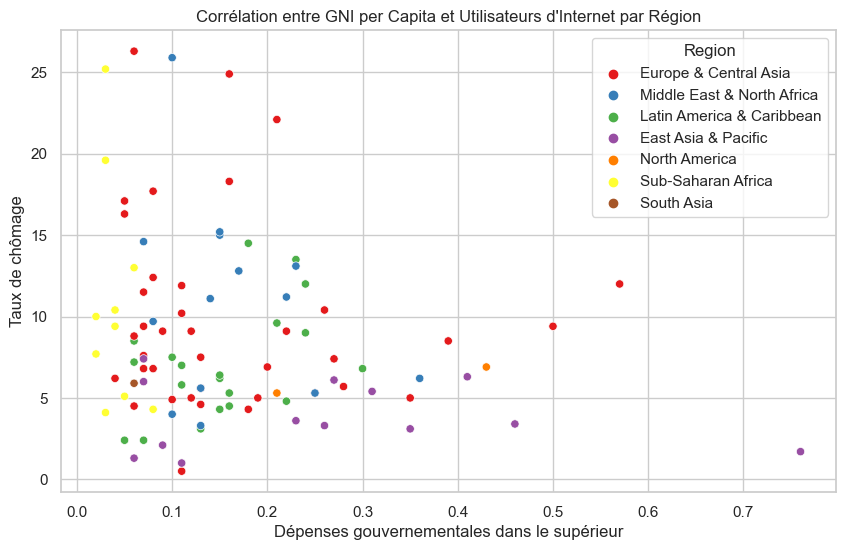

In [795]:
# Diagramme de dispersion avec couleur par région
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total', 
                y='Unemployment, total (% of total labor force)', 
                hue='Region',  
                data=data_2015,
                palette='Set1') 
plt.title('Corrélation entre GNI per Capita et Utilisateurs d\'Internet par Région')
plt.xlabel('Dépenses gouvernementales dans le supérieur')
plt.ylabel('Taux de chômage')
plt.legend(title='Region', bbox_to_anchor=(1, 1)) 
plt.show()

Il est intérressant de se rendre compte que les pays qui dépensent le plus en éducations supérieures ne sont pas mécaniquement les pays qui ont le taux de chomage le plus faible. On dégage tout de meme une tendance, les pays dépénsant le moins dans le supérieurs ont des taux de chomage légérement plus élevés.

### <font color='aqua'> 3. Classement des pays  </font>

#### <font color='skyblue'> Création d'un score </font>

Nous allons développer une méthodologie pour attribuer un score compris entre 0 et 1 à chaque pays, basé sur leur performance relative à l'un des cinq indicateurs clés retenus. Cette approche pondérée permettra d'évaluer et de comparer les pays de manière quantifiable. Nous utiliserons des critères spécifiques pour chaque indicateur, garantissant ainsi que les scores reflètent fidèlement la performance de chaque pays dans les domaines concernés. Cette méthode offre une perspective claire et normalisée pour l'analyse comparative des pays.

In [796]:
#création d'une copie du df
score_df=data_2015.copy()

#extraction des valeurs maximales pour calcul valeurs pondérées
max_popdf = max(data_2015["Population, total"])
max_gnidf = max(data_2015["GNI per capita, Atlas method (current US$)"])
max_unempdf = max(data_2015["Unemployment, total (% of total labor force)"])
max_interdf = max(data_2015["Internet users (per 100 people)"])
max_expendf = max(data_2015["Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total"])


In [797]:
#calcul des valeurs pondérées pour chaque variable
score_df['Population Score']=score_df['Population, total']/max_popdf
score_df['Wealth Score']=score_df['GNI per capita, Atlas method (current US$)']/max_gnidf
score_df['Unemployment Score']=score_df['Unemployment, total (% of total labor force)']/max_unempdf
score_df['Internet Score']=score_df['Internet users (per 100 people)']/max_interdf
score_df['Education Score']=score_df['Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total']/max_expendf


In [798]:
# Fusionner score_df avec score_evo_df pour ajouter la colonne "Variation Score"
score_df = pd.merge(score_df, score_evo_df[['Country Name', 'Variation Score']], on='Country Name', how='left')

score_df.head(2)


Country Name                      Region  Population, total  \
0               Albania       Europe & Central Asia          2880703.0   
1  United Arab Emirates  Middle East & North Africa          9154302.0   

   GNI per capita, Atlas method (current US$)  \
0                                      4290.0   
1                                     42910.0   

   Unemployment, total (% of total labor force)  \
0                                          17.1   
1                                           4.0   

   Internet users (per 100 people)  \
0                        63.252933   
1                        90.500000   

   Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total  \
0                                               0.05                                                                                   
1                                               0.10                                                                                   

   Year  Population Score  Wealth Score  Unemployment Score  Internet Score  \
0  2015          0.008977      0.045706            0.650190        0.653370   
1  2015          0.028527      0.457170            0.152091        0.934818   

   Education Score  Variation Score  
0         0.065789         0.511059  
1         0.131579         0.595640

In [799]:
# Selection des colonnes utiles
score_df= score_df[['Country Name','Population Score','Wealth Score','Unemployment Score','Internet Score', 'Education Score','Variation Score']]


In [800]:
score_df.head(10)

Country Name  Population Score  Wealth Score  Unemployment Score  \
0                 Albania          0.008977      0.045706            0.650190   
1    United Arab Emirates          0.028527      0.457170            0.152091   
2               Argentina          0.135301      0.132431            0.273764   
3                 Armenia          0.009090      0.042936            0.695817   
4               Australia          0.074134      0.642766            0.231939   
5                 Austria          0.026903      0.507245            0.216730   
6              Azerbaijan          0.030070      0.069785            0.190114   
7                 Belgium          0.035133      0.472406            0.323194   
8                Bulgaria          0.022369      0.079693            0.346008   
9  Bosnia and Herzegovina          0.011019      0.053804            1.000000   

   Internet Score  Education Score  Variation Score  
0        0.653370         0.065789         0.511059  
1        0.934818         0.131579         0.595640  
2        0.702849         0.078947         0.611237  
3        0.610497         0.210526         0.596665  
4        0.873466         0.355263         0.577924  
5        0.867058         0.368421         0.494683  
6        0.795370         0.250000         0.579185  
7        0.878552         0.513158         0.468551  
8        0.585230         0.118421         0.454863  
9        0.672093         0.078947         0.482716

In [801]:
#calcul d'un score où chaque variable a le meme poids
score_df['Final Score']=(score_df['Population Score'] + score_df['Wealth Score'] + score_df['Unemployment Score'] + score_df['Internet Score'] + score_df['Education Score'] + score_df['Variation Score'])*100/6

score_df=score_df.sort_values(by=['Final Score'], ascending=False).reset_index(drop=True)

score_df= score_df[['Country Name','Final Score']]

score_df.head(15)

Country Name  Final Score
0    United States    53.860729
1           Norway    48.901541
2        Singapore    48.020335
3            Japan    48.002417
4          Ireland    47.453540
5            Spain    47.372548
6           Canada    47.174076
7        Australia    45.924865
8           France    45.450360
9          Belgium    44.849896
10          Sweden    44.643167
11          Greece    43.214859
12  United Kingdom    42.847172
13     Netherlands    42.148467
14     New Zealand    41.665992

Notre choix d'expansion interntionale se portera sur les Etats unis.

#### <font color='skyblue'> Conclusion synthétique</font>

Après avoir appliqué notre méthode de scoring, nous avons identifié les pays les plus performants. Ces pays se distinguent par leur excellence dans les domaines spécifiques mesurés par les indicateurs sélectionnés, reflétant leur efficacité, leur développement et leur engagement dans ces domaines clés. Cette analyse fournit des insights précieux pour comprendre les facteurs de succès et peut guider des décisions stratégiques dans divers contextes internationaux.
Les Etats Unis trustent le haut du classement avec un score élevé pour chacun des critères choisis. Il s'agit d'un candidat parfait car en plus d'être objectivement bon, la culture occidentale identique à la notre facilitera notre intégration, et les investissements dans des cours en anglais serviront pour continuer notre expansion dans d'autres régions du monde. D'ailleurs dans le classement nous observons pas moins de 6 pays anglophones en plus des USA qui seront de parfaits candidats à la suite de notre expansion.